In [ ]:
!pip install beautifulsoup4
!pip install requests
!pip install pandas
!pip install tqdm
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
import re
from datetime import datetime, timedelta
import zipfile
import io
import xml.etree.ElementTree as ET
from concurrent.futures import ThreadPoolExecutor, as_completed
from datetime import datetime, timedelta
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry


In [4]:
# ÏöîÏïΩÎ≥¥Í∏∞
pd.set_option('display.max_rows', 100)

In [2]:
#Ï†ÑÏ≤¥Ìñâ Î≥¥Í∏∞ 
pd.set_option('display.max_rows', None)

In [49]:
%matplotlib inline
plt.rcParams['font.family'] = 'AppleGothic' # macOS ÏÇ¨Ïö©Ïûê
plt.rcParams['axes.unicode_minus'] = False

# Ìà¨Ïûê Ï†ÑÎûµ ÏàòÎ¶Ω Î∞©Ïïà

## 1. ÌõÑÎ≥¥Íµ∞ ÏÑ†Ï†ï
### 1) ÏÑ†Ï†ïÍ∏∞Ï§Ä
- Ï†ÑÏ≤¥ ÏÉÅÏû• Ï¢ÖÎ™©(ÏΩîÏä§Ìîº + ÏΩîÏä§Îã•) Ï§ë ÏãúÏ¥ùÎ≥ÄÌôîÎüâ(24ÎÖÑ 1Ïõî ~ 24ÎÖÑ 12Ïõî) ÏÉÅÏúÑ 00% Ï∂îÏ∂ú(ÏÇ¨Ïö©Ïûê ÏÑ†ÌÉù)
- Ï§ëÏÜåÌòïÏ£º Ï§ë ÏµúÍ∑º 1ÎÖÑ ÏàòÏùµÎ•† ÏÉÅÏúÑ 100Í∞ú Ï∂îÏ∂ú

### 2) ÏãúÍ∞Ä Ï¥ùÏï° ÌïòÏúÑ 30% ~ 70% Ï∂îÏ∂ú(ÏòàÏãú))
#### - ÌïúÍµ≠Í±∞ÎûòÏÜå APIÏóêÏÑú ÏãúÍ∞Ä Ï¥ùÏï° Í∏∞Ï§ÄÏúºÎ°ú ÌÅ¨Î°§ÎßÅ

In [3]:
def get_stock_info(basDd):
  url = {
  "kospi_url": "http://data-dbg.krx.co.kr/svc/apis/sto/stk_bydd_trd",
  "kosdaq_url": "http://data-dbg.krx.co.kr/svc/apis/sto/ksq_bydd_trd"
  }

  params = {
    "basDd": basDd.strftime("%Y%m%d")
  }

  headers = {
    "AUTH_KEY": "18CEC6172A764513B4C60CAA3E3186D3AE2453C3"
  }
  market_is_open = requests.get(list(url.values())[0], params=params, headers=headers)
  if (market_is_open.json()['OutBlock_1'] == []):
    # print("Market is closed")
    return None
  # while (market_is_open.json()['OutBlock_1'] == []):
  #   print("Market is closed")
  #   basDd = basDd + timedelta(days=1)
  #   params['basDd'] = basDd.strftime("%Y%m%d")
  #   market_is_open = requests.get(list(url.values())[0], params=params, headers=headers)

  all_stock_info = pd.DataFrame()
    
  for url in url.values():
    response = requests.get(url, params=params, headers=headers)
    if response.status_code == 200:
      data = response.json()
      if 'OutBlock_1' in data:
          krx_stock_info = pd.DataFrame(data['OutBlock_1'])
          
          column_map = {
                'BAS_DD': 'baseDate',
                'ISU_CD': 'stockCode',
                'ISU_NM': 'stockName',
                'MKT_NM': 'marketType',
                'SECT_TP_NM': 'sectorType',
                'TDD_CLSPRC': 'closingPrice',
                'CMPPREVDD_PRC': 'priceChange',
                'FLUC_RT': 'fluctuationRate',
                'TDD_OPNPRC': 'openingPrice',
                'TDD_HGPRC': 'highPrice',
                'TDD_LWPRC': 'lowPrice',
                'ACC_TRDVOL': 'tradingVolume',
                'ACC_TRDVAL': 'tradingValue',
                'MKTCAP': 'marketCap',
                'LIST_SHRS': 'listedShares'
            }

          krx_stock_info = krx_stock_info.rename(columns=column_map)

          numeric_columns = ['closingPrice', 'priceChange', 'fluctuationRate', 'openingPrice', 'highPrice', 'lowPrice', 'tradingVolume', 'tradingValue', 'marketCap', 'listedShares']
          
          for col in numeric_columns:
              if col in krx_stock_info.columns:
                  krx_stock_info[col] = pd.to_numeric(krx_stock_info[col].str.replace(',', ''), errors='coerce')
          
          all_stock_info = pd.concat([all_stock_info, krx_stock_info])

      # print("Data retrieved successfully:")
    else:
        print(f"Failed to retrieve data. HTTP Status Code: {response.status_code}")
        print("Response:", response.text)
  return all_stock_info

In [4]:
basDd = datetime.strptime("20250103", "%Y%m%d")
# basDd = datetime.now() - timedelta(days=1)
all_stock_info = get_stock_info(basDd)
sorted_data = all_stock_info.sort_values(by='marketCap', ascending=True)

#### - ETF, ETN, ÏßÄÏàòÏ∂îÏ¢Ö, Ïö∞ÏÑ†Ï£º, Í¥ÄÎ¶¨Ï¢ÖÎ™© Îì± Ï¢ÖÎ™© ÌïÑÌÑ∞ÎßÅ

In [5]:
# ETF Í¥ÄÎ†® ÌÇ§ÏõåÎìú
filter_ETF = [
    "TIGER", "KODEX", "HANARO", "ARIRANG", 
    "KBSTAR", "KOSEF", "SOL", "BNK", 
    "PLUS", "WON", "FOCUS", "KIWOOM", "ACE",
    "KoAct", "Ïï°Ìã∞Î∏å", "S&P", "TREX", "ITF", "ÎÇòÏä§Îã•",
    "Î∞∏Î•òÏóÖ", "(H)", "ÎßàÏù¥Ìã∞", "ÏΩîÏä§Ìîº"
]

# Ïù∏Î≤ÑÏä§/Î†àÎ≤ÑÎ¶¨ÏßÄ Í¥ÄÎ†® ÌÇ§ÏõåÎìú
filter_inverse_leverage = [
    "Ïù∏Î≤ÑÏä§", "Î†àÎ≤ÑÎ¶¨ÏßÄ", "ÏÑ†Î¨º", "ETN", "RISE"
]

# Ïö∞ÏÑ†Ï£º/Ï†ÑÌôòÏÇ¨Ï±Ñ Í¥ÄÎ†® ÌÇ§ÏõåÎìú
filter_preferred = [
    "Ïö∞ÏÑ†Ï£º", "Ïö∞B", "Ï†ÑÌôòÏÇ¨Ï±Ñ"
]

# Í∏∞ÌÉÄ Ï†úÏô∏Ìï† ÌÇ§ÏõåÎìú
filter_etc = [
    "Ïä§Ìå©", "Î¶¨Ï∏†", "Î∞∞Îãπ"
]

filter_sector = [
  'Í¥ÄÎ¶¨Ï¢ÖÎ™©(ÏÜåÏÜçÎ∂ÄÏóÜÏùå)', 'Ìà¨ÏûêÏ£ºÏùòÌôòÍ∏∞Ï¢ÖÎ™©(ÏÜåÏÜçÎ∂ÄÏóÜÏùå)', 'Ïô∏Íµ≠Í∏∞ÏóÖ(ÏÜåÏÜçÎ∂ÄÏóÜÏùå)'
]

# Ï†ÑÏ≤¥ ÌïÑÌÑ∞ÎßÅ ÌÇ§ÏõåÎìú ÌÜµÌï©
filter_keyword = list(set(
    filter_ETF + 
    filter_inverse_leverage + 
    filter_preferred + 
    filter_etc
))


keyword_filtered = sorted_data[~sorted_data['stockName'].apply(lambda x: 
    any(keyword in x for keyword in filter_keyword) or 
    bool(re.search(r'Ïö∞$', x)) or
    bool(re.search(r'^HK', x))

)]

sector_filtered = keyword_filtered[~keyword_filtered['sectorType'].apply(lambda x : x in filter_sector)]

# ÌïòÏúÑ 30%Ïùò Ï¢ÖÎ™©Îßå ÌïÑÌÑ∞ÎßÅ
filtered_data = sector_filtered.iloc[int(len(sorted_data)*0.4):int(len(sorted_data)*0.8)]
print(len(filtered_data))

1098


#### - Í±∞ÎûòÎüâ ÌïÑÌÑ∞ÎßÅ

In [6]:
# Í±∞ÎûòÎüâ Í∏∞Î≥∏ ÌÜµÍ≥Ñ ÌôïÏù∏
filtered_data = filtered_data[filtered_data['tradingVolume'].apply(lambda x : x != 0)]

volume_stats = {
    'ÏµúÎåÄ Í±∞ÎûòÎüâ': filtered_data['tradingVolume'].max(),
    'ÏµúÏÜå Í±∞ÎûòÎüâ': filtered_data['tradingVolume'].min(),
    'ÌèâÍ∑† Í±∞ÎûòÎüâ': filtered_data['tradingVolume'].mean(),
    'Ï§ëÍ∞ÑÍ∞í': filtered_data['tradingVolume'].median(),
    'ÌëúÏ§ÄÌé∏Ï∞®': filtered_data['tradingVolume'].std()
}

# Í≤∞Í≥º Ï∂úÎ†•
for key, value in volume_stats.items():
    print(f"{key}: {value:,.0f}")

# Í±∞ÎûòÎüâ Î∂ÑÌè¨ ÌôïÏù∏ (ÏÇ¨Î∂ÑÏúÑÏàò)
print("\nÏÇ¨Î∂ÑÏúÑÏàò Î∂ÑÌè¨:")
print(filtered_data['tradingVolume'].describe())

# Ï§ëÏïôÍ∞í Ïù¥ÏÉÅÏù¥Î©¥ÏÑú ÏÉÅÏúÑ 95%Ïóê Ìï¥ÎãπÌïòÎäî Ï¢ÖÎ™© ÌïÑÌÑ∞ÎßÅ
volume_filtered = filtered_data[
    (filtered_data['tradingVolume'] >= filtered_data['tradingVolume'].quantile(0.5)) &
    (filtered_data['tradingVolume'] <= filtered_data['tradingVolume'].quantile(0.95)) 
]
print(len(volume_filtered))

ÏµúÎåÄ Í±∞ÎûòÎüâ: 66,692,558
ÏµúÏÜå Í±∞ÎûòÎüâ: 121
ÌèâÍ∑† Í±∞ÎûòÎüâ: 641,519
Ï§ëÍ∞ÑÍ∞í: 95,224
ÌëúÏ§ÄÌé∏Ï∞®: 2,902,748

ÏÇ¨Î∂ÑÏúÑÏàò Î∂ÑÌè¨:
count    1.089000e+03
mean     6.415189e+05
std      2.902748e+06
min      1.210000e+02
25%      3.396400e+04
50%      9.522400e+04
75%      3.165080e+05
max      6.669256e+07
Name: tradingVolume, dtype: float64
490


In [7]:
last_year = basDd - timedelta(days=365)
last_stock_info = get_stock_info(last_year)

In [8]:
# ÌòÑÏû¨ Îç∞Ïù¥ÌÑ∞ÏôÄ ÏûëÎÖÑ Îç∞Ïù¥ÌÑ∞Î•º Ï¢ÖÎ™©Î™Ö Í∏∞Ï§ÄÏúºÎ°ú Ìï©ÏπòÍ∏∞
merged_df = volume_filtered.merge(last_stock_info, 
            on='stockName',  # Ï¢ÖÎ™©Î™ÖÏùÑ Í∏∞Ï§ÄÏúºÎ°ú Ìï©Ïπ®
            how='left',   # ÌòÑÏû¨ Îç∞Ïù¥ÌÑ∞(365Ï¢ÖÎ™©)Î•º Í∏∞Ï§ÄÏúºÎ°ú left join
            suffixes=('_current', '_last_year'))  # Ïª¨Îüº Íµ¨Î∂ÑÏùÑ ÏúÑÌïú Ï†ëÎØ∏ÏÇ¨
merged_df["annual_return"] = (merged_df["closingPrice_current"] - merged_df["closingPrice_last_year"]) / merged_df["closingPrice_last_year"]
merged_df["marketCap_change"] = (merged_df["marketCap_current"] - merged_df["marketCap_last_year"]) / merged_df["marketCap_last_year"]
print(len(merged_df))
merged_df['annual_return'].describe()

490


count    448.000000
mean      -0.050038
std        0.571582
min       -0.888147
25%       -0.348155
50%       -0.164695
75%        0.069102
max        5.863014
Name: annual_return, dtype: float64

### 3) Íµ¨Í∞ÑÎ≥Ñ ÏàòÏùµÎ•† vs ÏãúÏ¥ùÏ¶ùÍ∞êÎ•† Í≤∞Í≥º Î∂ÑÏÑù

#### Ï£ºÍ∞Ä ÏàòÏùµÎ•† Í∏∞Ï§Ä

| Íµ¨Í∞Ñ | Ï¢ÖÎ™©Ïàò | ÌèâÍ∑† | ÌëúÏ§ÄÌé∏Ï∞® | ÏµúÏÜåÍ∞í | Ï§ëÍ∞ÑÍ∞í | ÏµúÎåÄÍ∞í |
|------|--------|------|----------|--------|--------|--------|
| ~30% | 332Í∞ú | -3.38% | 73.95% | -79.15% | -12.34% | 924.77% |
| 30~70% | 445Í∞ú | 6.93% | 57.26% | -77.91% | -1.48% | 735.28% |
| 50~80% | 340Í∞ú | 16.62% | 72.39% | -77.91% | 2.02% | 702.27% |
| 40~80% | 456Í∞ú | 13.51% | 66.04% | -77.91% | 0.62% | 702.27% |

#### ÏãúÏ¥ùÏ¶ùÍ∞êÎ•† Í∏∞Ï§Ä

| Íµ¨Í∞Ñ | Ï¢ÖÎ™©Ïàò | ÌèâÍ∑† | ÌëúÏ§ÄÌé∏Ï∞® | ÏµúÏÜåÍ∞í | Ï§ëÍ∞ÑÍ∞í | ÏµúÎåÄÍ∞í |
|------|--------|------|----------|--------|--------|--------|
| ~30% | 332Í∞ú | -9.57% | 28.06% | -79.15% | -11.49% | 129.20% |
| 30~70% | 445Í∞ú | 9.63% | 45.94% | -77.82% | 1.34% | 304.15% |
| 50~80% | 340Í∞ú | 21.80% | 74.88% | -77.82% | 3.66% | 725.30% |
| 40~80% | 456Í∞ú | 18.17% | 68.49% | -77.82% | 2.71% | 725.30% |


### 4) Ï¢ÖÎ™© ÏµúÏ¢Ö ÏÑ†Ï†ï
- ÏãúÏ¥ù Ï¶ùÍ∞êÎ•† Í∏∞Ï§Ä ÏÑ†ÌÉù : Ï£ºÍ∞Ä + ÏÉÅÏû•Ï£ºÏãùÏàò Î≥ÄÎèôÏùÑ Î™®Îëê Î∞òÏòÅÌïú Ïã§Ï†ú Í∏∞ÏóÖÍ∞ÄÏπò Î≥ÄÌôî
- ÏãúÏ¥ù 40% ~ 80% Íµ¨Í∞Ñ ÏÑ†Ï†ï : 4Í∞úÏùò ÌëúÎ≥∏ Ï§ë Ï§ëÍ∞Ñ ÌëúÏ§ÄÌé∏Ï∞®, ÏïàÏ†ïÏ†Å ÏàòÏùµ Í∏∞ÎåÄ

In [9]:
selected_df = merged_df[
    (merged_df['marketCap_change'] >= merged_df['marketCap_change'].quantile(0.6)) &  
    (merged_df['marketCap_change'] <= merged_df['marketCap_change'].quantile(0.9))  
]

selected_df['marketCap_change'].describe()

count    134.000000
mean       0.186527
std        0.189559
min       -0.050064
25%        0.026579
50%        0.135938
75%        0.330584
max        0.584381
Name: marketCap_change, dtype: float64

In [10]:
final_df = selected_df.filter(
  items=['marketType_current', 'stockName', 'stockCode_current', 'sectorType_current', 'marketCap_change', 'annual_return', 'listedShares_last_year']
  ).rename(columns={
    'marketType_current': 'marketType',
    'stockCode_current': 'stockCode',
    'sectorType_current': 'sectorType',
    'marketCap_change': 'marketCap_change',
    'annual_return': 'annual_return',
    'listedShares_last_year': 'listedShares'
})

## 2. Ïû¨Î¨¥Ïû¨Ìëú Ï†ïÎ≥¥ ÏàòÏßë
### 1) Í∏∞ÏóÖÏΩîÎìú Í∞ÄÏ†∏Ïò§Í∏∞

In [11]:
url = "https://opendart.fss.or.kr/api/corpCode.xml"

params = {
    "crtfc_key": "4758096e577a50f35eaec98b171e463367c7c23f"
}

# ZIP ÌååÏùº Îã§Ïö¥Î°úÎìú
response = requests.get(url, params=params)

# ZIP ÌååÏùº ÏïïÏ∂ï Ìï¥Ï†ú
with zipfile.ZipFile(io.BytesIO(response.content)) as zf:
    # CORPCODE.xml ÌååÏùº ÏùΩÍ∏∞
    xml_data = zf.read('CORPCODE.xml')
    
# XML ÌååÏã±
root = ET.fromstring(xml_data)

# Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏ (ÏòàÏãú)
data = []
for company in root.findall('list'):
    stock_code = company.findtext('stock_code')
    if stock_code and stock_code.strip():  # Ï¢ÖÎ™©ÏΩîÎìúÍ∞Ä Ï°¥Ïû¨ÌïòÍ≥† Í≥µÎ∞±Ïù¥ ÏïÑÎãå Í≤ΩÏö∞Îßå
        data.append({
            'corp_code': company.findtext('corp_code'),
            'corp_name': company.findtext('corp_name'),
            'stockCode': stock_code,
            'last_update': company.findtext('modify_date')
        })

# DataFrame ÏÉùÏÑ±
analysis_df = pd.DataFrame(data)

In [12]:
final_summary = pd.merge(final_df, 
                  analysis_df[['corp_code', 'stockCode']],
                  on='stockCode',
                  how='left')

### 2) Ïû¨Î¨¥Ïû¨Ìëú Í∞ÄÏ†∏Ïò§Í∏∞(1ÎÖÑ)

In [13]:
def api_call(corp_code, bsns_year, reprt_code):
   url = "https://opendart.fss.or.kr/api/fnlttSinglAcntAll.json"
   params = {
       "crtfc_key": "4758096e577a50f35eaec98b171e463367c7c23f",
       "corp_code": corp_code,
       "bsns_year": bsns_year,
       "reprt_code": reprt_code,
       "fs_div": "OFS"
   }
   response = requests.get(url, params=params)
   return response

def find_account_by_keywords(df, keyword_list):
   """ÌÇ§ÏõåÎìú Î¶¨Ïä§Ìä∏Î°ú Í≥ÑÏ†ïÍ≥ºÎ™© Ï∞æÍ∏∞"""
   for keyword in keyword_list:
       found = df[df['account_nm'] == keyword]
       if not found.empty:
           return found.iloc[0]
   return None

def get_quarter_data(response):
   """Ìïú Î∂ÑÍ∏∞ Îç∞Ïù¥ÌÑ∞Î•º ÎîïÏÖîÎÑàÎ¶¨Î°ú Î∞òÌôò"""
   df = pd.DataFrame(response.json()['list'])

   disclosure_date = df.iloc[0]['rcept_no'][:8] if not df.empty else None
   
   account_keywords = {
      'CIS': {
        'Îß§Ï∂úÏï°': ['Îß§Ï∂úÏï°', 'ÏàòÏùµ(Îß§Ï∂úÏï°)', 'I. ÏòÅÏóÖÏàòÏùµ','ÏòÅÏóÖÏàòÏùµ','ÏàòÏùµ Ìï©Í≥Ñ','‚Ö†. Îß§Ï∂úÏï°'],
        'Îß§Ï∂úÏ¥ùÏù¥Ïùµ': ['Îß§Ï∂úÏ¥ùÏù¥Ïùµ', 'III. ÏòÅÏóÖÏù¥Ïùµ(ÏÜêÏã§)','‚Ö¢. Îß§Ï∂úÏ¥ùÏù¥Ïùµ(ÏÜêÏã§)'],  # ÏòÅÏóÖÏàòÏùµ-ÏòÅÏóÖÎπÑÏö©
        'Îß§Ï∂úÏõêÍ∞Ä': ['Îß§Ï∂úÏõêÍ∞Ä', '‚Ö°. ÏòÅÏóÖÎπÑÏö©'],
        'ÏòÅÏóÖÏù¥Ïùµ': ['ÏòÅÏóÖÏù¥Ïùµ(ÏÜêÏã§)', 'ÏòÅÏóÖÏù¥Ïùµ', 'III. ÏòÅÏóÖÏù¥Ïùµ(ÏÜêÏã§)','‚Ö£. ÏòÅÏóÖÏù¥Ïùµ(ÏÜêÏã§)','ÏòÅÏóÖÏÜêÏùµ'],
        'ÎãπÍ∏∞ÏàúÏù¥Ïùµ': ['ÎãπÍ∏∞ÏàúÏù¥Ïùµ(ÏÜêÏã§)', 'VIII. Î∂ÑÍ∏∞ÏàúÏù¥Ïùµ(ÏÜêÏã§)',
                   'VIII. ÎãπÍ∏∞ÏàúÏù¥Ïùµ(ÏÜêÏã§)','ÎãπÍ∏∞ÏàúÏù¥Ïùµ',
                   'Î∂ÑÍ∏∞ÏàúÏù¥Ïùµ','Î∞òÍ∏∞ÏàúÏù¥Ïùµ','Î∂ÑÍ∏∞ÏàúÏù¥Ïùµ(ÏÜêÏã§)','Î∞òÍ∏∞ÏàúÏù¥Ïùµ(ÏÜêÏã§)','Ïó∞Í≤∞Î∂ÑÍ∏∞ÏàúÏù¥Ïùµ','Ïó∞Í≤∞Î∞òÍ∏∞ÏàúÏù¥Ïùµ','Ïó∞Í≤∞ÎãπÍ∏∞ÏàúÏù¥Ïùµ',
                   '1. ÎãπÍ∏∞ÏàúÏù¥Ïùµ(ÏÜêÏã§)','ÎãπÍ∏∞Ïó∞Í≤∞ÏàúÏÜêÏùµ', 'Î∞òÍ∏∞ÏàúÏÜêÏùµ','Ïó∞Í≤∞Î∞òÍ∏∞ÏàúÏù¥Ïùµ(ÏÜêÏã§)','Ïó∞Í≤∞Î∂ÑÍ∏∞ÏàúÏù¥Ïùµ(ÏÜêÏã§)','Ïó∞Í≤∞Î∂ÑÍ∏∞ÏàúÏù¥Ïùµ'],
        'Í∏àÏúµÏõêÍ∞Ä': ['Í∏àÏúµÏõêÍ∞Ä', 'Í∏àÏúµÎπÑÏö©', 'Ïù¥ÏûêÎπÑÏö©'],
        'Í∏àÏúµÏàòÏùµ': ['Í∏àÏúµÏàòÏùµ', 'Í∏àÏúµÏàòÏûÖ', 'Ïù¥ÏûêÏàòÏùµ']
    },
       'BS_ÏûêÏÇ∞': {
           'ÏûêÏÇ∞Ï¥ùÍ≥Ñ': ['ÏûêÏÇ∞Ï¥ùÍ≥Ñ','Í∏∞ÎßêÏûêÏÇ∞','ÏûêÏÇ∞'],
           'Ïú†ÎèôÏûêÏÇ∞': ['Ïú†ÎèôÏûêÏÇ∞'],
           'ÌòÑÍ∏àÎ∞èÌòÑÍ∏àÏÑ±ÏûêÏÇ∞': ['ÌòÑÍ∏àÎ∞èÌòÑÍ∏àÏÑ±ÏûêÏÇ∞', 'ÌòÑÍ∏àÏÑ±ÏûêÏÇ∞']
       },
       'BS_Î∂ÄÏ±Ñ': {
           'Î∂ÄÏ±ÑÏ¥ùÍ≥Ñ': ['Î∂ÄÏ±ÑÏ¥ùÍ≥Ñ','Í∏∞ÎßêÎ∂ÄÏ±Ñ','Î∂ÄÏ±Ñ'],
           'Ïú†ÎèôÎ∂ÄÏ±Ñ': ['Ïú†ÎèôÎ∂ÄÏ±Ñ']
       },
       'BS_ÏûêÎ≥∏': {
           'ÏûêÎ≥∏Ï¥ùÍ≥Ñ': ['ÏûêÎ≥∏Ï¥ùÍ≥Ñ','Í∏∞ÎßêÏûêÎ≥∏','ÏûêÎ≥∏'],
           'ÏûêÎ≥∏Í∏à': ['ÏûêÎ≥∏Í∏à']
       }
   }
   
   quarter_data = {}
   
   for category, account_dict in account_keywords.items():
       for account_key, keyword_list in account_dict.items():
           item = find_account_by_keywords(df, keyword_list)
           if item is not None:
               key = f"{category}_{account_key}"
               amount = item['thstrm_amount']
               if pd.notna(amount) and amount != '':
                   quarter_data[key] = int(amount)
               else:
                   quarter_data[key] = 0
           else:
               key = f"{category}_{account_key}"
               quarter_data[key] = 0
   
   return quarter_data, disclosure_date

def get_corp_quarter_data(corp_code, bsns_year, reprt_code = None):
    # 4Í∞ú Î∂ÑÍ∏∞ API Ìò∏Ï∂ú Î∞è Îç∞Ïù¥ÌÑ∞ ÏàòÏßë
    response_2023_4q = api_call(corp_code, str(int(bsns_year)-1), "11011")
    response_2024_1q = api_call(corp_code, bsns_year, "11013")
    response_2024_2q = api_call(corp_code, bsns_year, "11012")
    response_2024_3q = api_call(corp_code, bsns_year, "11014")
    response_2024_4q = api_call(corp_code, bsns_year, "11011")

    q4_2023, q4_2023_date = get_quarter_data(response_2023_4q)
    q1_2024, q1_date = get_quarter_data(response_2024_1q)
    q2_2024, q2_date = get_quarter_data(response_2024_2q)
    q3_2024, q3_date = get_quarter_data(response_2024_3q)
    q4_2024, q4_date = get_quarter_data(response_2024_4q)

    # ÌÜµÌï© ÌÖåÏù¥Î∏î ÏÉùÏÑ±
    results = []

    results.append({
        'Íµ¨Î∂Ñ': 'Í≥µÏãúÏ†ïÎ≥¥',
        'Í≥ÑÏ†ïÍ≥ºÎ™©': 'Í≥µÏãúÎÇ†Ïßú',
        '2023_4Q': q4_2023_date if q4_2023_date else 'N/A',
        '2024_1Q': q1_date if q1_date else 'N/A',
        '2024_2Q': q2_date if q2_date else 'N/A', 
        '2024_3Q': q3_date if q3_date else 'N/A',
        '2024_4Q': q4_date if q4_date else 'N/A',
        'Î∞úÍ≤¨Ïó¨Î∂Ä': 'O'
    })

    account_list = {
        'CIS': ['Îß§Ï∂úÏï°', 'Îß§Ï∂úÏ¥ùÏù¥Ïùµ', 'Îß§Ï∂úÏõêÍ∞Ä', 'ÏòÅÏóÖÏù¥Ïùµ', 'ÎãπÍ∏∞ÏàúÏù¥Ïùµ', 'Í∏àÏúµÏõêÍ∞Ä', 'Í∏àÏúµÏàòÏùµ'],
        'BS_ÏûêÏÇ∞': ['ÏûêÏÇ∞Ï¥ùÍ≥Ñ', 'Ïú†ÎèôÏûêÏÇ∞', 'ÌòÑÍ∏àÎ∞èÌòÑÍ∏àÏÑ±ÏûêÏÇ∞'],
        'BS_Î∂ÄÏ±Ñ': ['Î∂ÄÏ±ÑÏ¥ùÍ≥Ñ', 'Ïú†ÎèôÎ∂ÄÏ±Ñ'],
        'BS_ÏûêÎ≥∏': ['ÏûêÎ≥∏Ï¥ùÍ≥Ñ', 'ÏûêÎ≥∏Í∏à']
    }

    for category, accounts in account_list.items():
        for account in accounts:
            key = f"{category}_{account}"
            
            results.append({
                'Íµ¨Î∂Ñ': category,
                'Í≥ÑÏ†ïÍ≥ºÎ™©': account,
                '2023_4Q': q4_2023.get(key, 0),
                '2024_1Q': q1_2024.get(key, 0),
                '2024_2Q': q2_2024.get(key, 0),
                '2024_3Q': q3_2024.get(key, 0),
                '2024_4Q': q4_2024.get(key, 0),
                'Î∞úÍ≤¨Ïó¨Î∂Ä': 'O' if q1_2024.get(key, 0) != 0 else 'X'
            })

    # DataFrame ÏÉùÏÑ± Î∞è Ï∂úÎ†•
    result_df = pd.DataFrame(results)
    return result_df

In [43]:
def create_session_with_retry():
    """Ïû¨ÏãúÎèÑ Î°úÏßÅÏù¥ Ìè¨Ìï®Îêú ÏÑ∏ÏÖò ÏÉùÏÑ±"""
    session = requests.Session()
    retry_strategy = Retry(
        total=3,  # ÏµúÎåÄ 3Î≤à Ïû¨ÏãúÎèÑ
        backoff_factor=1,  # Ïû¨ÏãúÎèÑ Í∞ÑÍ≤©
        status_forcelist=[429, 500, 502, 503, 504],  # Ïû¨ÏãúÎèÑÌï† ÏÉÅÌÉúÏΩîÎìú
    )
    adapter = HTTPAdapter(max_retries=retry_strategy)
    session.mount("http://", adapter)
    session.mount("https://", adapter)
    return session

def background_task(corp_code, corp_name, max_retries=3):
    """Ïû¨ÏãúÎèÑ Î°úÏßÅÏù¥ Ìè¨Ìï®Îêú ÏûëÏóÖ Ìï®Ïàò"""
    for attempt in range(max_retries):
        try:
            # time.sleep(0.2)  # ÏöîÏ≤≠ Í∞Ñ ÎåÄÍ∏∞ÏãúÍ∞Ñ Ï¶ùÍ∞Ä
            data = get_corp_quarter_data(corp_code, "2024")
            return corp_name, data
        except (requests.exceptions.ConnectionError, 
                requests.exceptions.Timeout,
                Exception) as e:
            if attempt < max_retries - 1:
                wait_time = (2 ** attempt) * 0.5  # ÏßÄÏàò Î∞±Ïò§ÌîÑ
                print(f"Ïû¨ÏãúÎèÑ {attempt + 1}/{max_retries} for {corp_name}, ÎåÄÍ∏∞: {wait_time}Ï¥à")
                time.sleep(wait_time)
            else:
                print(f"ÏµúÏ¢Ö Ïã§Ìå®: {corp_name} - {str(e)}")
                return corp_name, None

# ÎèôÏãú Ïã§Ìñâ Ïä§Î†àÎìú ÏàòÎ•º Ï§ÑÏûÑ
with ThreadPoolExecutor(max_workers=5) as executor:
    futures = [
        executor.submit(background_task, row['corp_code'], row['stockName']) 
        for _, row in final_summary.iterrows()
    ]
    
    results = []
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing"):
        results.append(future.result())

# NoneÏù¥ ÏïÑÎãå Í≤∞Í≥ºÎßå ÌïÑÌÑ∞ÎßÅ
result_dict = {name: df for name, df in results if df is not None}

Processing: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 134/134 [00:29<00:00,  4.60it/s]


In [18]:
result_dict.get('ÌÄÄÌÉÄÎß§Ìä∏Î¶≠Ïä§').to_csv('ÌÄÄÌÉÄÎß§Ìä∏Î¶≠Ïä§.csv', index=False, encoding='utf-8-sig')

In [44]:
def check_accounts_for_zero(df, accounts_to_check):
    """Í≥ÑÏ†ïÍ≥ºÎ™©ÏóêÏÑú 0Ïù¥ ÏûàÎäîÏßÄ ÌôïÏù∏"""
    quarterly_cols = ['2023_4Q', '2024_1Q', '2024_2Q', '2024_3Q', '2024_4Q']
    
    for account in accounts_to_check:
        account_row = df[df['Í≥ÑÏ†ïÍ≥ºÎ™©'] == account]
        if not account_row.empty:
            for col in quarterly_cols:
                if col in account_row.columns:
                    if (account_row[col] == 0).any():
                        return True
    return False

columns_to_check = ['ÎãπÍ∏∞ÏàúÏù¥Ïùµ', 'ÏûêÏÇ∞Ï¥ùÍ≥Ñ', 'ÏûêÎ≥∏Ï¥ùÍ≥Ñ', 'Î∂ÄÏ±ÑÏ¥ùÍ≥Ñ','Îß§Ï∂úÏï°','ÏòÅÏóÖÏù¥Ïùµ']

zero_stocks = []
for corp_name, df in result_dict.items():
    if df is not None and not df.empty:
        if check_accounts_for_zero(df, columns_to_check):
            zero_stocks.append(corp_name)

print(f" 0Ïù¥ Ìè¨Ìï®Îêú Ï¢ÖÎ™© Ïàò {len(zero_stocks)} ,0Ïù¥ Ìè¨Ìï®Îêú Ï¢ÖÎ™©: {zero_stocks}, ")

filtered_dict = {
    corp_name: df for corp_name, df in result_dict.items()
    if df is not None and not df.empty and 
    not check_accounts_for_zero(df, columns_to_check)
}

remaining_stocks = list(filtered_dict.keys())

# final_summaryÏóêÏÑú Ìï¥Îãπ Ï¢ÖÎ™©Îì§Îßå ÌïÑÌÑ∞ÎßÅ
filtered_final_summary = final_summary[final_summary['stockName'].isin(remaining_stocks)]

print(f"ÏõêÎûò final_summary Ï¢ÖÎ™© Ïàò: {len(final_summary)}")
print(f"ÌïÑÌÑ∞ÎßÅ ÌõÑ Ï¢ÖÎ™© Ïàò: {len(filtered_final_summary)}")
print(f"Ï†úÍ±∞Îêú Ï¢ÖÎ™© Ïàò: {len(final_summary) - len(filtered_final_summary)}")



 0Ïù¥ Ìè¨Ìï®Îêú Ï¢ÖÎ™© Ïàò 29 ,0Ïù¥ Ìè¨Ìï®Îêú Ï¢ÖÎ™©: ['ÏÉ§ÌéòÎ°†', 'ÏÇºÏÑ±Ï†úÏïΩ', 'Ìù•Íµ≠ÌôîÏû¨', 'ÏóêÎ∏åÎ¶¨Î¥á', 'ÏóêÏπòÏóêÌîÑÏïå', 'ÎèôÍµ≠ÏÇ∞ÏóÖ', 'Ï†úÏ£ºÏùÄÌñâ', 'Ïù∏Ïπ¥Í∏àÏúµÏÑúÎπÑÏä§', 'ÏÑ∏Í≤ΩÌïòÏù¥ÌÖåÌÅ¨', 'ÏòÅÏßÑÏïΩÌíà', 'ÏóêÏù¥ÌîÑÎ¶¥Î∞îÏù¥Ïò§', 'ÌÅêÎ°úÏÖÄ', 'ÎèôÏÑ±ÌôîÏù∏ÌÖç', 'Î∞îÏù¥Ïò§ÎÖ∏Ìä∏', 'ÌïúÌôîÏÜêÌï¥Î≥¥Ìóò', 'Î∞îÏù¥Ïò§Îã§Ïù∏', 'Ï†¨Î∞±Ïä§', 'Ïö∞Î¶¨Í∏∞Ïà†Ìà¨Ïûê', 'ÎèôÍµ≠Ï†úÏïΩ', 'ÎÖπÏã≠ÏûêÌôÄÎî©Ïä§', 'ÎèôÏñëÏÉùÎ™Ö', 'ÌòÑÎåÄÏßÄÏóêÌîÑÌôÄÎî©Ïä§', 'ÎåÄÏã†Ï¶ùÍ∂å', 'CJ CGV', 'Î≥¥Î†π', 'Ïù¥ÏàòÏä§ÌéòÏÖúÌã∞ÏºÄÎØ∏Ïª¨', 'DGBÍ∏àÏúµÏßÄÏ£º', 'HLBÏÉùÎ™ÖÍ≥ºÌïô', 'ÏóêÏä§ÎîîÎ∞îÏù¥Ïò§ÏÑºÏÑú'], 
ÏõêÎûò final_summary Ï¢ÖÎ™© Ïàò: 134
ÌïÑÌÑ∞ÎßÅ ÌõÑ Ï¢ÖÎ™© Ïàò: 105
Ï†úÍ±∞Îêú Ï¢ÖÎ™© Ïàò: 29


### 3) Ï£ºÏãùÏ†ïÎ≥¥ Í∞ÄÏ†∏Ïò§Í∏∞(1ÎÖÑ)

In [ ]:
# start_date = datetime(2023, 1, 1)
# end_date = datetime(2023, 12, 31)

# current_date = start_date
# all_data = pd.DataFrame()

# while current_date <= end_date:
#     stock_data = get_stock_info(current_date)
#     if not stock_data is None:
#         temp_data = stock_data.filter(items=['Ï¢ÖÎ™©ÏΩîÎìú', 'Ï¢ÖÎ™©Î™Ö', 'Ï¢ÖÍ∞Ä'])
#         # ÌòÑÏû¨ ÎÇ†ÏßúÎ•º Ïª¨ÎüºÎ™ÖÏúºÎ°ú ÏÇ¨Ïö©
#         date_str = current_date.strftime("%Y%m%d")
#         temp_data = temp_data.rename(columns={'Ï¢ÖÍ∞Ä': date_str})
        
#         # Ï≤òÏùåÏù¥Î©¥ Í∑∏ÎåÄÎ°ú, ÏïÑÎãàÎ©¥ Ï¢ÖÎ™©ÏΩîÎìúÏôÄ Ï¢ÖÎ™©Î™Ö Í∏∞Ï§ÄÏúºÎ°ú merge
#         if all_data.empty:
#             all_data = temp_data
#         else:
#             all_data = pd.merge(all_data, temp_data, on=['Ï¢ÖÎ™©ÏΩîÎìú', 'Ï¢ÖÎ™©Î™Ö'], how='outer')
    
#     current_date += timedelta(days=1)
# all_data.to_csv('stock_data_2024.csv', index=False)

In [61]:
def get_daily_data(date):
    """Îã®Ïùº ÎÇ†ÏßúÏùò Îç∞Ïù¥ÌÑ∞ Í∞ÄÏ†∏Ïò§Í∏∞"""
    stock_data = get_stock_info(date)
    if stock_data is not None:
        temp_data = stock_data.filter(items=['stockCode', 'stockName', 'closingPrice'])
        date_str = date.strftime("%Y%m%d")
        temp_data = temp_data.rename(columns={'closingPrice': date_str})
        return date, temp_data
    return date, None

# ÎÇ†Ïßú Î¶¨Ïä§Ìä∏ ÏÉùÏÑ±
start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 12, 31)
date_list = []
current_date = start_date
while current_date <= end_date:
    date_list.append(current_date)
    current_date += timedelta(days=1)

# Î≥ëÎ†¨ Ï≤òÎ¶¨ with ÏßÑÌñâÏÉÅÌô©
results = []
with ThreadPoolExecutor(max_workers=2) as executor:
    futures = {executor.submit(get_daily_data, date): date for date in date_list}
    
    for future in tqdm(as_completed(futures), total=len(futures), desc="Îç∞Ïù¥ÌÑ∞ ÏàòÏßë"):
        results.append(future.result())

# ÎÇ†ÏßúÏàúÏúºÎ°ú Ï†ïÎ†¨ÌïòÍ≥† Îç∞Ïù¥ÌÑ∞ Î≥ëÌï©
results.sort(key=lambda x: x[0])  # ÎÇ†Ïßú Í∏∞Ï§Ä Ï†ïÎ†¨
all_data = pd.DataFrame()

for date, temp_data in results:
    if temp_data is not None:
        if all_data.empty:
            all_data = temp_data
        else:
            all_data = pd.merge(all_data, temp_data, on=['stockCode', 'stockName'], how='outer')

all_data.to_csv('stock_data_2024.csv', index=False)

Îç∞Ïù¥ÌÑ∞ ÏàòÏßë: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 366/366 [04:28<00:00,  1.36it/s]


In [47]:
sample = pd.merge(filtered_final_summary, all_data, on='stockName', how='left')

## 3. ÏßÄÌëú ÏÉùÏÑ±
### 1) per, pbr, roe, roa, ÏòÅÏóÖÏù¥ÏùµÎ•†, Î∂ÄÏ±ÑÎπÑÏú® ÏÉùÏÑ±

In [ ]:
def get_account_value_by_name(financial_data, account_name, quarter_column):
    mask = financial_data['Í≥ÑÏ†ïÍ≥ºÎ™©'] == account_name
    account_row = financial_data[mask]
    
    if not account_row.empty:
        try:
            return float(account_row[quarter_column].iloc[0])
        except:
            return 0
    return 0

def select_quarter_column(financial_data, date):
    date_int = int(date)
    
    # Í≥µÏãúÎÇ†Ïßú ÌñâÏóêÏÑú Ìï¥Îãπ ÎÇ†ÏßúÎ≥¥Îã§ Í∞ÄÏû• Í∞ÄÍπåÏö¥ Í≥ºÍ±∞ Î∂ÑÍ∏∞ Ï∞æÍ∏∞
    disclosure_row = financial_data[financial_data['Í≥ÑÏ†ïÍ≥ºÎ™©'] == 'Í≥µÏãúÎÇ†Ïßú']
    if disclosure_row.empty:
        return None
    
    # ÎÇ†Ïßú Ïª¨ÎüºÎì§ ÌôïÏù∏
    date_columns = [col for col in financial_data.columns if re.match(r'^\d{4}_\d+Q$', str(col))]
    
    # Ìï¥Îãπ ÎÇ†Ïßú Ïù¥Ï†ÑÏùò Í∞ÄÏû• ÏµúÍ∑º Î∂ÑÍ∏∞ Ï∞æÍ∏∞
    for col in reversed(date_columns):  
        try:
            disclosure_date = int(disclosure_row[col].iloc[0])
            if date_int >= disclosure_date:
                return col
        except:
            continue
    
    return date_columns[0] if date_columns else None

def calculate_ratios(financial_data, quarter, shares_outstanding, stock_price):
    if not quarter:
        return {key: None for key in ['PER', 'PBR', 'ROE', 'ROA', 'ÏòÅÏóÖÏù¥ÏùµÎ•†', 'Î∂ÄÏ±ÑÎπÑÏú®']}
    
    # Ïó∞Í∞ÑÌôî Ìå©ÌÑ∞
    annualization_factors = {
        '1Q': 4, '2Q': 4, '3Q': 4, '4Q': 1
    }
    factor = annualization_factors.get(quarter[-2:], 1)
    
    try:
        # Ïû¨Î¨¥ Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú
        net_income_raw = get_account_value_by_name(financial_data, 'ÎãπÍ∏∞ÏàúÏù¥Ïùµ', quarter)
        total_assets = get_account_value_by_name(financial_data, 'ÏûêÏÇ∞Ï¥ùÍ≥Ñ', quarter)
        total_equity = get_account_value_by_name(financial_data, 'ÏûêÎ≥∏Ï¥ùÍ≥Ñ', quarter)
        total_debt = get_account_value_by_name(financial_data, 'Î∂ÄÏ±ÑÏ¥ùÍ≥Ñ', quarter)
        revenue_raw = get_account_value_by_name(financial_data, 'Îß§Ï∂úÏï°', quarter)
        operating_income_raw = get_account_value_by_name(financial_data, 'ÏòÅÏóÖÏù¥Ïùµ', quarter)
        
        # Ïó∞Í∞ÑÌôî
        net_income = net_income_raw * factor
        revenue = revenue_raw * factor
        operating_income = operating_income_raw * factor
        
        # Ï£ºÎãπ ÏßÄÌëú
        eps = net_income / shares_outstanding if shares_outstanding > 0 else 0
        bps = total_equity / shares_outstanding if shares_outstanding > 0 else 0
        
        # ÎπÑÏú® Í≥ÑÏÇ∞
        ratios = {
            'PER': stock_price / eps if eps > 0 else None,
            'PBR': stock_price / bps if bps > 0 else None,
            'ROE': (net_income / total_equity * 100) if total_equity > 0 else None,
            'ROA': (net_income / total_assets * 100) if total_assets > 0 else None,
            'ÏòÅÏóÖÏù¥ÏùµÎ•†': (operating_income_raw / revenue_raw * 100) if revenue_raw > 0 else None,
            'Î∂ÄÏ±ÑÎπÑÏú®': (total_debt / total_equity * 100) if total_equity > 0 else None
        }
        
        return ratios
        
    except Exception as e:
        print(f"ÎπÑÏú® Í≥ÑÏÇ∞ Ïò§Î•ò: {e}")
        return {key: None for key in ['PER', 'PBR', 'ROE', 'ROA', 'ÏòÅÏóÖÏù¥ÏùµÎ•†', 'Î∂ÄÏ±ÑÎπÑÏú®']}

def process_company_analysis(row_data, result_dict):
    try:
        corp_code = row_data['corp_code']
        corp_name = row_data['stockName']
        shares_outstanding = row_data['listedShares']
        
        # result_dictÏóêÏÑú Ïû¨Î¨¥Îç∞Ïù¥ÌÑ∞ Í∞ÄÏ†∏Ïò§Í∏∞
        financial_data = result_dict.get(corp_name)
        if financial_data is None:
            print(f"Ïû¨Î¨¥Îç∞Ïù¥ÌÑ∞ ÏóÜÏùå: {corp_name}")
            return []
        
        # ÎÇ†Ïßú Ïª¨ÎüºÎì§ Ï∞æÍ∏∞ (Ï£ºÍ∞Ä Îç∞Ïù¥ÌÑ∞)
        date_columns = [col for col in row_data.index if re.match(r'^202\d{5}$', str(col))]
        
        # Í≤∞Í≥º Î¶¨Ïä§Ìä∏
        analysis_rows = []
        
        # 1. Ï¢ÖÍ∞Ä Ìñâ Ï∂îÍ∞Ä
        stock_price_row = {'Ï¢ÖÎ™©Î™Ö': corp_name, 'Íµ¨Î∂Ñ': 'Ï¢ÖÍ∞Ä'}
        for date_col in date_columns:
            stock_price = row_data[date_col]
            stock_price_row[date_col] = stock_price if pd.notna(stock_price) else None
        analysis_rows.append(stock_price_row)
        
        # 2. Í∞Å Ïû¨Î¨¥ÎπÑÏú® Ìñâ Ï∂îÍ∞Ä
        ratio_names = ['PER', 'PBR', 'ROE', 'ROA', 'ÏòÅÏóÖÏù¥ÏùµÎ•†', 'Î∂ÄÏ±ÑÎπÑÏú®']
        
        # Í∞Å ÎÇ†ÏßúÎ≥ÑÎ°ú Ïû¨Î¨¥ÎπÑÏú® Í≥ÑÏÇ∞
        daily_ratios = {}
        for date_col in date_columns:
            stock_price = row_data[date_col]
            if pd.notna(stock_price) and stock_price > 0:
                quarter = select_quarter_column(financial_data, date_col)
                ratios = calculate_ratios(financial_data, quarter, shares_outstanding, stock_price)
                daily_ratios[date_col] = ratios
        
        # Í∞Å ÎπÑÏú®Î≥ÑÎ°ú Ìñâ ÏÉùÏÑ±
        for ratio_name in ratio_names:
            ratio_row = {'Ï¢ÖÎ™©Î™Ö': corp_name, 'Íµ¨Î∂Ñ': ratio_name}
            for date_col in date_columns:
                if date_col in daily_ratios:
                    ratio_row[date_col] = daily_ratios[date_col].get(ratio_name)
                else:
                    ratio_row[date_col] = None
            analysis_rows.append(ratio_row)
        
        return analysis_rows
        
    except Exception as e:
        print(f"Í∏∞ÏóÖ {row_data.get('Ï¢ÖÎ™©Î™Ö', 'Unknown')} Ï≤òÎ¶¨ Ïò§Î•ò: {e}")
        return []

def create_company_analysis_dataframe(sample_data, result_dict, max_workers=5):
    
    all_analysis_rows = []
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Í∞Å Ìñâ(Í∏∞ÏóÖ)ÏùÑ Î≥ëÎ†¨Î°ú Ï≤òÎ¶¨
        futures = []
        for idx, row in sample_data.iterrows():
            future = executor.submit(process_company_analysis, row, result_dict)
            futures.append(future)
        
        # Í≤∞Í≥º ÏàòÏßë
        for future in tqdm(futures, desc="Í∏∞ÏóÖÎ≥Ñ Î∂ÑÏÑù Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±"):
            company_rows = future.result()
            all_analysis_rows.extend(company_rows)
    
    # DataFrame ÏÉùÏÑ±
    analysis_df = pd.DataFrame(all_analysis_rows)
    
    # Ïª¨Îüº ÏàúÏÑú Ï†ïÎ†¨ (Ï¢ÖÎ™©Î™Ö, Íµ¨Î∂Ñ, ÎÇ†ÏßúÎì§...)
    if not analysis_df.empty:
        date_cols = [col for col in analysis_df.columns if re.match(r'^202\d{5}$', str(col))]
        date_cols.sort()
        
        column_order = ['Ï¢ÖÎ™©Î™Ö', 'Íµ¨Î∂Ñ'] + date_cols
        analysis_df = analysis_df[column_order]
    
    return analysis_df


# ÌäπÏ†ï Í∏∞ÏóÖÎßå ÌïÑÌÑ∞ÎßÅ
def filter_company_analysis(analysis_df, company_name):
    return analysis_df[analysis_df['Ï¢ÖÎ™©Î™Ö'] == company_name].reset_index(drop=True)

# ÌäπÏ†ï ÏßÄÌëúÎßå ÌïÑÌÑ∞ÎßÅ  
def filter_metric_analysis(analysis_df, metric_name):
    return analysis_df[analysis_df['Íµ¨Î∂Ñ'] == metric_name].reset_index(drop=True)



In [58]:
analysis_df = create_company_analysis_dataframe(sample, result_dict)

Í∏∞ÏóÖÎ≥Ñ Î∂ÑÏÑù Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:12<00:00,  8.52it/s]


In [ ]:
# ÏÇ¨Ïö© ÏòàÏãú:
# samsung_analysis = filter_company_analysis(analysis_df, 'ÏÇºÏÑ±Ï†ÑÏûê')
# per_analysis = filter_metric_analysis(analysis_df, 'PER')

# ÏÇ¨Ïö©Î≤ï:
# analysis_df = create_company_analysis_dataframe(sample, result_dict)
# print(analysis_df.head(20))  # Ï≤òÏùå 20Ìñâ ÌôïÏù∏


In [70]:
# Î∂ÄÏ±ÑÎπÑÏú® Îç∞Ïù¥ÌÑ∞ ÌïÑÌÑ∞ÎßÅ
debt_ratio_df = analysis_df[analysis_df["Íµ¨Î∂Ñ"] == "Î∂ÄÏ±ÑÎπÑÏú®"]

# ÎÇ†Ïßú Ïª¨ÎüºÎì§Îßå ÏÑ†ÌÉù (Ï¢ÖÎ™©Î™Ö, Íµ¨Î∂Ñ Ï†úÏô∏)
date_cols = [col for col in debt_ratio_df.columns if col not in ['Ï¢ÖÎ™©Î™Ö', 'Íµ¨Î∂Ñ']]

# Î™®Îì† ÎÇ†Ïßú Ïª¨ÎüºÏóêÏÑú 0Î≥¥Îã§ ÏûëÏùÄ Í∞íÏù¥ ÏûàÎäî Ìñâ Ï∞æÍ∏∞
mask = (debt_ratio_df[date_cols] < 0).any(axis=1)
negative_rows = debt_ratio_df[mask]

print(f"0Î≥¥Îã§ ÏûëÏùÄ Í∞íÏù¥ ÏûàÎäî Ï¢ÖÎ™© Ïàò: {len(negative_rows)}")
print(negative_rows[['Ï¢ÖÎ™©Î™Ö', 'Íµ¨Î∂Ñ']])

0Î≥¥Îã§ ÏûëÏùÄ Í∞íÏù¥ ÏûàÎäî Ï¢ÖÎ™© Ïàò: 0
Empty DataFrame
Columns: [Ï¢ÖÎ™©Î™Ö, Íµ¨Î∂Ñ]
Index: []


### 2) Îç∞Ïù¥ÌÑ∞ Í≤ÄÏ¶ù Î∞è ÏàòÏ†ï

In [59]:
analysis_df[(analysis_df == 0).any(axis=1)]['Ï¢ÖÎ™©Î™Ö'].unique()

array([], dtype=object)

In [ ]:
for corp in analysis_df[(analysis_df == 0).any(axis=1)]['Ï¢ÖÎ™©Î™Ö'].unique():
  unique_corp_no = final_summary[final_summary['Ï¢ÖÎ™©Î™Ö'] == corp]['Í≥†Ïú†Î≤àÌò∏'].iloc[0]
  result_dict[corp] = get_corp_quarter_data(unique_corp_no, "2024")

### 3) ÏßÄÌëú ÏÉÅÍ¥Ä Í¥ÄÍ≥Ñ Î∂ÑÏÑù

Ï≤òÎ¶¨ Ï§ë: PER
=== PER Ïù¥ÏÉÅÏπò Ï†úÍ±∞ Ìö®Í≥º ===
Ï†ÑÏ≤¥: 19106Í∞ú ‚Üí 15706Í∞ú (3400Í∞ú Ï†úÍ±∞, 17.8%)
Ï≤òÎ¶¨ Ï§ë: PBR
=== PBR Ïù¥ÏÉÅÏπò Ï†úÍ±∞ Ìö®Í≥º ===
Ï†ÑÏ≤¥: 25620Í∞ú ‚Üí 23896Í∞ú (1724Í∞ú Ï†úÍ±∞, 6.7%)
Ï≤òÎ¶¨ Ï§ë: ROE
=== ROE Ïù¥ÏÉÅÏπò Ï†úÍ±∞ Ìö®Í≥º ===
Ï†ÑÏ≤¥: 25620Í∞ú ‚Üí 21573Í∞ú (4047Í∞ú Ï†úÍ±∞, 15.8%)
Ï≤òÎ¶¨ Ï§ë: ROA
=== ROA Ïù¥ÏÉÅÏπò Ï†úÍ±∞ Ìö®Í≥º ===
Ï†ÑÏ≤¥: 25620Í∞ú ‚Üí 21763Í∞ú (3857Í∞ú Ï†úÍ±∞, 15.1%)
Ï≤òÎ¶¨ Ï§ë: ÏòÅÏóÖÏù¥ÏùµÎ•†
=== ÏòÅÏóÖÏù¥ÏùµÎ•† Ïù¥ÏÉÅÏπò Ï†úÍ±∞ Ìö®Í≥º ===
Ï†ÑÏ≤¥: 25620Í∞ú ‚Üí 20448Í∞ú (5172Í∞ú Ï†úÍ±∞, 20.2%)
Ï≤òÎ¶¨ Ï§ë: Î∂ÄÏ±ÑÎπÑÏú®
=== Î∂ÄÏ±ÑÎπÑÏú® Ïù¥ÏÉÅÏπò Ï†úÍ±∞ Ìö®Í≥º ===
Ï†ÑÏ≤¥: 25620Í∞ú ‚Üí 23865Í∞ú (1755Í∞ú Ï†úÍ±∞, 6.9%)


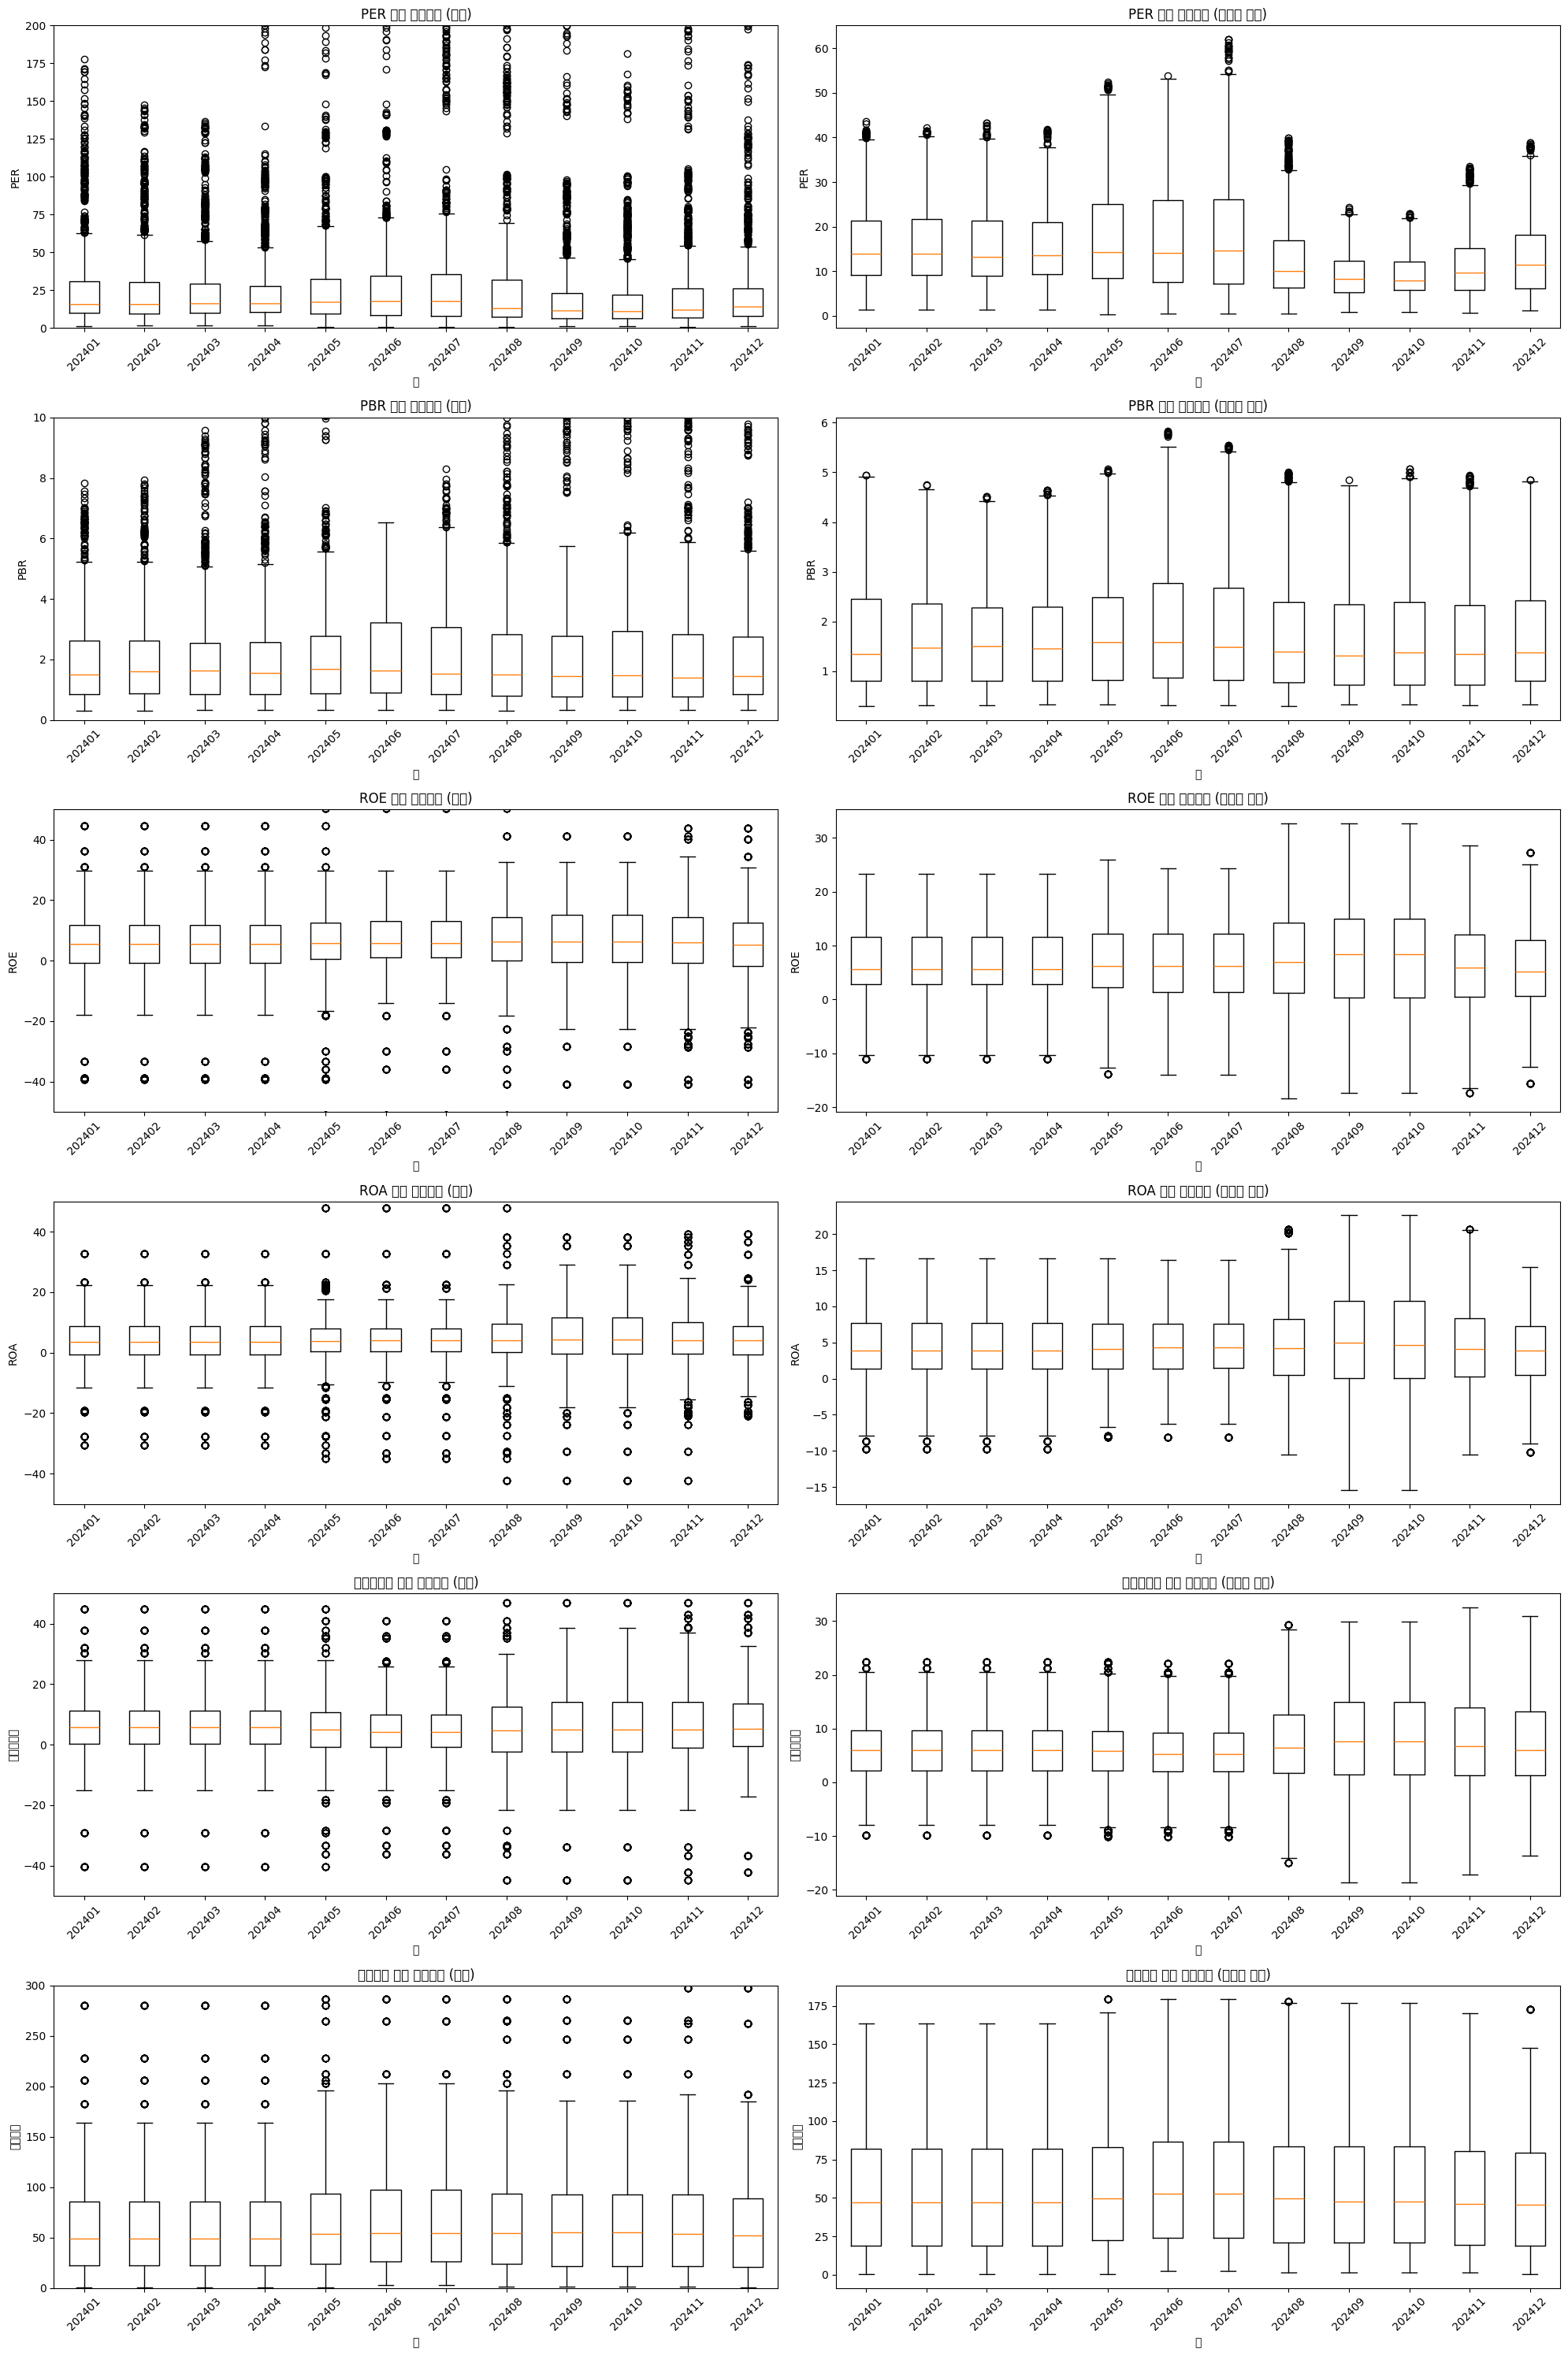


=== Ï†ÑÏ≤¥ ÏßÄÌëú Ïù¥ÏÉÅÏπò Ï†úÍ±∞ ÏöîÏïΩ ===
PER: 2559Í∞ú Ï†úÍ±∞ (13.4%)
PBR: 1430Í∞ú Ï†úÍ±∞ (5.6%)
ROE: 3075Í∞ú Ï†úÍ±∞ (12.0%)
ROA: 2749Í∞ú Ï†úÍ±∞ (10.7%)
ÏòÅÏóÖÏù¥ÏùµÎ•†: 3787Í∞ú Ï†úÍ±∞ (14.8%)
Î∂ÄÏ±ÑÎπÑÏú®: 1463Í∞ú Ï†úÍ±∞ (5.7%)

üéØ Ïù¥ÏÉÅÏπò Ï†úÍ±∞ ÌõÑ Ìà¨Ïûê Íµ¨Í∞Ñ Î∂ÑÏÑù (Îß§Ïàò/Îß§ÎèÑ ÏßÄÏ†ê Ï∞∏Í≥†)
   ÏßÄÌëú  Lower_Bound  Q1_Îß§ÏàòÏ†ÅÍ∑π  Median_Ï†ÅÏ†ï  Mean_ÌèâÍ∑†  Q3_Îß§ÎèÑÍ≤ÄÌÜ†  Upper_Bound  Ï†ïÏ†úÎç∞Ïù¥ÌÑ∞Ïàò
  PER       -14.70     7.35      12.59    16.44    22.05        44.10   16547
  PBR        -1.74     0.79       1.46     1.81     2.48         5.02   24190
  ROE       -15.21     1.42       6.20     6.59    12.51        29.14   22545
  ROA       -10.73     0.68       4.14     4.42     8.28        19.68   22871
ÏòÅÏóÖÏù¥ÏùµÎ•†       -15.09     1.42       6.05     6.47    12.43        28.94   21833
 Î∂ÄÏ±ÑÎπÑÏú®       -72.03    20.91      48.79    57.32    82.88       175.83   24157

üìä Ìà¨Ïûê Íµ¨Í∞Ñ Ìï¥ÏÑù Í∞ÄÏù¥Îìú:
Lower_Bound ~ Q1     : üü¢ Îß§Ïàò Ï†ÅÍ∑π Í≥†Î

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')


def remove_outliers_iqr(data, factor=1.5):
    if len(data) == 0:
        return data
    
    data_array = np.array(data)
    Q1 = np.percentile(data_array, 25)
    Q3 = np.percentile(data_array, 75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    
    filtered_data = [x for x in data_array if lower_bound <= x <= upper_bound]
    return filtered_data

# Î™®Îì† ÏßÄÌëú Î¶¨Ïä§Ìä∏
metrics = ['PER', 'PBR', 'ROE', 'ROA', 'ÏòÅÏóÖÏù¥ÏùµÎ•†', 'Î∂ÄÏ±ÑÎπÑÏú®']

# 7Ìñâ 2Ïó¥ ÏÑúÎ∏åÌîåÎ°Ø ÏÉùÏÑ±
fig, axes = plt.subplots(6, 2, figsize=(20, 30))

for row, metric in enumerate(metrics):
    print(f"Ï≤òÎ¶¨ Ï§ë: {metric}")
    
    # Ìï¥Îãπ ÏßÄÌëú Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú
    metric_data = filter_metric_analysis(analysis_df, metric)
    date_cols = [col for col in metric_data.columns if col.isdigit() and len(col) == 8]
    
    # ÏõîÎ≥Ñ Îç∞Ïù¥ÌÑ∞ ÏàòÏßë (ÏõêÎ≥∏)
    monthly_data_orig = {}
    for date in date_cols:
        month = date[:6]
        if month not in monthly_data_orig:
            monthly_data_orig[month] = []
        data = metric_data[date].dropna().tolist()
        if len(data) > 0:
            monthly_data_orig[month].extend(data)
    
    # ÏõîÎ≥Ñ Îç∞Ïù¥ÌÑ∞ ÏàòÏßë (Ïù¥ÏÉÅÏπò Ï†úÍ±∞)
    monthly_data_clean = {}
    for date in date_cols:
        month = date[:6]
        if month not in monthly_data_clean:
            monthly_data_clean[month] = []
        data = metric_data[date].dropna().tolist()
        if len(data) > 0:
            clean_data = remove_outliers_iqr(data)
            monthly_data_clean[month].extend(clean_data)
    for month in monthly_data_clean:
        if len(monthly_data_clean[month]) > 0:
            monthly_data_clean[month] = remove_outliers_iqr(monthly_data_clean[month])
    
    months = sorted(monthly_data_orig.keys())
    month_data_orig = [monthly_data_orig[month] for month in months]
    month_data_clean = [monthly_data_clean[month] for month in months]
    
    # ÏõêÎ≥∏ Î∞ïÏä§ÌîåÎ°Ø (Ï¢åÏ∏°)
    axes[row, 0].boxplot(month_data_orig, labels=months)
    axes[row, 0].set_title(f'{metric} ÏõîÎ≥Ñ Î∞ïÏä§ÌîåÎ°Ø (ÏõêÎ≥∏)')
    axes[row, 0].set_xlabel('Ïõî')
    axes[row, 0].set_ylabel(metric)
    axes[row, 0].tick_params(axis='x', rotation=45)
    
    # YÏ∂ï Î≤îÏúÑ ÏÑ§Ï†ï (ÏßÄÌëúÎ≥Ñ Ï°∞Ï†ï)
    if metric == 'PER':
        axes[row, 0].set_ylim(0, 200)
    elif metric == 'PBR':
        axes[row, 0].set_ylim(0, 10)
    elif metric in ['ROE', 'ROA']:
        axes[row, 0].set_ylim(-50, 50)
    elif metric == 'ÏòÅÏóÖÏù¥ÏùµÎ•†':
        axes[row, 0].set_ylim(-50, 50)
    elif metric == 'Î∂ÄÏ±ÑÎπÑÏú®':
        axes[row, 0].set_ylim(0, 300)
    
    # Ïù¥ÏÉÅÏπò Ï†úÍ±∞ ÌõÑ Î∞ïÏä§ÌîåÎ°Ø (Ïö∞Ï∏°)
    axes[row, 1].boxplot(month_data_clean, labels=months)
    axes[row, 1].set_title(f'{metric} ÏõîÎ≥Ñ Î∞ïÏä§ÌîåÎ°Ø (Ïù¥ÏÉÅÏπò Ï†úÍ±∞)')
    axes[row, 1].set_xlabel('Ïõî')
    axes[row, 1].set_ylabel(metric)
    axes[row, 1].tick_params(axis='x', rotation=45)
    
    # Ïù¥ÏÉÅÏπò Ï†úÍ±∞ Ìö®Í≥º Ï∂úÎ†•
    print(f"=== {metric} Ïù¥ÏÉÅÏπò Ï†úÍ±∞ Ìö®Í≥º ===")
    total_orig = sum(len(data) for data in month_data_orig)
    total_clean = sum(len(data) for data in month_data_clean)
    total_removed = total_orig - total_clean
    print(f"Ï†ÑÏ≤¥: {total_orig}Í∞ú ‚Üí {total_clean}Í∞ú ({total_removed}Í∞ú Ï†úÍ±∞, {total_removed/total_orig*100:.1f}%)")

plt.tight_layout()
plt.show()

# Ï†ÑÏ≤¥ ÏöîÏïΩ ÌÜµÍ≥Ñ
print("\n=== Ï†ÑÏ≤¥ ÏßÄÌëú Ïù¥ÏÉÅÏπò Ï†úÍ±∞ ÏöîÏïΩ ===")
for metric in metrics:
    metric_data = filter_metric_analysis(analysis_df, metric)
    date_cols = [col for col in metric_data.columns if col.isdigit() and len(col) == 8]
    
    total_orig = 0
    total_clean = 0
    
    for date in date_cols:
        data = metric_data[date].dropna().tolist()
        if len(data) > 0:
            total_orig += len(data)
            clean_data = remove_outliers_iqr(data)
            total_clean += len(clean_data)
    
    removed = total_orig - total_clean
    if total_orig > 0:
        print(f"{metric}: {removed}Í∞ú Ï†úÍ±∞ ({removed/total_orig*100:.1f}%)")

# ============== Ïó¨Í∏∞ÏÑúÎ∂ÄÌÑ∞ Ï∂îÍ∞ÄÎêú Î∂ÄÎ∂Ñ ==============

print("\n" + "="*100)
print("üéØ Ïù¥ÏÉÅÏπò Ï†úÍ±∞ ÌõÑ Ìà¨Ïûê Íµ¨Í∞Ñ Î∂ÑÏÑù (Îß§Ïàò/Îß§ÎèÑ ÏßÄÏ†ê Ï∞∏Í≥†)")
print("="*100)

# Ïù¥ÏÉÅÏπò Ï†úÍ±∞Îêú Îç∞Ïù¥ÌÑ∞Î°ú Ìà¨Ïûê Íµ¨Í∞Ñ Î∂ÑÏÑù
investment_analysis = []

for metric in metrics:
    metric_data = filter_metric_analysis(analysis_df, metric)
    date_cols = [col for col in metric_data.columns if col.isdigit() and len(col) == 8]
    
    # Ïù¥ÏÉÅÏπò Ï†úÍ±∞Îêú Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ ÏàòÏßë
    all_clean_data = []
    for date in date_cols:
        data = metric_data[date].dropna().tolist()
        if len(data) > 0:
            clean_data = remove_outliers_iqr(data)
            all_clean_data.extend(clean_data)
    
    if len(all_clean_data) > 0:
        Q1 = np.percentile(all_clean_data, 25)
        Q3 = np.percentile(all_clean_data, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        median = np.median(all_clean_data)
        mean = np.mean(all_clean_data)
        
        investment_analysis.append({
            'ÏßÄÌëú': metric,
            'Lower_Bound': round(lower_bound, 2),
            'Q1_Îß§ÏàòÏ†ÅÍ∑π': round(Q1, 2),
            'Median_Ï†ÅÏ†ï': round(median, 2),
            'Mean_ÌèâÍ∑†': round(mean, 2),
            'Q3_Îß§ÎèÑÍ≤ÄÌÜ†': round(Q3, 2),
            'Upper_Bound': round(upper_bound, 2),
            'Ï†ïÏ†úÎç∞Ïù¥ÌÑ∞Ïàò': len(all_clean_data)
        })

# Ìà¨Ïûê Íµ¨Í∞Ñ Î∂ÑÏÑù ÌÖåÏù¥Î∏î Ï∂úÎ†•
investment_df = pd.DataFrame(investment_analysis)
print(investment_df.to_string(index=False))

print(f"\nüìä Ìà¨Ïûê Íµ¨Í∞Ñ Ìï¥ÏÑù Í∞ÄÏù¥Îìú:")
print(f"Lower_Bound ~ Q1     : üü¢ Îß§Ïàò Ï†ÅÍ∑π Í≥†Î†§ (Ï†ÄÌèâÍ∞Ä Íµ¨Í∞Ñ)")
print(f"Q1 ~ Median         : üü° Îß§Ïàò Í≤ÄÌÜ† (Ï†ÅÏ†ï ÌïòÎã®)")  
print(f"Median ~ Mean       : üü† Î≥¥Ïú†/Í¥ÄÎßù (Ï†ÅÏ†ï Ï§ëÍ∞Ñ)")
print(f"Mean ~ Q3           : üî¥ Îß§ÎèÑ Í≤ÄÌÜ† (Ï†ÅÏ†ï ÏÉÅÎã®)")
print(f"Q3 ~ Upper_Bound    : üî¥ Îß§ÎèÑ Ï†ÅÍ∑π Í≥†Î†§ (Í≥†ÌèâÍ∞Ä Íµ¨Í∞Ñ)")
print(f"Upper_Bound Ï¥àÍ≥º    : ‚õî Ìà¨Ïûê Í∏àÏßÄ (Í∑πÎèÑ Í≥†ÌèâÍ∞Ä)")

# Ïã§Ï†Ñ Ìà¨Ïûê ÌôúÏö© ÏòàÏãú
print(f"\nüí° Ïã§Ï†Ñ ÌôúÏö© ÏòàÏãú:")
for _, row in investment_df.iterrows():
    metric = row['ÏßÄÌëú']
    if metric == 'PER':
        print(f"üìà {metric}: {row['Q1_Îß§ÏàòÏ†ÅÍ∑π']}Î∞∞ Ïù¥Ìïò Îß§Ïàò, {row['Q3_Îß§ÎèÑÍ≤ÄÌÜ†']}Î∞∞ Ïù¥ÏÉÅ Îß§ÎèÑ")
    elif metric == 'PBR':
        print(f"üìä {metric}: {row['Q1_Îß§ÏàòÏ†ÅÍ∑π']}Î∞∞ Ïù¥Ìïò Îß§Ïàò, {row['Q3_Îß§ÎèÑÍ≤ÄÌÜ†']}Î∞∞ Ïù¥ÏÉÅ Îß§ÎèÑ")
    elif metric == 'ROE':
        print(f"üí∞ {metric}: {row['Q1_Îß§ÏàòÏ†ÅÍ∑π']}% Ïù¥ÏÉÅ ÏÑ†Ìò∏, {row['Median_Ï†ÅÏ†ï']}% Ï†ÅÏ†ï")

In [385]:
investment_df

ÏßÄÌëú  Lower_Bound  Q1_Îß§ÏàòÏ†ÅÍ∑π  Median_Ï†ÅÏ†ï  Mean_ÌèâÍ∑†  Q3_Îß§ÎèÑÍ≤ÄÌÜ†  Upper_Bound  \
0    PER       -19.80    10.31      17.32    23.32    30.38        60.48   
1    PBR        -1.82     0.81       1.50     1.88     2.56         5.18   
2    ROE       -12.64     0.99       4.84     5.19    10.07        23.69   
3    ROA        -8.55     0.46       3.09     3.46     6.47        15.48   
4  ÏòÅÏóÖÏù¥ÏùµÎ•†       -15.09     1.42       6.05     6.47    12.43        28.94   
5   Î∂ÄÏ±ÑÎπÑÏú®       -72.03    20.91      48.79    57.32    82.88       175.83   

   Ï†ïÏ†úÎç∞Ïù¥ÌÑ∞Ïàò  
0   16605  
1   23956  
2   22545  
3   22927  
4   21833  
5   24157

## 4. Î∞±ÌÖåÏä§Ìä∏ ÏßÑÌñâ

In [20]:
backtest_df = merged_df.filter(
  items=['ÏãúÏû•Íµ¨Î∂Ñ_current', 'Ï¢ÖÎ™©Î™Ö', 'Ï¢ÖÎ™©ÏΩîÎìú_current', 'ÏÜåÏÜçÎ∂Ä_current', 'ÏãúÏ¥ùÏ¶ùÍ∞êÎ•†', 'Ïó∞Í∞ÑÏàòÏùµÎ•†', 'ÏÉÅÏû•Ï£ºÏãùÏàò_current']
  ).rename(columns={
    'ÏãúÏû•Íµ¨Î∂Ñ_current': 'ÏãúÏû•Íµ¨Î∂Ñ',
    'Ï¢ÖÎ™©ÏΩîÎìú_current': 'Ï¢ÖÎ™©ÏΩîÎìú',
    'ÏÜåÏÜçÎ∂Ä_current': 'ÏÜåÏÜçÎ∂Ä',
    'ÏãúÏ¥ùÏ¶ùÍ∞êÎ•†': 'ÏãúÏ¥ù_Ï¶ùÍ∞êÎ•†',
    'Ïó∞Í∞ÑÏàòÏùµÎ•†': 'Ï£ºÍ∞Ä_ÏàòÏùµÎ•†',
    'ÏÉÅÏû•Ï£ºÏãùÏàò_current': 'ÏÉÅÏû•Ï£ºÏãùÏàò'
})

In [23]:
backtest_df_corpcode = pd.merge(backtest_df, 
                  analysis_df[['Í≥†Ïú†Î≤àÌò∏', 'Ï¢ÖÎ™©ÏΩîÎìú']],
                  on='Ï¢ÖÎ™©ÏΩîÎìú',
                  how='left')

In [ ]:
def create_session_with_retry():
    """Ïû¨ÏãúÎèÑ Î°úÏßÅÏù¥ Ìè¨Ìï®Îêú ÏÑ∏ÏÖò ÏÉùÏÑ±"""
    session = requests.Session()
    retry_strategy = Retry(
        total=3,  # ÏµúÎåÄ 3Î≤à Ïû¨ÏãúÎèÑ
        backoff_factor=1,  # Ïû¨ÏãúÎèÑ Í∞ÑÍ≤©
        status_forcelist=[429, 500, 502, 503, 504],  # Ïû¨ÏãúÎèÑÌï† ÏÉÅÌÉúÏΩîÎìú
    )
    adapter = HTTPAdapter(max_retries=retry_strategy)
    session.mount("http://", adapter)
    session.mount("https://", adapter)
    return session

def background_task(corp_code, corp_name, max_retries=3):
    """Ïû¨ÏãúÎèÑ Î°úÏßÅÏù¥ Ìè¨Ìï®Îêú ÏûëÏóÖ Ìï®Ïàò"""
    for attempt in range(max_retries):
        try:
            time.sleep(0.5)  # ÏöîÏ≤≠ Í∞Ñ ÎåÄÍ∏∞ÏãúÍ∞Ñ Ï¶ùÍ∞Ä
            data = get_corp_quarter_data(corp_code, "2024")
            return corp_name, data
        except (requests.exceptions.ConnectionError, 
                requests.exceptions.Timeout,
                Exception) as e:
            if attempt < max_retries - 1:
                wait_time = (2 ** attempt) * 0.5  # ÏßÄÏàò Î∞±Ïò§ÌîÑ
                print(f"Ïû¨ÏãúÎèÑ {attempt + 1}/{max_retries} for {corp_name}, ÎåÄÍ∏∞: {wait_time}Ï¥à")
                print(e)
                time.sleep(wait_time)
            else:
                print(f"ÏµúÏ¢Ö Ïã§Ìå®: {corp_name} - {str(e)}")
                return corp_name, None
with ThreadPoolExecutor(max_workers=2) as executor:
    futures = [
        executor.submit(background_task, row['Í≥†Ïú†Î≤àÌò∏'], row['Ï¢ÖÎ™©Î™Ö']) 
        for _, row in backtest_df_corpcode.iterrows()
    ]
    
    results = []
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing"):
        results.append(future.result())

# NoneÏù¥ ÏïÑÎãå Í≤∞Í≥ºÎßå ÌïÑÌÑ∞ÎßÅ
backtest_result_dict = {name: df for name, df in results if df is not None}

In [35]:
def check_accounts_for_zero(df, accounts_to_check):
    """Í≥ÑÏ†ïÍ≥ºÎ™©ÏóêÏÑú 0Ïù¥ ÏûàÎäîÏßÄ ÌôïÏù∏"""
    quarterly_cols = ['2023_4Q', '2024_1Q', '2024_2Q', '2024_3Q', '2024_4Q']
    
    for account in accounts_to_check:
        account_row = df[df['Í≥ÑÏ†ïÍ≥ºÎ™©'] == account]
        if not account_row.empty:
            for col in quarterly_cols:
                if col in account_row.columns:
                    if (account_row[col] == 0).any():
                        return True
    return False

columns_to_check = ['ÎãπÍ∏∞ÏàúÏù¥Ïùµ', 'ÏûêÏÇ∞Ï¥ùÍ≥Ñ', 'ÏûêÎ≥∏Ï¥ùÍ≥Ñ', 'Î∂ÄÏ±ÑÏ¥ùÍ≥Ñ','Îß§Ï∂úÏï°','ÏòÅÏóÖÏù¥Ïùµ']

zero_stocks = []
for corp_name, df in backtest_result_dict.items():
    if df is not None and not df.empty:
        if check_accounts_for_zero(df, columns_to_check):
            zero_stocks.append(corp_name)

print(f" 0Ïù¥ Ìè¨Ìï®Îêú Ï¢ÖÎ™© Ïàò {len(zero_stocks)} ,0Ïù¥ Ìè¨Ìï®Îêú Ï¢ÖÎ™©: {zero_stocks}, ")

backtest_filtered_dict = {
    corp_name: df for corp_name, df in backtest_result_dict.items()
    if df is not None and not df.empty and 
    not check_accounts_for_zero(df, columns_to_check)
}

backtest_remaining_stocks = list(backtest_filtered_dict.keys())

# final_summaryÏóêÏÑú Ìï¥Îãπ Ï¢ÖÎ™©Îì§Îßå ÌïÑÌÑ∞ÎßÅ
backtest_filtered_final_summary = backtest_df_corpcode[backtest_df_corpcode['Ï¢ÖÎ™©Î™Ö'].isin(backtest_remaining_stocks)]

print(f"ÏõêÎûò final_summary Ï¢ÖÎ™© Ïàò: {len(backtest_df_corpcode)}")
print(f"ÌïÑÌÑ∞ÎßÅ ÌõÑ Ï¢ÖÎ™© Ïàò: {len(backtest_filtered_final_summary)}")
print(f"Ï†úÍ±∞Îêú Ï¢ÖÎ™© Ïàò: {len(backtest_df_corpcode) - len(backtest_filtered_final_summary)}")



 0Ïù¥ Ìè¨Ìï®Îêú Ï¢ÖÎ™© Ïàò 92 ,0Ïù¥ Ìè¨Ìï®Îêú Ï¢ÖÎ™©: ['ÎçïÏÑ±', 'ÏßÄÏï§ÎπÑÏóêÏä§ ÏóêÏΩî', 'Ï°∞Ïù¥ÏãúÌã∞', 'ÏÖÄÎ¶¨Îìú', 'ÏΩîÏïÑÏãúÏïÑ', 'Í∞ïÏä§ÌÖúÎ∞îÏù¥Ïò§ÌÖç', 'ÏÉ§ÌéòÎ°†', 'ÌåúÏä§ÌÜ†Î¶¨', 'ÏºÑÏΩîÏïÑÏóêÏñ¥Î°úÏä§ÌéòÏù¥Ïä§', 'ÏΩîÏïÑÏä§ÌÖúÏºêÏò®', 'LKÏÇºÏñë', 'ÌÉúÎ¶ºÌè¨Ïû•', 'HLBÏ†úÎÑ•Ïä§', 'ÏÇºÏÑ±Ï†úÏïΩ', 'ÏóëÏãúÏΩò', 'Ïª®ÌÖç', 'Ìã∞ÏºÄÏù¥ÏºÄÎØ∏Ïπº', 'Î©îÎìúÌå©ÌÜ†', 'ÏïÑÌã∞Ïä§Ìä∏Ïú†ÎÇòÏù¥Ìã∞Îìú', 'KEC', 'Ìè¨ÎãàÎßÅÌÅ¨', 'ÏïåÎ©ï', 'ÌïúÍµ≠Ï∫êÌîºÌÉà', 'ÏõÖÏßÑÏîΩÌÅ¨ÎπÖ', 'ÌïúÍµ≠Ï†ïÎ≥¥Ïù∏Ï¶ù', 'Í∏ÄÎ°úÎ≤åÌÖçÏä§ÌîÑÎ¶¨', 'ÌïúÌôîÍ∞§Îü¨Î¶¨ÏïÑ', 'Ìù•Íµ≠ÌôîÏû¨', 'Ïù¥ÏõîÎìú', 'ÏóêÎ∏åÎ¶¨Î¥á', 'SKÏ¶ùÍ∂å', 'ÏΩîÎ¶¨ÏïÑÏç®ÌÇ§Ìä∏', 'Î∏åÎ¶øÏßÄÎ∞îÏù¥Ïò§ÌÖåÎùºÌì®Ìã±Ïä§', 'ÏóêÏù¥ÌîÑÎ°úÏ††', 'ÌôîÏã†', 'ÏóêÏπòÏóêÌîÑÏïå', 'ÎèôÍµ≠ÏÇ∞ÏóÖ', 'ÎßàÎÖÄÍ≥µÏû•', 'ÎØ∏ÎûòÏóêÏÖãÎ≤§Ï≤òÌà¨Ïûê', 'Ï†úÏ£ºÏùÄÌñâ', 'ÌïòÏù¥ÎπÑÏ†ºÏãúÏä§ÌÖú', 'ÏóêÏñ¥Î∂ÄÏÇ∞', 'ÏÜîÌä∏Î£©Ïä§', 'Ïù∏Ïπ¥Í∏àÏúµÏÑúÎπÑÏä§', 'ÏïÑÏÑ∏ÏïÑÏ†úÏßÄ', 'ÏÑ∏Í≤ΩÌïòÏù¥ÌÖåÌÅ¨', 'Î∂ÄÍ¥ëÏïΩÌíà', 'Ïï†Í≤ΩÏÇ∞ÏóÖ', 'Ïã†ÎùºÏ††', 'ÏºÄÏù¥Ïó†ÎçîÎ∏îÏú†', 'ÏÜåÎ£©Ïä§', 'ÏóêÏù¥ÌîÑÎ¶¥Î∞îÏù¥

In [39]:
backtest_sample = pd.merge(backtest_filtered_final_summary, all_data, on=['Ï¢ÖÎ™©ÏΩîÎìú', 'Ï¢ÖÎ™©Î™Ö'], how='inner')
backtest_analysis_df = create_company_analysis_dataframe(backtest_sample, backtest_filtered_dict)
backtest_analysis_df

Í∏∞ÏóÖÎ≥Ñ Î∂ÑÏÑù Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 374/374 [00:42<00:00,  8.81it/s]


Ï¢ÖÎ™©Î™Ö     Íµ¨Î∂Ñ     20240102     20240103     20240104     20240105  \
0     Ï†úÏù¥Ïä§ÏΩîÌôÄÎî©Ïä§     Ï¢ÖÍ∞Ä  1430.000000  1477.000000  1408.000000  1401.000000   
1     Ï†úÏù¥Ïä§ÏΩîÌôÄÎî©Ïä§    PER          NaN          NaN          NaN          NaN   
2     Ï†úÏù¥Ïä§ÏΩîÌôÄÎî©Ïä§    PBR     1.400996     1.447042     1.379442     1.372584   
3     Ï†úÏù¥Ïä§ÏΩîÌôÄÎî©Ïä§    ROE   -38.864932   -38.864932   -38.864932   -38.864932   
4     Ï†úÏù¥Ïä§ÏΩîÌôÄÎî©Ïä§    ROA   -19.087926   -19.087926   -19.087926   -19.087926   
...       ...    ...          ...          ...          ...          ...   
2613    DBÌïòÏù¥ÌÖç    PBR     1.408008     1.348913     1.336066     1.330928   
2614    DBÌïòÏù¥ÌÖç    ROE    14.767488    14.767488    14.767488    14.767488   
2615    DBÌïòÏù¥ÌÖç    ROA    12.771267    12.771267    12.771267    12.771267   
2616    DBÌïòÏù¥ÌÖç  ÏòÅÏóÖÏù¥ÏùµÎ•†    24.258087    24.258087    24.258087    24.258087   
2617    DBÌïòÏù¥ÌÖç   Î∂ÄÏ±ÑÎπÑÏú®    15.630571    15.630571    15.630571    15.630571   

         20240108     20240109     20240110     20240111  ...     20241216  \
0     1414.000000  1425.000000  1460.000000  1469.000000  ...  1854.000000   
1             NaN          NaN          NaN          NaN  ...          NaN   
2        1.385320     1.396097     1.430387     1.439205  ...     1.777508   
3      -38.864932   -38.864932   -38.864932   -38.864932  ...   -13.082513   
4      -19.087926   -19.087926   -19.087926   -19.087926  ...    -6.709918   
...           ...          ...          ...          ...  ...          ...   
2613     1.318081     1.333497     1.356621     1.356621  ...     0.818124   
2614    14.767488    14.767488    14.767488    14.767488  ...     3.324123   
2615    12.771267    12.771267    12.771267    12.771267  ...     2.930445   
2616    24.258087    24.258087    24.258087    24.258087  ...    17.773675   
2617    15.630571    15.630571    15.630571    15.630571  ...    13.434094   

         20241217     20241218     20241219     20241220     20241223  \
0     1871.000000  1825.000000  1847.000000  1744.000000  1725.000000   
1             NaN          NaN          NaN          NaN          NaN   
2        1.793806     1.749704     1.770796     1.672046     1.653830   
3      -13.082513   -13.082513   -13.082513   -13.082513   -13.082513   
4       -6.709918    -6.709918    -6.709918    -6.709918    -6.709918   
...           ...          ...          ...          ...          ...   
2613     0.845755     0.834943     0.820527     0.797701     0.807312   
2614     3.324123     3.324123     3.324123     3.324123     3.324123   
2615     2.930445     2.930445     2.930445     2.930445     2.930445   
2616    17.773675    17.773675    17.773675    17.773675    17.773675   
2617    13.434094    13.434094    13.434094    13.434094    13.434094   

         20241224     20241226     20241227     20241230  
0     1739.000000  1702.000000  1626.000000  1693.000000  
1             NaN          NaN          NaN          NaN  
2        1.667252     1.631779     1.558914     1.623150  
3      -13.082513   -13.082513   -13.082513   -13.082513  
4       -6.709918    -6.709918    -6.709918    -6.709918  
...           ...          ...          ...          ...  
2613     0.815721     0.794097     0.761660     0.796499  
2614     3.324123     3.324123     3.324123     3.324123  
2615     2.930445     2.930445     2.930445     2.930445  
2616    17.773675    17.773675    17.773675    17.773675  
2617    13.434094    13.434094    13.434094    13.434094  

[2618 rows x 246 columns]

In [ ]:
def get_rebalancing_dates(df):
    # ÎÇ†Ïßú Ïª¨ÎüºÎì§ Ï∂îÏ∂ú (YYYYMMDD ÌòïÌÉú)
    date_cols = [col for col in df.columns if col.isdigit() and len(col) == 8]
    date_cols.sort()
    
    # ÏõîÎ≥Ñ ÎßàÏßÄÎßâ Í±∞ÎûòÏùº Ï∞æÍ∏∞
    monthly_dates = {}
    for date in date_cols:
        month = date[:6]  # YYYYMM
        monthly_dates[month] = date  # ÎçÆÏñ¥Ïì∞Î©¥ÏÑú ÎßàÏßÄÎßâ ÎÇ†ÏßúÍ∞Ä Ï†ÄÏû•Îê®
    
    # Î¶¨Î∞∏Îü∞Ïã± ÎÇ†Ïßú Î¶¨Ïä§Ìä∏
    rebalancing_dates = list(monthly_dates.values())
    
    print(f"üìÖ ÏõîÎ≥Ñ Î¶¨Î∞∏Îü∞Ïã± ÎÇ†Ïßú ({len(rebalancing_dates)}Í∞úÏõî):")
    for i, date in enumerate(rebalancing_dates, 1):
        month_name = f"{date[4:6]}Ïõî"
        print(f"   {i:2d}. {month_name}: {date}")
    
    return rebalancing_dates

# ÌÖåÏä§Ìä∏ Ïã§Ìñâ
rebalancing_dates = get_rebalancing_dates(analysis_df)

üìÖ ÏõîÎ≥Ñ Î¶¨Î∞∏Îü∞Ïã± ÎÇ†Ïßú (12Í∞úÏõî):
    1. 01Ïõî: 20240131
    2. 02Ïõî: 20240229
    3. 03Ïõî: 20240329
    4. 04Ïõî: 20240430
    5. 05Ïõî: 20240531
    6. 06Ïõî: 20240628
    7. 07Ïõî: 20240731
    8. 08Ïõî: 20240830
    9. 09Ïõî: 20240930
   10. 10Ïõî: 20241031
   11. 11Ïõî: 20241129
   12. 12Ïõî: 20241230


In [ ]:
def get_fundamentals_at_date(df, target_date, metrics=['PER', 'PBR', 'ROE', 'ROA', 'ÏòÅÏóÖÏù¥ÏùµÎ•†', 'Î∂ÄÏ±ÑÎπÑÏú®']):
    # Ìï¥Îãπ ÎÇ†ÏßúÍ∞Ä Îç∞Ïù¥ÌÑ∞Ïóê ÏûàÎäîÏßÄ ÌôïÏù∏
    if target_date not in df.columns:
        # Í∞ÄÏû• Í∞ÄÍπåÏö¥ Ïù¥Ï†Ñ ÎÇ†Ïßú Ï∞æÍ∏∞
        available_dates = [col for col in df.columns if col.isdigit() and col <= target_date]
        if not available_dates:
            print(f"‚ùå {target_date} Ïù¥Ï†Ñ Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§.")
            return pd.DataFrame()
        target_date = max(available_dates)
        print(f"üìÖ {target_date} Îç∞Ïù¥ÌÑ∞ ÏÇ¨Ïö©")
    
    fundamentals = {}
    
    for metric in metrics:
        # Ìï¥Îãπ Íµ¨Î∂ÑÏùò Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú
        metric_data = df[df['Íµ¨Î∂Ñ'] == metric]
        
        if not metric_data.empty:
            # Ï¢ÖÎ™©Î™ÖÏùÑ ÌÇ§Î°ú, Ìï¥Îãπ ÎÇ†Ïßú Í∞íÏùÑ Î∞∏Î•òÎ°ú ÌïòÎäî ÎîïÏÖîÎÑàÎ¶¨
            metric_values = metric_data.set_index('Ï¢ÖÎ™©Î™Ö')[target_date].to_dict()
            fundamentals[metric] = metric_values
    
    # DataFrameÏúºÎ°ú Î≥ÄÌôò
    fund_df = pd.DataFrame(fundamentals)
    
    # Í≤∞Ï∏°ÏπòÍ∞Ä ÎÑàÎ¨¥ ÎßéÏùÄ Ï¢ÖÎ™© Ï†úÏô∏ (ÏµúÏÜå Ï†àÎ∞ò Ïù¥ÏÉÅ Îç∞Ïù¥ÌÑ∞ ÏûàÏñ¥Ïïº Ìï®)
    min_data_count = len(metrics) // 2
    fund_df = fund_df.dropna(thresh=min_data_count)
    
    print(f"üìä {target_date} Ïû¨Î¨¥ÏßÄÌëú Ï∂îÏ∂ú ÏôÑÎ£å:")
    print(f"   ÎåÄÏÉÅ Ï¢ÖÎ™©: {len(fund_df)}Í∞ú")
    print(f"   Ï∂îÏ∂ú ÏßÄÌëú: {list(fund_df.columns)}")
    
    # Í∞ÑÎã®Ìïú ÌÜµÍ≥Ñ Ï∂úÎ†•
    for metric in fund_df.columns:
        valid_count = fund_df[metric].notna().sum()
        print(f"   {metric}: {valid_count}Í∞ú Ï¢ÖÎ™© Îç∞Ïù¥ÌÑ∞ Î≥¥Ïú†")
    
    return fund_df

# ÌÖåÏä§Ìä∏ Ïã§Ìñâ
test_fundamentals = get_fundamentals_at_date(analysis_df, '20240131')
print(f"\nÏÉòÌîå Îç∞Ïù¥ÌÑ∞:")
print(test_fundamentals.head())

üìä 20240131 Ïû¨Î¨¥ÏßÄÌëú Ï∂îÏ∂ú ÏôÑÎ£å:
   ÎåÄÏÉÅ Ï¢ÖÎ™©: 361Í∞ú
   Ï∂îÏ∂ú ÏßÄÌëú: ['PER', 'PBR', 'ROE', 'ROA', 'ÏòÅÏóÖÏù¥ÏùµÎ•†', 'Î∂ÄÏ±ÑÎπÑÏú®']
   PER: 246Í∞ú Ï¢ÖÎ™© Îç∞Ïù¥ÌÑ∞ Î≥¥Ïú†
   PBR: 361Í∞ú Ï¢ÖÎ™© Îç∞Ïù¥ÌÑ∞ Î≥¥Ïú†
   ROE: 361Í∞ú Ï¢ÖÎ™© Îç∞Ïù¥ÌÑ∞ Î≥¥Ïú†
   ROA: 361Í∞ú Ï¢ÖÎ™© Îç∞Ïù¥ÌÑ∞ Î≥¥Ïú†
   ÏòÅÏóÖÏù¥ÏùµÎ•†: 361Í∞ú Ï¢ÖÎ™© Îç∞Ïù¥ÌÑ∞ Î≥¥Ïú†
   Î∂ÄÏ±ÑÎπÑÏú®: 361Í∞ú Ï¢ÖÎ™© Îç∞Ïù¥ÌÑ∞ Î≥¥Ïú†

ÏÉòÌîå Îç∞Ïù¥ÌÑ∞:
                PER       PBR        ROE        ROA       ÏòÅÏóÖÏù¥ÏùµÎ•†        Î∂ÄÏ±ÑÎπÑÏú®
Ï†úÏù¥Ïä§ÏΩîÌôÄÎî©Ïä§         NaN  1.256977 -38.864932 -19.087926  -15.078510  103.610031
ÌÄÄÌÉÄÎß§Ìä∏Î¶≠Ïä§          NaN  2.431799 -61.125367 -54.429416 -621.977175   12.302081
ÏÇºÏùµÏïÖÍ∏∞      21.806563  0.481821   2.209523   1.421021    7.154776   55.488374
ÏÉåÏ¶àÎû©      396.224658  4.279610   1.080097   0.946301   -7.538690   14.138823
ÌôîÏùºÏïΩÌíà      39.471867  0.874097   2.214480   2.076995    1.670788    6.619433


In [ ]:
def screen_stocks_monthly(fund_df, screening_criteria=None):
    if screening_criteria is None:
        # Ïù¥Ï†ÑÏóê ÏÑ§Ï†ïÌïú Ïù¥ÏÉÅÏπò Ï†úÍ±∞Îêú Í∏∞Ï§Ä ÏÇ¨Ïö©
        screening_criteria = {
            'PER': (10.31, 60.48),        # Q1 ~ Upper_Bound
            'PBR': (0.81, 5.18),         # Q1 ~ Upper_Bound  
            'ROE': (0.99, 23.69),        # Q1 ~ Upper_Bound (ÏñëÏàò ÏàòÏùµÏÑ±)
            'ROA': (0.46, 15.48),        # Q1 ~ Upper_Bound (ÏñëÏàò ÏàòÏùµÏÑ±)
            'ÏòÅÏóÖÏù¥ÏùµÎ•†': (1.42, 28.94),   # Q1 ~ Upper_Bound (ÏñëÏàò ÎßàÏßÑ)
            'Î∂ÄÏ±ÑÎπÑÏú®': (0, 175.83)       # 0 ~ Upper_Bound (Í±¥Ï†ÑÏÑ±)
        }
    
    print(f"üéØ Ï¢ÖÎ™© Ïä§ÌÅ¨Î¶¨Îãù ÏãúÏûë (Ï¥ù {len(fund_df)}Í∞ú Ï¢ÖÎ™©)")
    print(f"üìã Ïä§ÌÅ¨Î¶¨Îãù Í∏∞Ï§Ä:")
    for metric, (min_val, max_val) in screening_criteria.items():
        print(f"   {metric}: {min_val:.2f} ~ {max_val:.2f}")
    
    selected_stocks = []
    screening_results = {}
    
    for stock in fund_df.index:
        passed = True
        stock_results = {}
        
        for metric, (min_val, max_val) in screening_criteria.items():
            if metric not in fund_df.columns:
                continue
                
            value = fund_df.loc[stock, metric]
            
            # Í≤∞Ï∏°Ïπò Ï≤¥ÌÅ¨
            if pd.isna(value):
                passed = False
                stock_results[metric] = f"Í≤∞Ï∏°Ïπò"
                break
            
            # Í∏∞Ï§Ä Ï≤¥ÌÅ¨
            if value < min_val or value > max_val:
                passed = False
                stock_results[metric] = f"{value:.2f} (Î≤îÏúÑÏ¥àÍ≥º)"
                break
            else:
                stock_results[metric] = f"{value:.2f} (ÌÜµÍ≥º)"
        
        screening_results[stock] = {
            'passed': passed,
            'details': stock_results
        }
        
        if passed:
            selected_stocks.append(stock)
    
    # Í≤∞Í≥º Ï∂úÎ†•
    print(f"\n‚úÖ Ïä§ÌÅ¨Î¶¨Îãù Í≤∞Í≥º:")
    print(f"   ÌÜµÍ≥º Ï¢ÖÎ™©: {len(selected_stocks)}Í∞ú")
    print(f"   ÌÉàÎùΩ Ï¢ÖÎ™©: {len(fund_df) - len(selected_stocks)}Í∞ú")
    print(f"   ÌÜµÍ≥ºÏú®: {len(selected_stocks)/len(fund_df)*100:.1f}%")
    
    # ÌÜµÍ≥º Ï¢ÖÎ™© ÏÉÅÏúÑ 5Í∞ú Ï∂úÎ†•
    if len(selected_stocks) > 0:
        print(f"\nüìà ÌÜµÍ≥º Ï¢ÖÎ™© ÏòàÏãú (ÏÉÅÏúÑ 5Í∞ú):")
        for i, stock in enumerate(selected_stocks[:5], 1):
            print(f"   {i}. {stock}")
            for metric in ['PER', 'PBR', 'ROE']:
                if metric in fund_df.columns:
                    value = fund_df.loc[stock, metric]
                    print(f"      {metric}: {value:.2f}")
    
    # Ï£ºÏöî ÌÉàÎùΩ ÏÇ¨Ïú† Î∂ÑÏÑù
    rejection_reasons = {}
    for stock, result in screening_results.items():
        if not result['passed']:
            for metric, detail in result['details'].items():
                if 'Î≤îÏúÑÏ¥àÍ≥º' in detail or 'Í≤∞Ï∏°Ïπò' in detail:
                    if metric not in rejection_reasons:
                        rejection_reasons[metric] = 0
                    rejection_reasons[metric] += 1
                    break  # Ï≤´ Î≤àÏß∏ ÌÉàÎùΩ ÏÇ¨Ïú†Îßå Ïπ¥Ïö¥Ìä∏
    
    if rejection_reasons:
        print(f"\nüìä Ï£ºÏöî ÌÉàÎùΩ ÏÇ¨Ïú†:")
        for metric, count in sorted(rejection_reasons.items(), key=lambda x: x[1], reverse=True):
            print(f"   {metric}: {count}Í∞ú Ï¢ÖÎ™©")
    
    return selected_stocks

# ÌÖåÏä§Ìä∏ Ïã§Ìñâ
if 'test_fundamentals' in locals() and not test_fundamentals.empty:
    selected_stocks = screen_stocks_monthly(test_fundamentals)
else:
    print("Î®ºÏ†Ä get_fundamentals_at_date() Ìï®ÏàòÎ•º Ïã§ÌñâÌï¥Ï£ºÏÑ∏Ïöî.")

üéØ Ï¢ÖÎ™© Ïä§ÌÅ¨Î¶¨Îãù ÏãúÏûë (Ï¥ù 361Í∞ú Ï¢ÖÎ™©)
üìã Ïä§ÌÅ¨Î¶¨Îãù Í∏∞Ï§Ä:
   PER: 10.31 ~ 60.48
   PBR: 0.81 ~ 5.18
   ROE: 0.99 ~ 23.69
   ROA: 0.46 ~ 15.48
   ÏòÅÏóÖÏù¥ÏùµÎ•†: 1.42 ~ 28.94
   Î∂ÄÏ±ÑÎπÑÏú®: 0.00 ~ 175.83

‚úÖ Ïä§ÌÅ¨Î¶¨Îãù Í≤∞Í≥º:
   ÌÜµÍ≥º Ï¢ÖÎ™©: 96Í∞ú
   ÌÉàÎùΩ Ï¢ÖÎ™©: 265Í∞ú
   ÌÜµÍ≥ºÏú®: 26.6%

üìà ÌÜµÍ≥º Ï¢ÖÎ™© ÏòàÏãú (ÏÉÅÏúÑ 5Í∞ú):
   1. ÌôîÏùºÏïΩÌíà
      PER: 39.47
      PBR: 0.87
      ROE: 2.21
   2. ÎåÄÏõêÎØ∏ÎîîÏñ¥
      PER: 28.84
      PBR: 1.95
      ROE: 6.77
   3. CJÏî®Ìë∏Îìú
      PER: 23.37
      PBR: 1.29
      ROE: 5.51
   4. ÏÖÄÎ∞îÏä§Ìó¨Ïä§ÏºÄÏñ¥
      PER: 32.81
      PBR: 2.64
      ROE: 8.04
   5. ÏóêÏù¥ÌÖçÎ™®ÎπåÎ¶¨Ìã∞
      PER: 32.94
      PBR: 1.73
      ROE: 5.24

üìä Ï£ºÏöî ÌÉàÎùΩ ÏÇ¨Ïú†:
   PER: 205Í∞ú Ï¢ÖÎ™©
   PBR: 28Í∞ú Ï¢ÖÎ™©
   ÏòÅÏóÖÏù¥ÏùµÎ•†: 22Í∞ú Ï¢ÖÎ™©
   Î∂ÄÏ±ÑÎπÑÏú®: 6Í∞ú Ï¢ÖÎ™©
   ROE: 3Í∞ú Ï¢ÖÎ™©
   ROA: 1Í∞ú Ï¢ÖÎ™©


In [ ]:
def calculate_factor_scores_and_portfolio(fund_df, selected_stocks, top_n=20):
    if len(selected_stocks) == 0:
        print("‚ùå Ïä§ÌÅ¨Î¶¨Îãù ÌÜµÍ≥º Ï¢ÖÎ™©Ïù¥ ÏóÜÏäµÎãàÎã§.")
        return pd.DataFrame()
    
    print(f"üèÜ Ìå©ÌÑ∞ Ïä§ÏΩîÏñ¥ Í≥ÑÏÇ∞ ÏãúÏûë ({len(selected_stocks)}Í∞ú Ï¢ÖÎ™©)")
    
    scores = []
    
    for stock in selected_stocks:
        try:
            # Ïû¨Î¨¥ÏßÄÌëú Ï∂îÏ∂ú
            per = fund_df.loc[stock, 'PER'] if 'PER' in fund_df.columns else np.nan
            pbr = fund_df.loc[stock, 'PBR'] if 'PBR' in fund_df.columns else np.nan
            roe = fund_df.loc[stock, 'ROE'] if 'ROE' in fund_df.columns else np.nan
            roa = fund_df.loc[stock, 'ROA'] if 'ROA' in fund_df.columns else np.nan
            profit_margin = fund_df.loc[stock, 'ÏòÅÏóÖÏù¥ÏùµÎ•†'] if 'ÏòÅÏóÖÏù¥ÏùµÎ•†' in fund_df.columns else np.nan
            
            # Í≤∞Ï∏°Ïπò Ï≤¥ÌÅ¨
            if pd.isna(per) or pd.isna(pbr) or pd.isna(roe):
                continue
            
            # Ìå©ÌÑ∞ Ïä§ÏΩîÏñ¥ Í≥ÑÏÇ∞
            # Value Score (ÎÇÆÏùÑÏàòÎ°ù Ï¢ãÏùå ‚Üí Ïó≠Ïàò ÏÇ¨Ïö©)
            value_score = (1/per + 1/pbr) * 50  # Ïä§ÏºÄÏùºÎßÅ
            
            # Quality Score (ÎÜíÏùÑÏàòÎ°ù Ï¢ãÏùå)
            quality_components = [roe, roa, profit_margin]
            quality_values = [x for x in quality_components if pd.notna(x)]
            quality_score = np.mean(quality_values) if quality_values else 0
            
            # Momentum Score (ÌòÑÏû¨Îäî ROEÎ°ú ÎåÄÏ≤¥, Ïã§Ï†úÎ°úÎäî Ï£ºÍ∞Ä Î™®Î©òÌÖÄ ÏÇ¨Ïö©)
            momentum_score = roe  # Í∞ÑÎã®Ìûà ROE ÏÇ¨Ïö©
            
            # Ï¢ÖÌï© Ï†êÏàò (Í∞ÄÏ§ëÌèâÍ∑†)
            total_score = (value_score * 0.3 + 
                          quality_score * 0.4 + 
                          momentum_score * 0.3)
            
            scores.append({
                'Ï¢ÖÎ™©Î™Ö': stock,
                'PER': per,
                'PBR': pbr,
                'ROE': roe,
                'ROA': roa if pd.notna(roa) else 0,
                'ÏòÅÏóÖÏù¥ÏùµÎ•†': profit_margin if pd.notna(profit_margin) else 0,
                'ValueÏ†êÏàò': value_score,
                'QualityÏ†êÏàò': quality_score,
                'MomentumÏ†êÏàò': momentum_score,
                'Ï¢ÖÌï©Ï†êÏàò': total_score
            })
            
        except Exception as e:
            print(f"‚ö†Ô∏è {stock} Í≥ÑÏÇ∞ Ïò§Î•ò: {e}")
            continue
    
    if not scores:
        print("‚ùå Ìå©ÌÑ∞ Ïä§ÏΩîÏñ¥ Í≥ÑÏÇ∞ Í∞ÄÎä•Ìïú Ï¢ÖÎ™©Ïù¥ ÏóÜÏäµÎãàÎã§.")
        return pd.DataFrame()
    
    # DataFrame ÏÉùÏÑ± Î∞è Ï†ïÎ†¨
    score_df = pd.DataFrame(scores)
    score_df = score_df.sort_values('Ï¢ÖÌï©Ï†êÏàò', ascending=False)
    
    # ÏÉÅÏúÑ NÍ∞ú Ï¢ÖÎ™© ÏÑ†Î≥Ñ
    top_stocks = score_df.head(top_n)
    
    # Í≤∞Í≥º Ï∂úÎ†•
    print(f"\nüìä Ìå©ÌÑ∞ Ïä§ÏΩîÏñ¥ Í≥ÑÏÇ∞ ÏôÑÎ£å:")
    print(f"   Í≥ÑÏÇ∞ ÏôÑÎ£å: {len(score_df)}Í∞ú Ï¢ÖÎ™©")
    print(f"   Ìè¨Ìä∏Ìè¥Î¶¨Ïò§: ÏÉÅÏúÑ {len(top_stocks)}Í∞ú Ï¢ÖÎ™© ÏÑ†Î≥Ñ")
    
    print(f"\nüèÜ Ïù¥Î≤à Îã¨ Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ TOP 10:")
    for i, (_, row) in enumerate(top_stocks.head(10).iterrows(), 1):
        print(f"   {i:2d}. {row['Ï¢ÖÎ™©Î™Ö']:<12} | Ï¢ÖÌï©Ï†êÏàò: {row['Ï¢ÖÌï©Ï†êÏàò']:6.2f} | PER: {row['PER']:5.1f} | ROE: {row['ROE']:5.1f}%")
    
    # Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Í∞ÄÏ§ëÏπò (ÎèôÏùºÍ∞ÄÏ§ë)
    portfolio_weights = {}
    weight_per_stock = 1.0 / len(top_stocks)
    
    for _, row in top_stocks.iterrows():
        portfolio_weights[row['Ï¢ÖÎ™©Î™Ö']] = weight_per_stock
    
    print(f"\nüíº Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Íµ¨ÏÑ±:")
    print(f"   Ï¢ÖÎ™©Îãπ ÎπÑÏ§ë: {weight_per_stock*100:.2f}%")
    print(f"   Ï¥ù ÎπÑÏ§ë: {sum(portfolio_weights.values())*100:.1f}%")
    
    # Ï∂îÍ∞Ä Ï†ïÎ≥¥Î•º DataFrameÏóê Ìè¨Ìï®
    top_stocks = top_stocks.copy()
    top_stocks['Ìè¨Ìä∏Ìè¥Î¶¨Ïò§_ÎπÑÏ§ë'] = weight_per_stock
    
    return top_stocks

# ÌÖåÏä§Ìä∏ Ïã§Ìñâ
if 'selected_stocks' in locals() and 'test_fundamentals' in locals():
    portfolio = calculate_factor_scores_and_portfolio(test_fundamentals, selected_stocks, top_n=20)
    print(f"\nÌè¨Ìä∏Ìè¥Î¶¨Ïò§ Íµ¨ÏÑ± ÏôÑÎ£å: {len(portfolio)}Í∞ú Ï¢ÖÎ™©")
else:
    print("Î®ºÏ†Ä Ïù¥Ï†Ñ Ìï®ÏàòÎì§ÏùÑ Ïã§ÌñâÌï¥Ï£ºÏÑ∏Ïöî.")

üèÜ Ìå©ÌÑ∞ Ïä§ÏΩîÏñ¥ Í≥ÑÏÇ∞ ÏãúÏûë (96Í∞ú Ï¢ÖÎ™©)

üìä Ìå©ÌÑ∞ Ïä§ÏΩîÏñ¥ Í≥ÑÏÇ∞ ÏôÑÎ£å:
   Í≥ÑÏÇ∞ ÏôÑÎ£å: 96Í∞ú Ï¢ÖÎ™©
   Ìè¨Ìä∏Ìè¥Î¶¨Ïò§: ÏÉÅÏúÑ 20Í∞ú Ï¢ÖÎ™© ÏÑ†Î≥Ñ

üèÜ Ïù¥Î≤à Îã¨ Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ TOP 10:
    1. ÏàòÏÇ∞ÏïÑÏù¥Ïï§Ìã∞       | Ï¢ÖÌï©Ï†êÏàò:  26.35 | PER:  14.4 | ROE:   5.6%
    2. Îâ¥ÌååÏõåÌîÑÎùºÏ¶àÎßà      | Ï¢ÖÌï©Ï†êÏàò:  23.11 | PER:  10.5 | ROE:  10.0%
    3. ÏïÑÍ∞ÄÎ∞©Ïª¥ÌçºÎãà       | Ï¢ÖÌï©Ï†êÏàò:  22.24 | PER:  11.8 | ROE:   8.6%
    4. ÌïúÍµ≠Í≤ΩÏ†úTV       | Ï¢ÖÌï©Ï†êÏàò:  21.54 | PER:  17.3 | ROE:   5.1%
    5. ÎπÑÏ∏†Î°úÏÖÄ         | Ï¢ÖÌï©Ï†êÏàò:  21.45 | PER:  11.2 | ROE:  15.7%
    6. ÏóêÏä§ÏóêÏù¥Ïó†Ìã∞       | Ï¢ÖÌï©Ï†êÏàò:  21.33 | PER:  11.4 | ROE:   8.7%
    7. Î≥¥Í¥ëÏÇ∞ÏóÖ         | Ï¢ÖÌï©Ï†êÏàò:  21.09 | PER:  11.0 | ROE:  17.4%
    8. ÏïÑÏù¥ÎîîÏä§         | Ï¢ÖÌï©Ï†êÏàò:  21.07 | PER:  12.2 | ROE:   8.7%
    9. Ìú¥Î©îÎîïÏä§         | Ï¢ÖÌï©Ï†êÏàò:  20.93 | PER:  12.6 | ROE:  12.5%
   10. ÌååÌä∏Î°†          | Ï¢ÖÌï©Ï†êÏàò:  20.27 | PER:  13.9 | ROE:   7

In [ ]:
def calculate_monthly_returns(stock_data, portfolio_stocks, start_date, end_date):
    # Ï¢ÖÍ∞Ä Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú
    price_data = stock_data[stock_data['Íµ¨Î∂Ñ'] == 'Ï¢ÖÍ∞Ä'].set_index('Ï¢ÖÎ™©Î™Ö')
    
    portfolio_return = 0
    stock_returns = {}
    valid_stocks = 0
    
    print(f"üìä {start_date} ‚Üí {end_date} ÏàòÏùµÎ•† Í≥ÑÏÇ∞")
    
    for stock, weight in portfolio_stocks.items():
        try:
            # ÏãúÏûëÍ∞ÄÏôÄ Ï¢ÖÎ£åÍ∞Ä Ï∂îÏ∂ú
            start_price = price_data.loc[stock, start_date]
            end_price = price_data.loc[stock, end_date]
            
            # Í≤∞Ï∏°Ïπò Ï≤¥ÌÅ¨
            if pd.isna(start_price) or pd.isna(end_price) or start_price <= 0:
                print(f"   ‚ö†Ô∏è {stock}: Í∞ÄÍ≤© Îç∞Ïù¥ÌÑ∞ ÏóÜÏùå")
                continue
            
            # Í∞úÎ≥Ñ Ï¢ÖÎ™© ÏàòÏùµÎ•†
            stock_return = (end_price - start_price) / start_price * 100
            stock_returns[stock] = stock_return
            
            # Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Í∏∞Ïó¨ÎèÑ (ÏàòÏùµÎ•† √ó ÎπÑÏ§ë)
            contribution = stock_return * weight
            portfolio_return += contribution
            valid_stocks += 1
            
            print(f"   üìà {stock:<12}: {stock_return:6.2f}% (ÎπÑÏ§ë: {weight*100:4.1f}%, Í∏∞Ïó¨: {contribution:5.2f}%)")
            
        except Exception as e:
            print(f"   ‚ùå {stock}: Í≥ÑÏÇ∞ Ïò§Î•ò - {e}")
            continue
    
    # Í≤∞Í≥º Ï†ïÎ¶¨
    result = {
        'portfolio_return': portfolio_return,
        'stock_returns': stock_returns,
        'valid_stocks': valid_stocks,
        'total_stocks': len(portfolio_stocks),
        'period': f"{start_date}-{end_date}"
    }
    
    print(f"\nüíº Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏõîÍ∞Ñ ÏÑ±Í≥º:")
    print(f"   ÏàòÏùµÎ•†: {portfolio_return:6.2f}%")
    print(f"   Ïú†Ìö® Ï¢ÖÎ™©: {valid_stocks}/{len(portfolio_stocks)}Í∞ú")
    
    if stock_returns:
        best_stock = max(stock_returns.items(), key=lambda x: x[1])
        worst_stock = min(stock_returns.items(), key=lambda x: x[1])
        print(f"   ÏµúÍ≥† Ï¢ÖÎ™©: {best_stock[0]} (+{best_stock[1]:.2f}%)")
        print(f"   ÏµúÏ†Ä Ï¢ÖÎ™©: {worst_stock[0]} ({worst_stock[1]:.2f}%)")
    
    return result

# ÌÖåÏä§Ìä∏Ïö© Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏÉùÏÑ±
if 'portfolio' in locals() and not portfolio.empty:
    # Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÎîïÏÖîÎÑàÎ¶¨Î°ú Î≥ÄÌôò
    test_portfolio = {}
    for _, row in portfolio.iterrows():
        test_portfolio[row['Ï¢ÖÎ™©Î™Ö']] = row['Ìè¨Ìä∏Ìè¥Î¶¨Ïò§_ÎπÑÏ§ë']
    
    # 1Ïõî ÏàòÏùµÎ•† ÌÖåÏä§Ìä∏ Í≥ÑÏÇ∞
    jan_returns = calculate_monthly_returns(
        analysis_df, 
        test_portfolio, 
        '20240131',  # 1Ïõî Îßê Îß§Ïàò
        '20240229'   # 2Ïõî Îßê Îß§ÎèÑ
    )
else:
    print("Î®ºÏ†Ä Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Íµ¨ÏÑ± Ìï®ÏàòÎ•º Ïã§ÌñâÌï¥Ï£ºÏÑ∏Ïöî.")

üìä 20240131 ‚Üí 20240229 ÏàòÏùµÎ•† Í≥ÑÏÇ∞
   üìà ÏàòÏÇ∞ÏïÑÏù¥Ïï§Ìã∞      :   3.35% (ÎπÑÏ§ë:  5.0%, Í∏∞Ïó¨:  0.17%)
   üìà Îâ¥ÌååÏõåÌîÑÎùºÏ¶àÎßà     :  -4.42% (ÎπÑÏ§ë:  5.0%, Í∏∞Ïó¨: -0.22%)
   üìà ÏïÑÍ∞ÄÎ∞©Ïª¥ÌçºÎãà      :  24.04% (ÎπÑÏ§ë:  5.0%, Í∏∞Ïó¨:  1.20%)
   üìà ÌïúÍµ≠Í≤ΩÏ†úTV      :  -1.65% (ÎπÑÏ§ë:  5.0%, Í∏∞Ïó¨: -0.08%)
   üìà ÎπÑÏ∏†Î°úÏÖÄ        :  -3.30% (ÎπÑÏ§ë:  5.0%, Í∏∞Ïó¨: -0.16%)
   üìà ÏóêÏä§ÏóêÏù¥Ïó†Ìã∞      :   3.17% (ÎπÑÏ§ë:  5.0%, Í∏∞Ïó¨:  0.16%)
   üìà Î≥¥Í¥ëÏÇ∞ÏóÖ        :   7.92% (ÎπÑÏ§ë:  5.0%, Í∏∞Ïó¨:  0.40%)
   üìà ÏïÑÏù¥ÎîîÏä§        :  -5.58% (ÎπÑÏ§ë:  5.0%, Í∏∞Ïó¨: -0.28%)
   üìà Ìú¥Î©îÎîïÏä§        :   1.44% (ÎπÑÏ§ë:  5.0%, Í∏∞Ïó¨:  0.07%)
   üìà ÌååÌä∏Î°†         :  -1.63% (ÎπÑÏ§ë:  5.0%, Í∏∞Ïó¨: -0.08%)
   üìà ÌôîÏäπÏù∏Îçî        :  -4.01% (ÎπÑÏ§ë:  5.0%, Í∏∞Ïó¨: -0.20%)
   üìà Î™®ÎÇòÎ¶¨Ïûê        :   0.88% (ÎπÑÏ§ë:  5.0%, Í∏∞Ïó¨:  0.04%)
   üìà KTcs        :   4.53% (ÎπÑÏ§ë:  5.0%, Í∏∞Ïó¨:  0.23%)
   üìà ÍµêÏ¥åÏóêÌîÑÏï§ÎπÑ      :   3.

In [ ]:
def run_monthly_rebalancing_backtest(df, initial_capital=10000000, top_n=20):
    print("üöÄ ÏõîÎ≥Ñ Î¶¨Î∞∏Îü∞Ïã± Î∞±ÌÖåÏä§Ìä∏ ÏãúÏûë!")
    print("="*60)
    
    # Î¶¨Î∞∏Îü∞Ïã± ÎÇ†Ïßú ÏÉùÏÑ±
    rebalancing_dates = get_rebalancing_dates(df)
    
    # Î∞±ÌÖåÏä§Ìä∏ Í≤∞Í≥º Ï†ÄÏû•
    backtest_results = {
        'monthly_returns': [],
        'monthly_portfolios': [],
        'cumulative_returns': [],
        'total_capital': [initial_capital]
    }
    
    current_capital = initial_capital
    
    print(f"üí∞ Ï¥àÍ∏∞ ÏûêÎ≥∏: {initial_capital:,}Ïõê")
    print(f"üìÖ Î∞±ÌÖåÏä§Ìä∏ Í∏∞Í∞Ñ: {len(rebalancing_dates)}Í∞úÏõî")
    print(f"üéØ ÏõîÎ≥Ñ Ìè¨Ìä∏Ìè¥Î¶¨Ïò§: {top_n}Í∞ú Ï¢ÖÎ™©\n")
    
    for i, current_date in enumerate(rebalancing_dates):
        month_num = i + 1
        print(f"{'='*20} {month_num}ÏõîÏ∞® ({current_date}) {'='*20}")
        
        try:
            # 1Îã®Í≥Ñ: Ìï¥Îãπ ÏõîÏùò Ïû¨Î¨¥ÏßÄÌëú Ï∂îÏ∂ú
            fundamentals = get_fundamentals_at_date(df, current_date)
            if fundamentals.empty:
                print(f"‚ùå {month_num}Ïõî: Ïû¨Î¨¥ÏßÄÌëú Îç∞Ïù¥ÌÑ∞ ÏóÜÏùå")
                continue
            
            # 2Îã®Í≥Ñ: Ï¢ÖÎ™© Ïä§ÌÅ¨Î¶¨Îãù
            selected_stocks = screen_stocks_monthly(fundamentals)
            if len(selected_stocks) < top_n:
                print(f"‚ö†Ô∏è {month_num}Ïõî: ÏÑ†Î≥Ñ Ï¢ÖÎ™© Î∂ÄÏ°± ({len(selected_stocks)}Í∞ú)")
                # Í∞ÄÎä•Ìïú Ï¢ÖÎ™© ÏàòÎ°ú Ï°∞Ï†ï
                current_top_n = min(len(selected_stocks), top_n)
            else:
                current_top_n = top_n
            
            # 3Îã®Í≥Ñ: Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Íµ¨ÏÑ±
            portfolio = calculate_factor_scores_and_portfolio(
                fundamentals, selected_stocks, top_n=current_top_n
            )
            
            if portfolio.empty:
                print(f"‚ùå {month_num}Ïõî: Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Íµ¨ÏÑ± Ïã§Ìå®")
                continue
            
            # 4Îã®Í≥Ñ: Îã§Ïùå ÏõîÍπåÏßÄÏùò ÏàòÏùµÎ•† Í≥ÑÏÇ∞
            if i < len(rebalancing_dates) - 1:
                next_date = rebalancing_dates[i + 1]
                
                # Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÎîïÏÖîÎÑàÎ¶¨ ÏÉùÏÑ±
                current_portfolio = {}
                for _, row in portfolio.iterrows():
                    current_portfolio[row['Ï¢ÖÎ™©Î™Ö']] = row['Ìè¨Ìä∏Ìè¥Î¶¨Ïò§_ÎπÑÏ§ë']
                
                # ÏõîÎ≥Ñ ÏàòÏùµÎ•† Í≥ÑÏÇ∞
                monthly_result = calculate_monthly_returns(
                    df, current_portfolio, current_date, next_date
                )
                
                # ÏûêÎ≥∏ ÏóÖÎç∞Ïù¥Ìä∏
                monthly_return_pct = monthly_result['portfolio_return']
                current_capital = current_capital * (1 + monthly_return_pct / 100)
                
                # Í≤∞Í≥º Ï†ÄÏû•
                backtest_results['monthly_returns'].append(monthly_return_pct)
                backtest_results['monthly_portfolios'].append(current_portfolio)
                backtest_results['total_capital'].append(current_capital)
                
                # ÎàÑÏ†Å ÏàòÏùµÎ•† Í≥ÑÏÇ∞
                cumulative_return = (current_capital - initial_capital) / initial_capital * 100
                backtest_results['cumulative_returns'].append(cumulative_return)
                
                print(f"üíº {month_num}Ïõî ÏÑ±Í≥º: {monthly_return_pct:+6.2f}% | ÎàÑÏ†Å: {cumulative_return:+6.2f}% | ÏûêÏÇ∞: {current_capital:,.0f}Ïõê")
            
            else:
                print(f"üìä {month_num}Ïõî: ÎßàÏßÄÎßâ Ïõî (ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ÏóÜÏùå)")
                
        except Exception as e:
            print(f"‚ùå {month_num}Ïõî Ï≤òÎ¶¨ Ï§ë Ïò§Î•ò: {e}")
            continue
        
        print()  # ÏõîÎ≥Ñ Íµ¨Î∂ÑÏÑ†
    
    # ÏµúÏ¢Ö ÏÑ±Í≥º Í≥ÑÏÇ∞
    final_return = (current_capital - initial_capital) / initial_capital * 100
    
    print("üèÅ Î∞±ÌÖåÏä§Ìä∏ ÏôÑÎ£å!")
    print("="*60)
    print(f"üìä ÏµúÏ¢Ö ÏÑ±Í≥º:")
    print(f"   Ï¥àÍ∏∞ ÏûêÎ≥∏: {initial_capital:,}Ïõê")
    print(f"   ÏµúÏ¢Ö ÏûêÎ≥∏: {current_capital:,.0f}Ïõê")
    print(f"   Ï¥ù ÏàòÏùµÎ•†: {final_return:+6.2f}%")
    
    if backtest_results['monthly_returns']:
        monthly_returns = backtest_results['monthly_returns']
        avg_monthly = np.mean(monthly_returns)
        volatility = np.std(monthly_returns)
        
        print(f"   ÏõîÌèâÍ∑† ÏàòÏùµÎ•†: {avg_monthly:6.2f}%")
        print(f"   ÏõîÍ∞Ñ Î≥ÄÎèôÏÑ±: {volatility:6.2f}%")
        print(f"   ÏÉ§ÌîÑÎπÑÏú® Ï∂îÏ†ï: {avg_monthly/volatility:.2f}" if volatility > 0 else "   ÏÉ§ÌîÑÎπÑÏú®: Í≥ÑÏÇ∞Î∂àÍ∞Ä")
        
        # ÏµúÍ≥†/ÏµúÏ†Ä Ïõî ÏÑ±Í≥º
        best_month = max(monthly_returns)
        worst_month = min(monthly_returns)
        print(f"   ÏµúÍ≥† ÏõîÍ∞ÑÏàòÏùµ: {best_month:+6.2f}%")
        print(f"   ÏµúÏ†Ä ÏõîÍ∞ÑÏàòÏùµ: {worst_month:+6.2f}%")
    
    # Í≤∞Í≥º ÎîïÏÖîÎÑàÎ¶¨Ïóê ÏµúÏ¢Ö Ï†ïÎ≥¥ Ï∂îÍ∞Ä
    backtest_results.update({
        'initial_capital': initial_capital,
        'final_capital': current_capital,
        'total_return': final_return,
        'rebalancing_dates': rebalancing_dates
    })
    
    return backtest_results

# Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ
print("Î∞±ÌÖåÏä§Ìä∏Î•º Ïã§ÌñâÌïòÏãúÍ≤†ÏäµÎãàÍπå? (Y/N)")
print("Ï∞∏Í≥†: Ï†ÑÏ≤¥ Ïã§ÌñâÏóêÎäî Î™á Î∂ÑÏù¥ ÏÜåÏöîÎê† Ïàò ÏûàÏäµÎãàÎã§.")

# Ïã§Ï†ú Ïã§Ìñâ
backtest_results = run_monthly_rebalancing_backtest(analysis_df, initial_capital=10000000, top_n=10)

Î∞±ÌÖåÏä§Ìä∏Î•º Ïã§ÌñâÌïòÏãúÍ≤†ÏäµÎãàÍπå? (Y/N)
Ï∞∏Í≥†: Ï†ÑÏ≤¥ Ïã§ÌñâÏóêÎäî Î™á Î∂ÑÏù¥ ÏÜåÏöîÎê† Ïàò ÏûàÏäµÎãàÎã§.
üöÄ ÏõîÎ≥Ñ Î¶¨Î∞∏Îü∞Ïã± Î∞±ÌÖåÏä§Ìä∏ ÏãúÏûë!
üìÖ ÏõîÎ≥Ñ Î¶¨Î∞∏Îü∞Ïã± ÎÇ†Ïßú (12Í∞úÏõî):
    1. 01Ïõî: 20240131
    2. 02Ïõî: 20240229
    3. 03Ïõî: 20240329
    4. 04Ïõî: 20240430
    5. 05Ïõî: 20240531
    6. 06Ïõî: 20240628
    7. 07Ïõî: 20240731
    8. 08Ïõî: 20240830
    9. 09Ïõî: 20240930
   10. 10Ïõî: 20241031
   11. 11Ïõî: 20241129
   12. 12Ïõî: 20241230
üí∞ Ï¥àÍ∏∞ ÏûêÎ≥∏: 10,000,000Ïõê
üìÖ Î∞±ÌÖåÏä§Ìä∏ Í∏∞Í∞Ñ: 12Í∞úÏõî
üéØ ÏõîÎ≥Ñ Ìè¨Ìä∏Ìè¥Î¶¨Ïò§: 10Í∞ú Ï¢ÖÎ™©

==================== 1ÏõîÏ∞® (20240131) ====================
üìä 20240131 Ïû¨Î¨¥ÏßÄÌëú Ï∂îÏ∂ú ÏôÑÎ£å:
   ÎåÄÏÉÅ Ï¢ÖÎ™©: 361Í∞ú
   Ï∂îÏ∂ú ÏßÄÌëú: ['PER', 'PBR', 'ROE', 'ROA', 'ÏòÅÏóÖÏù¥ÏùµÎ•†', 'Î∂ÄÏ±ÑÎπÑÏú®']
   PER: 246Í∞ú Ï¢ÖÎ™© Îç∞Ïù¥ÌÑ∞ Î≥¥Ïú†
   PBR: 361Í∞ú Ï¢ÖÎ™© Îç∞Ïù¥ÌÑ∞ Î≥¥Ïú†
   ROE: 361Í∞ú Ï¢ÖÎ™© Îç∞Ïù¥ÌÑ∞ Î≥¥Ïú†
   ROA: 361Í∞ú Ï¢ÖÎ™© Îç∞Ïù¥ÌÑ∞ Î≥¥Ïú†
   ÏòÅÏóÖÏù¥ÏùµÎ•†: 361Í∞ú Ï¢ÖÎ™© Îç∞Ïù¥Ì

Î∞±ÌÖåÏä§Ìä∏Î•º Ïã§ÌñâÌïòÏãúÍ≤†ÏäµÎãàÍπå? (Y/N)
Ï∞∏Í≥†: Ï†ÑÏ≤¥ Ïã§ÌñâÏóêÎäî Î™á Î∂ÑÏù¥ ÏÜåÏöîÎê† Ïàò ÏûàÏäµÎãàÎã§.
üöÄ ÏõîÎ≥Ñ Î¶¨Î∞∏Îü∞Ïã± Î∞±ÌÖåÏä§Ìä∏ ÏãúÏûë!
üìÖ ÏõîÎ≥Ñ Î¶¨Î∞∏Îü∞Ïã± ÎÇ†Ïßú (12Í∞úÏõî):
    1. 01Ïõî: 20240131
    2. 02Ïõî: 20240229
    3. 03Ïõî: 20240329
    4. 04Ïõî: 20240430
    5. 05Ïõî: 20240531
    6. 06Ïõî: 20240628
    7. 07Ïõî: 20240731
    8. 08Ïõî: 20240830
    9. 09Ïõî: 20240930
   10. 10Ïõî: 20241031
   11. 11Ïõî: 20241129
   12. 12Ïõî: 20241230
üí∞ Ï¥àÍ∏∞ ÏûêÎ≥∏: 10,000,000Ïõê
üìÖ Î∞±ÌÖåÏä§Ìä∏ Í∏∞Í∞Ñ: 12Í∞úÏõî
üéØ ÏõîÎ≥Ñ Ìè¨Ìä∏Ìè¥Î¶¨Ïò§: 10Í∞ú Ï¢ÖÎ™©

==================== 1ÏõîÏ∞® (20240131) ====================
üìä 20240131 Ïû¨Î¨¥ÏßÄÌëú Ï∂îÏ∂ú ÏôÑÎ£å:
   ÎåÄÏÉÅ Ï¢ÖÎ™©: 361Í∞ú
   Ï∂îÏ∂ú ÏßÄÌëú: ['PER', 'PBR', 'ROE', 'ROA', 'ÏòÅÏóÖÏù¥ÏùµÎ•†', 'Î∂ÄÏ±ÑÎπÑÏú®']
   PER: 246Í∞ú Ï¢ÖÎ™© Îç∞Ïù¥ÌÑ∞ Î≥¥Ïú†
   PBR: 361Í∞ú Ï¢ÖÎ™© Îç∞Ïù¥ÌÑ∞ Î≥¥Ïú†
   ROE: 361Í∞ú Ï¢ÖÎ™© Îç∞Ïù¥ÌÑ∞ Î≥¥Ïú†
   ROA: 361Í∞ú Ï¢ÖÎ™© Îç∞Ïù¥ÌÑ∞ Î≥¥Ïú†
   ÏòÅÏóÖÏù¥ÏùµÎ•†: 361Í∞ú Ï¢ÖÎ™© Îç∞Ïù¥Ì

/var/folders/cj/3sbgdsnd177fymhmpd4_c7b80000gn/T/ipykernel_65897/2814428880.py:267: UserWarning: Glyph 50613 (\N{HANGUL SYLLABLE EOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/cj/3sbgdsnd177fymhmpd4_c7b80000gn/T/ipykernel_65897/2814428880.py:267: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/cj/3sbgdsnd177fymhmpd4_c7b80000gn/T/ipykernel_65897/2814428880.py:267: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/kknaks/git/quantus-test/.conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50613 (\N{HANGUL SYLLABLE EOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kknaks/git/quantus-test/.conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  fig.canvas.prin

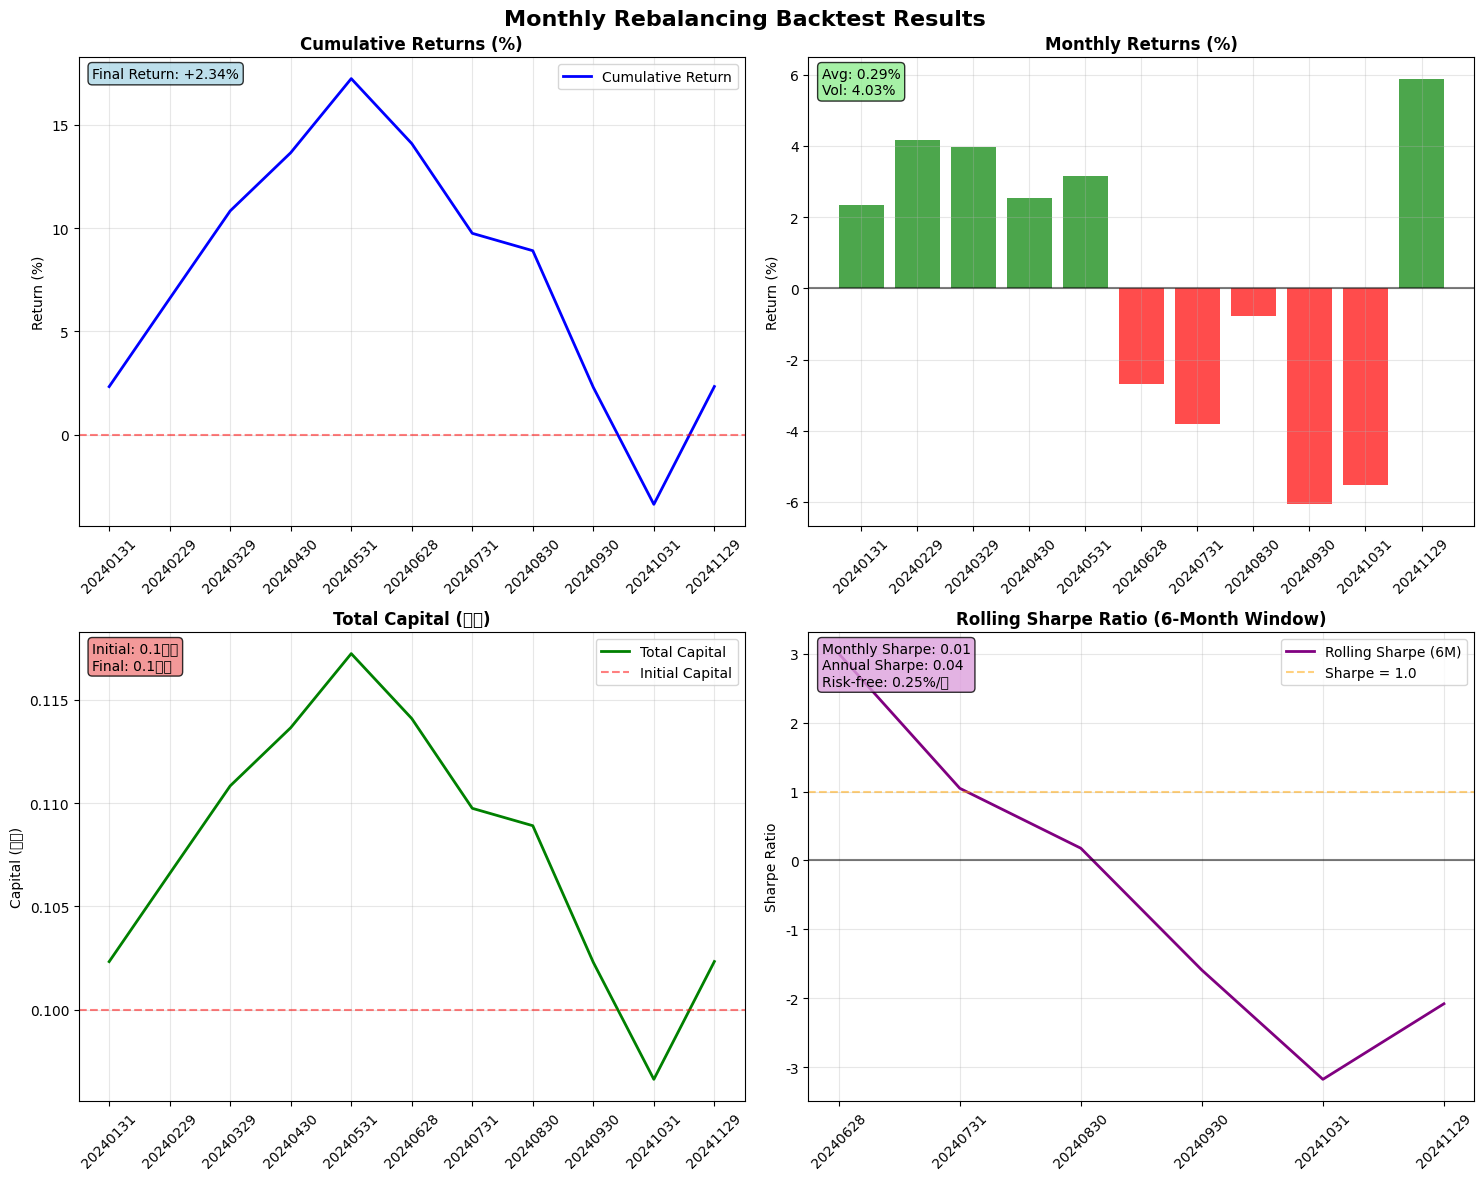


üìä Î∞±ÌÖåÏä§Ìä∏ ÏÑ±Í≥º ÏöîÏïΩ
üìà Ï¥ù ÏàòÏùµÎ•†: +2.34%
üí∞ ÏµúÏ¢Ö ÏûêÏÇ∞: 10,233,973Ïõê
üìä ÏõîÌèâÍ∑† ÏàòÏùµÎ•†: 0.29%
üìä ÏõîÍ∞Ñ Î≥ÄÎèôÏÑ±: 4.03%
üìä Î¨¥ÏúÑÌóòÏàòÏùµÎ•†: 0.25%/Ïõî (Ïó∞ 3.0%)
üìä ÏÉ§ÌîÑÎπÑÏú® (ÏõîÍ∞Ñ): 0.01
üìä ÏÉ§ÌîÑÎπÑÏú® (Ïó∞Í∞ÑÏ∂îÏ†ï): 0.04
üìä ÏµúÍ≥† ÏõîÍ∞ÑÏàòÏùµ: +5.89%
üìä ÏµúÏ†Ä ÏõîÍ∞ÑÏàòÏùµ: -6.07%
üìä ÏäπÎ•†: 54.5%


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime

def run_monthly_rebalancing_backtest(df, initial_capital=10000000, top_n=20):
    print("üöÄ ÏõîÎ≥Ñ Î¶¨Î∞∏Îü∞Ïã± Î∞±ÌÖåÏä§Ìä∏ ÏãúÏûë!")
    print("="*60)
    
    # Î¶¨Î∞∏Îü∞Ïã± ÎÇ†Ïßú ÏÉùÏÑ±
    rebalancing_dates = get_rebalancing_dates(df)
    
    # Î∞±ÌÖåÏä§Ìä∏ Í≤∞Í≥º Ï†ÄÏû•
    backtest_results = {
        'monthly_returns': [],
        'monthly_portfolios': [],
        'cumulative_returns': [],
        'total_capital': [initial_capital],
        'dates': []  # ÎÇ†Ïßú Ï†ïÎ≥¥ Ï∂îÍ∞Ä
    }
    
    current_capital = initial_capital
    
    print(f"üí∞ Ï¥àÍ∏∞ ÏûêÎ≥∏: {initial_capital:,}Ïõê")
    print(f"üìÖ Î∞±ÌÖåÏä§Ìä∏ Í∏∞Í∞Ñ: {len(rebalancing_dates)}Í∞úÏõî")
    print(f"üéØ ÏõîÎ≥Ñ Ìè¨Ìä∏Ìè¥Î¶¨Ïò§: {top_n}Í∞ú Ï¢ÖÎ™©\n")
    
    for i, current_date in enumerate(rebalancing_dates):
        month_num = i + 1
        print(f"{'='*20} {month_num}ÏõîÏ∞® ({current_date}) {'='*20}")
        
        try:
            # 1Îã®Í≥Ñ: Ìï¥Îãπ ÏõîÏùò Ïû¨Î¨¥ÏßÄÌëú Ï∂îÏ∂ú
            fundamentals = get_fundamentals_at_date(df, current_date)
            if fundamentals.empty:
                print(f"‚ùå {month_num}Ïõî: Ïû¨Î¨¥ÏßÄÌëú Îç∞Ïù¥ÌÑ∞ ÏóÜÏùå")
                continue
            
            # 2Îã®Í≥Ñ: Ï¢ÖÎ™© Ïä§ÌÅ¨Î¶¨Îãù
            selected_stocks = screen_stocks_monthly(fundamentals)
            if len(selected_stocks) < top_n:
                print(f"‚ö†Ô∏è {month_num}Ïõî: ÏÑ†Î≥Ñ Ï¢ÖÎ™© Î∂ÄÏ°± ({len(selected_stocks)}Í∞ú)")
                # Í∞ÄÎä•Ìïú Ï¢ÖÎ™© ÏàòÎ°ú Ï°∞Ï†ï
                current_top_n = min(len(selected_stocks), top_n)
            else:
                current_top_n = top_n
            
            # 3Îã®Í≥Ñ: Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Íµ¨ÏÑ±
            portfolio = calculate_factor_scores_and_portfolio(
                fundamentals, selected_stocks, top_n=current_top_n
            )
            
            if portfolio.empty:
                print(f"‚ùå {month_num}Ïõî: Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Íµ¨ÏÑ± Ïã§Ìå®")
                continue
            
            # 4Îã®Í≥Ñ: Îã§Ïùå ÏõîÍπåÏßÄÏùò ÏàòÏùµÎ•† Í≥ÑÏÇ∞
            if i < len(rebalancing_dates) - 1:
                next_date = rebalancing_dates[i + 1]
                
                # Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÎîïÏÖîÎÑàÎ¶¨ ÏÉùÏÑ±
                current_portfolio = {}
                for _, row in portfolio.iterrows():
                    current_portfolio[row['Ï¢ÖÎ™©Î™Ö']] = row['Ìè¨Ìä∏Ìè¥Î¶¨Ïò§_ÎπÑÏ§ë']
                
                # ÏõîÎ≥Ñ ÏàòÏùµÎ•† Í≥ÑÏÇ∞
                monthly_result = calculate_monthly_returns(
                    df, current_portfolio, current_date, next_date
                )
                
                # ÏûêÎ≥∏ ÏóÖÎç∞Ïù¥Ìä∏
                monthly_return_pct = monthly_result['portfolio_return']
                current_capital = current_capital * (1 + monthly_return_pct / 100)
                
                # Í≤∞Í≥º Ï†ÄÏû•
                backtest_results['monthly_returns'].append(monthly_return_pct)
                backtest_results['monthly_portfolios'].append(current_portfolio)
                backtest_results['total_capital'].append(current_capital)
                backtest_results['dates'].append(current_date)
                
                # ÎàÑÏ†Å ÏàòÏùµÎ•† Í≥ÑÏÇ∞
                cumulative_return = (current_capital - initial_capital) / initial_capital * 100
                backtest_results['cumulative_returns'].append(cumulative_return)
                
                print(f"üíº {month_num}Ïõî ÏÑ±Í≥º: {monthly_return_pct:+6.2f}% | ÎàÑÏ†Å: {cumulative_return:+6.2f}% | ÏûêÏÇ∞: {current_capital:,.0f}Ïõê")
            
            else:
                print(f"üìä {month_num}Ïõî: ÎßàÏßÄÎßâ Ïõî (ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ÏóÜÏùå)")
                
        except Exception as e:
            print(f"‚ùå {month_num}Ïõî Ï≤òÎ¶¨ Ï§ë Ïò§Î•ò: {e}")
            continue
        
        print()  # ÏõîÎ≥Ñ Íµ¨Î∂ÑÏÑ†
    
    # ÏµúÏ¢Ö ÏÑ±Í≥º Í≥ÑÏÇ∞
    final_return = (current_capital - initial_capital) / initial_capital * 100
    
    print("üèÅ Î∞±ÌÖåÏä§Ìä∏ ÏôÑÎ£å!")
    print("="*60)
    print(f"üìä ÏµúÏ¢Ö ÏÑ±Í≥º:")
    print(f"   Ï¥àÍ∏∞ ÏûêÎ≥∏: {initial_capital:,}Ïõê")
    print(f"   ÏµúÏ¢Ö ÏûêÎ≥∏: {current_capital:,.0f}Ïõê")
    print(f"   Ï¥ù ÏàòÏùµÎ•†: {final_return:+6.2f}%")
    
    if backtest_results['monthly_returns']:
        monthly_returns = backtest_results['monthly_returns']
        avg_monthly = np.mean(monthly_returns)
        volatility = np.std(monthly_returns)
        
        print(f"   ÏõîÌèâÍ∑† ÏàòÏùµÎ•†: {avg_monthly:6.2f}%")
        print(f"   ÏõîÍ∞Ñ Î≥ÄÎèôÏÑ±: {volatility:6.2f}%")
        print(f"   ÏÉ§ÌîÑÎπÑÏú® Ï∂îÏ†ï: {avg_monthly/volatility:.2f}" if volatility > 0 else "   ÏÉ§ÌîÑÎπÑÏú®: Í≥ÑÏÇ∞Î∂àÍ∞Ä")
        
        # ÏµúÍ≥†/ÏµúÏ†Ä Ïõî ÏÑ±Í≥º
        best_month = max(monthly_returns)
        worst_month = min(monthly_returns)
        print(f"   ÏµúÍ≥† ÏõîÍ∞ÑÏàòÏùµ: {best_month:+6.2f}%")
        print(f"   ÏµúÏ†Ä ÏõîÍ∞ÑÏàòÏùµ: {worst_month:+6.2f}%")
    
    # Í≤∞Í≥º ÎîïÏÖîÎÑàÎ¶¨Ïóê ÏµúÏ¢Ö Ï†ïÎ≥¥ Ï∂îÍ∞Ä
    backtest_results.update({
        'initial_capital': initial_capital,
        'final_capital': current_capital,
        'total_return': final_return,
        'rebalancing_dates': rebalancing_dates
    })
    
    return backtest_results

def plot_backtest_results(backtest_results):
    """
    Î∞±ÌÖåÏä§Ìä∏ Í≤∞Í≥ºÎ•º ÏãúÍ∞ÅÌôîÌïòÎäî Ìï®Ïàò
    """
    # ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï
    plt.rcParams['font.family'] = 'DejaVu Sans'
    plt.rcParams['axes.unicode_minus'] = False
    
    # Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
    dates = backtest_results['dates']
    monthly_returns = backtest_results['monthly_returns']
    cumulative_returns = backtest_results['cumulative_returns']
    total_capital = backtest_results['total_capital'][1:]  # Ï≤´ Î≤àÏß∏ Ï¥àÍ∏∞Í∞í Ï†úÏô∏
    
    # ÏÉ§ÌîÑÎπÑÏú® Í≥ÑÏÇ∞ (Î¨¥ÏúÑÌóò ÏàòÏùµÎ•† Í≥†Î†§)
    risk_free_rate_monthly = 0.25  # Ïõî Î¨¥ÏúÑÌóò ÏàòÏùµÎ•† (Ïó∞ 3% Í∞ÄÏ†ï -> Ïõî 0.25%)
    
    if len(monthly_returns) > 1:
        excess_returns = [r - risk_free_rate_monthly for r in monthly_returns]
        monthly_avg_excess = np.mean(excess_returns)
        monthly_std = np.std(monthly_returns)
        monthly_sharpe = monthly_avg_excess / monthly_std if monthly_std > 0 else 0
        
        # Ïó∞Í∞Ñ ÏÉ§ÌîÑÎπÑÏú® Ï∂îÏ†ï (ÏõîÎ≥Ñ * sqrt(12))
        annual_sharpe = monthly_sharpe * np.sqrt(12)
    else:
        monthly_sharpe = 0
        annual_sharpe = 0
    
    # Î°§ÎßÅ ÏÉ§ÌîÑÎπÑÏú® Í≥ÑÏÇ∞ (6Í∞úÏõî ÏúàÎèÑÏö∞)
    rolling_sharpe = []
    window = 6
    for i in range(len(monthly_returns)):
        if i < window - 1:
            rolling_sharpe.append(np.nan)
        else:
            window_returns = monthly_returns[i-window+1:i+1]
            window_excess = [r - risk_free_rate_monthly for r in window_returns]
            window_avg_excess = np.mean(window_excess)
            window_std = np.std(window_returns)
            sharpe = window_avg_excess / window_std if window_std > 0 else 0
            rolling_sharpe.append(sharpe * np.sqrt(12))  # Ïó∞Í∞ÑÌôî
    
    # Í∑∏ÎûòÌîÑ ÏÉùÏÑ±
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Monthly Rebalancing Backtest Results', fontsize=16, fontweight='bold')
    
    # 1. ÎàÑÏ†Å ÏàòÏùµÎ•†
    axes[0, 0].plot(dates, cumulative_returns, 'b-', linewidth=2, label='Cumulative Return')
    axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    axes[0, 0].set_title('Cumulative Returns (%)', fontweight='bold')
    axes[0, 0].set_ylabel('Return (%)')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend()
    
    # ÏµúÏ¢Ö ÏàòÏùµÎ•† ÌëúÏãú
    if cumulative_returns:
        final_return = cumulative_returns[-1]
        axes[0, 0].text(0.02, 0.98, f'Final Return: {final_return:+.2f}%', 
                       transform=axes[0, 0].transAxes, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    # 2. ÏõîÎ≥Ñ ÏàòÏùµÎ•†
    colors = ['green' if x >= 0 else 'red' for x in monthly_returns]
    axes[0, 1].bar(dates, monthly_returns, color=colors, alpha=0.7)
    axes[0, 1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    axes[0, 1].set_title('Monthly Returns (%)', fontweight='bold')
    axes[0, 1].set_ylabel('Return (%)')
    axes[0, 1].grid(True, alpha=0.3)
    
    # ÌÜµÍ≥Ñ Ï†ïÎ≥¥ ÌëúÏãú
    if monthly_returns:
        avg_return = np.mean(monthly_returns)
        volatility = np.std(monthly_returns)
        axes[0, 1].text(0.02, 0.98, f'Avg: {avg_return:.2f}%\nVol: {volatility:.2f}%', 
                       transform=axes[0, 1].transAxes, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    
    # 3. ÎàÑÏ†Å ÏûêÏÇ∞ (ÏñµÏõê Îã®ÏúÑÎ°ú ÌëúÏãú)
    total_capital_billion = [x / 100000000 for x in total_capital]  # ÏñµÏõê Îã®ÏúÑ Î≥ÄÌôò
    initial_capital_billion = backtest_results['initial_capital'] / 100000000
    
    axes[1, 0].plot(dates, total_capital_billion, 'g-', linewidth=2, label='Total Capital')
    axes[1, 0].axhline(y=initial_capital_billion, color='r', linestyle='--', alpha=0.5, label='Initial Capital')
    axes[1, 0].set_title('Total Capital (ÏñµÏõê)', fontweight='bold')
    axes[1, 0].set_ylabel('Capital (ÏñµÏõê)')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend()
    
    # ÏûêÏÇ∞ Ï†ïÎ≥¥ ÌëúÏãú (ÏñµÏõê Îã®ÏúÑ)
    initial_capital = backtest_results['initial_capital']
    final_capital = backtest_results['final_capital']
    axes[1, 0].text(0.02, 0.98, f'Initial: {initial_capital_billion:.1f}ÏñµÏõê\nFinal: {final_capital/100000000:.1f}ÏñµÏõê', 
                   transform=axes[1, 0].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
    
    # 4. ÏÉ§ÌîÑÎπÑÏú® (Î°§ÎßÅ)
    valid_dates = [d for i, d in enumerate(dates) if not np.isnan(rolling_sharpe[i])]
    valid_sharpe = [s for s in rolling_sharpe if not np.isnan(s)]
    
    if valid_dates and valid_sharpe:
        axes[1, 1].plot(valid_dates, valid_sharpe, 'purple', linewidth=2, label='Rolling Sharpe (6M)')
        axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
        axes[1, 1].axhline(y=1, color='orange', linestyle='--', alpha=0.5, label='Sharpe = 1.0')
    
    axes[1, 1].set_title('Rolling Sharpe Ratio (6-Month Window)', fontweight='bold')
    axes[1, 1].set_ylabel('Sharpe Ratio')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].legend()
    
    # ÏÉ§ÌîÑÎπÑÏú® Ï†ïÎ≥¥ ÌëúÏãú
    axes[1, 1].text(0.02, 0.98, f'Monthly Sharpe: {monthly_sharpe:.2f}\nAnnual Sharpe: {annual_sharpe:.2f}\nRisk-free: {risk_free_rate_monthly:.2f}%/Ïõî', 
                   transform=axes[1, 1].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='plum', alpha=0.8))
    
    # xÏ∂ï ÎÇ†Ïßú Ìè¨Îß∑ Ï°∞Ï†ï
    for ax in axes.flat:
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # ÏÑ±Í≥º ÏöîÏïΩ Ï∂úÎ†•
    print("\n" + "="*60)
    print("üìä Î∞±ÌÖåÏä§Ìä∏ ÏÑ±Í≥º ÏöîÏïΩ")
    print("="*60)
    print(f"üìà Ï¥ù ÏàòÏùµÎ•†: {backtest_results['total_return']:+.2f}%")
    print(f"üí∞ ÏµúÏ¢Ö ÏûêÏÇ∞: {backtest_results['final_capital']:,.0f}Ïõê")
    print(f"üìä ÏõîÌèâÍ∑† ÏàòÏùµÎ•†: {np.mean(monthly_returns):.2f}%")
    print(f"üìä ÏõîÍ∞Ñ Î≥ÄÎèôÏÑ±: {np.std(monthly_returns):.2f}%")
    print(f"üìä Î¨¥ÏúÑÌóòÏàòÏùµÎ•†: {risk_free_rate_monthly:.2f}%/Ïõî (Ïó∞ {risk_free_rate_monthly*12:.1f}%)")
    print(f"üìä ÏÉ§ÌîÑÎπÑÏú® (ÏõîÍ∞Ñ): {monthly_sharpe:.2f}")
    print(f"üìä ÏÉ§ÌîÑÎπÑÏú® (Ïó∞Í∞ÑÏ∂îÏ†ï): {annual_sharpe:.2f}")
    print(f"üìä ÏµúÍ≥† ÏõîÍ∞ÑÏàòÏùµ: {max(monthly_returns):+.2f}%")
    print(f"üìä ÏµúÏ†Ä ÏõîÍ∞ÑÏàòÏùµ: {min(monthly_returns):+.2f}%")
    print(f"üìä ÏäπÎ•†: {len([x for x in monthly_returns if x > 0])/len(monthly_returns)*100:.1f}%")

# Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ
print("Î∞±ÌÖåÏä§Ìä∏Î•º Ïã§ÌñâÌïòÏãúÍ≤†ÏäµÎãàÍπå? (Y/N)")
print("Ï∞∏Í≥†: Ï†ÑÏ≤¥ Ïã§ÌñâÏóêÎäî Î™á Î∂ÑÏù¥ ÏÜåÏöîÎê† Ïàò ÏûàÏäµÎãàÎã§.")

# Ïã§Ï†ú Ïã§Ìñâ
backtest_results = run_monthly_rebalancing_backtest(analysis_df, initial_capital=10000000, top_n=10)

# Í≤∞Í≥º ÏãúÍ∞ÅÌôî
plot_backtest_results(backtest_results)

# ================================================================Ï∞∏Í≥†ÏûêÎ£å================================================================


üìä Î∞±ÌÖåÏä§Ìä∏ Í≤∞Í≥º ÏãúÍ∞ÅÌôî ÏãúÏûë...


/var/folders/cj/3sbgdsnd177fymhmpd4_c7b80000gn/T/ipykernel_65897/972048784.py:105: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) AppleGothic.
  plt.tight_layout()
/var/folders/cj/3sbgdsnd177fymhmpd4_c7b80000gn/T/ipykernel_65897/972048784.py:105: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) AppleGothic.
  plt.tight_layout()
/var/folders/cj/3sbgdsnd177fymhmpd4_c7b80000gn/T/ipykernel_65897/972048784.py:105: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/cj/3sbgdsnd177fymhmpd4_c7b80000gn/T/ipykernel_65897/972048784.py:105: UserWarning: Glyph 48177 (\N{HANGUL SYLLABLE BAEG}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/cj/3sbgdsnd177fymhmpd4_c7b80000gn/T/ipykernel_65897/972048784.py:105: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/cj/3sbgdsnd177fymhmpd4_c7b80000gn/T/ipy

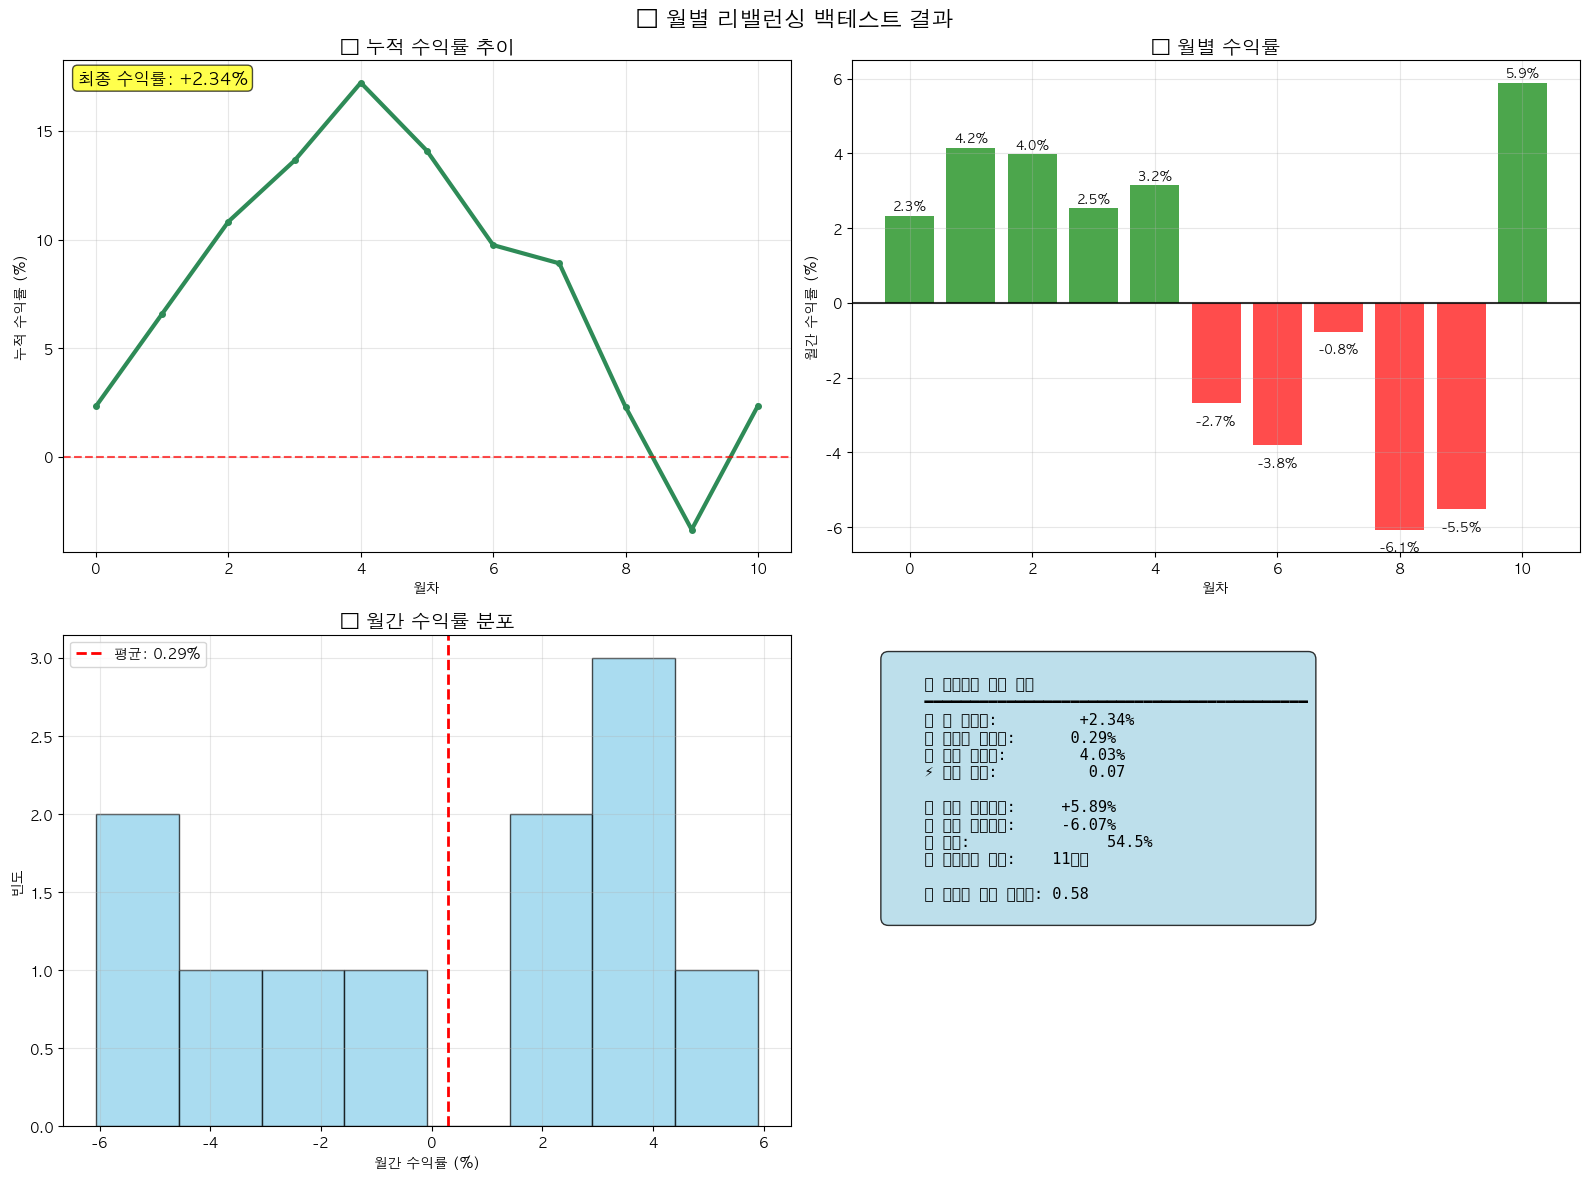


üìä Î∞±ÌÖåÏä§Ìä∏ ÏÉÅÏÑ∏ Î∂ÑÏÑù

üìÖ ÏõîÎ≥Ñ ÏàòÏùµÎ•† ÏÉÅÏÑ∏:
    1ÏõîÏ∞®: üü¢  +2.33%
    2ÏõîÏ∞®: üü¢  +4.16%
    3ÏõîÏ∞®: üü¢  +3.98%
    4ÏõîÏ∞®: üü¢  +2.54%
    5ÏõîÏ∞®: üü¢  +3.15%
    6ÏõîÏ∞®: üî¥  -2.68%
    7ÏõîÏ∞®: üî¥  -3.80%
    8ÏõîÏ∞®: üî¥  -0.77%
    9ÏõîÏ∞®: üî¥  -6.07%
   10ÏõîÏ∞®: üî¥  -5.53%
   11ÏõîÏ∞®: üü¢  +5.89%

üìä Î∂ÑÍ∏∞Î≥Ñ ÏàòÏùµÎ•†:
   1Î∂ÑÍ∏∞: +10.47%
   2Î∂ÑÍ∏∞:  +3.01%
   3Î∂ÑÍ∏∞: -10.63%
   4Î∂ÑÍ∏∞:  +0.37%

üî• Ïó∞ÏÜç ÏÑ±Í≥º:
   ÏµúÎåÄ Ïó∞ÏÜç ÏàòÏùµ: 5Í∞úÏõî
   ÏµúÎåÄ Ïó∞ÏÜç ÏÜêÏã§: 5Í∞úÏõî


In [50]:
import warnings
warnings.filterwarnings('ignore')

def visualize_backtest_results(backtest_results):
    """
    Î∞±ÌÖåÏä§Ìä∏ Í≤∞Í≥ºÎ•º Ï¢ÖÌï©Ï†ÅÏúºÎ°ú ÏãúÍ∞ÅÌôîÌïòÎäî Ìï®Ïàò
    
    Parameters:
    - backtest_results: run_monthly_rebalancing_backtest() Í≤∞Í≥º
    
    Í∏∞Îä•:
    1. ÎàÑÏ†Å ÏàòÏùµÎ•† Ï∞®Ìä∏
    2. ÏõîÎ≥Ñ ÏàòÏùµÎ•† Î∂ÑÌè¨ 
    3. ÎìúÎ°úÎã§Ïö¥ Î∂ÑÏÑù
    4. ÏÑ±Í≥º ÏßÄÌëú ÎåÄÏãúÎ≥¥Îìú
    """
    
    # Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
    monthly_returns = backtest_results['monthly_returns']
    cumulative_returns = backtest_results['cumulative_returns']
    rebalancing_dates = backtest_results['rebalancing_dates'][1:]  # Ï≤´ Î≤àÏß∏ Ï†úÏô∏ (ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ÏãúÏûëÏ†ê)
    
    # ÎÇ†ÏßúÎ•º Ïõî ÌòïÌÉúÎ°ú Î≥ÄÌôò
    month_labels = [f"{date[4:6]}Ïõî" for date in rebalancing_dates]
    
    # 4x2 ÏÑúÎ∏åÌîåÎ°Ø ÏÉùÏÑ±
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('üìä ÏõîÎ≥Ñ Î¶¨Î∞∏Îü∞Ïã± Î∞±ÌÖåÏä§Ìä∏ Í≤∞Í≥º', fontsize=16, fontweight='bold')
    
    # 1. ÎàÑÏ†Å ÏàòÏùµÎ•† Ï∞®Ìä∏
    axes[0,0].plot(range(len(cumulative_returns)), cumulative_returns, 
                   linewidth=3, color='#2E8B57', marker='o', markersize=4)
    axes[0,0].axhline(y=0, color='red', linestyle='--', alpha=0.7)
    axes[0,0].set_title('üìà ÎàÑÏ†Å ÏàòÏùµÎ•† Ï∂îÏù¥', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('ÏõîÏ∞®')
    axes[0,0].set_ylabel('ÎàÑÏ†Å ÏàòÏùµÎ•† (%)')
    axes[0,0].grid(True, alpha=0.3)
    
    # ÏµúÏ¢Ö ÏàòÏùµÎ•† ÌëúÏãú
    final_return = cumulative_returns[-1] if cumulative_returns else 0
    axes[0,0].text(0.02, 0.98, f'ÏµúÏ¢Ö ÏàòÏùµÎ•†: {final_return:+.2f}%', 
                   transform=axes[0,0].transAxes, fontsize=12, fontweight='bold',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
                   verticalalignment='top')
    
    # 2. ÏõîÎ≥Ñ ÏàòÏùµÎ•† Î∞îÏ∞®Ìä∏
    colors = ['green' if ret > 0 else 'red' for ret in monthly_returns]
    bars = axes[0,1].bar(range(len(monthly_returns)), monthly_returns, color=colors, alpha=0.7)
    axes[0,1].axhline(y=0, color='black', linestyle='-', alpha=0.8)
    axes[0,1].set_title('üìä ÏõîÎ≥Ñ ÏàòÏùµÎ•†', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('ÏõîÏ∞®')
    axes[0,1].set_ylabel('ÏõîÍ∞Ñ ÏàòÏùµÎ•† (%)')
    axes[0,1].grid(True, alpha=0.3)
    
    # ÏõîÎ≥Ñ ÏàòÏùµÎ•† Í∞í ÌëúÏãú
    for i, (bar, ret) in enumerate(zip(bars, monthly_returns)):
        height = bar.get_height()
        axes[0,1].text(bar.get_x() + bar.get_width()/2., height + (0.1 if height > 0 else -0.3),
                       f'{ret:.1f}%', ha='center', va='bottom' if height > 0 else 'top', 
                       fontsize=9, fontweight='bold')
    
    # 3. ÏàòÏùµÎ•† Î∂ÑÌè¨ ÌûàÏä§ÌÜ†Í∑∏Îû®
    axes[1,0].hist(monthly_returns, bins=8, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1,0].axvline(np.mean(monthly_returns), color='red', linestyle='--', 
                      linewidth=2, label=f'ÌèâÍ∑†: {np.mean(monthly_returns):.2f}%')
    axes[1,0].set_title('üìä ÏõîÍ∞Ñ ÏàòÏùµÎ•† Î∂ÑÌè¨', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('ÏõîÍ∞Ñ ÏàòÏùµÎ•† (%)')
    axes[1,0].set_ylabel('ÎπàÎèÑ')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. ÏÑ±Í≥º ÏßÄÌëú ÎåÄÏãúÎ≥¥Îìú
    axes[1,1].axis('off')  # Ï∂ï Ï†úÍ±∞
    
    # ÏÑ±Í≥º ÏßÄÌëú Í≥ÑÏÇ∞
    total_return = backtest_results['total_return']
    avg_monthly = np.mean(monthly_returns)
    volatility = np.std(monthly_returns)
    sharpe_ratio = avg_monthly / volatility if volatility > 0 else 0
    best_month = max(monthly_returns) if monthly_returns else 0
    worst_month = min(monthly_returns) if monthly_returns else 0
    
    # ÏäπÎ•† Í≥ÑÏÇ∞
    win_rate = len([r for r in monthly_returns if r > 0]) / len(monthly_returns) * 100 if monthly_returns else 0
    
    # ÌÖçÏä§Ìä∏ Î∞ïÏä§Î°ú ÏÑ±Í≥º ÏßÄÌëú ÌëúÏãú
    performance_text = f"""
    üìä Î∞±ÌÖåÏä§Ìä∏ ÏÑ±Í≥º ÏöîÏïΩ
    ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ
    üéØ Ï¥ù ÏàòÏùµÎ•†:        {total_return:+6.2f}%
    üìà ÏõîÌèâÍ∑† ÏàòÏùµÎ•†:    {avg_monthly:6.2f}%
    üìä ÏõîÍ∞Ñ Î≥ÄÎèôÏÑ±:      {volatility:6.2f}%
    ‚ö° ÏÉ§ÌîÑ ÎπÑÏú®:        {sharpe_ratio:6.2f}
    
    üèÜ ÏµúÍ≥† ÏõîÍ∞ÑÏàòÏùµ:    {best_month:+6.2f}%
    üìâ ÏµúÏ†Ä ÏõîÍ∞ÑÏàòÏùµ:    {worst_month:+6.2f}%
    üé≤ ÏäπÎ•†:             {win_rate:6.1f}%
    üìÖ Î∞±ÌÖåÏä§Ìä∏ Í∏∞Í∞Ñ:    {len(monthly_returns)}Í∞úÏõî
    
    üí° Î¶¨Ïä§ÌÅ¨ Ï°∞Ï†ï ÏàòÏùµÎ•†: {total_return/volatility:.2f}
    """
    
    axes[1,1].text(0.05, 0.95, performance_text, transform=axes[1,1].transAxes,
                   fontsize=11, fontfamily='monospace',
                   bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8),
                   verticalalignment='top')
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Î∞±ÌÖåÏä§Ìä∏ ÏÉÅÏÑ∏ Î∂ÑÏÑù Ìï®Ïàò
def analyze_backtest_performance(backtest_results):
    """
    Î∞±ÌÖåÏä§Ìä∏ ÏÑ±Í≥º ÏÉÅÏÑ∏ Î∂ÑÏÑù
    """
    monthly_returns = backtest_results['monthly_returns']
    
    print("\n" + "="*60)
    print("üìä Î∞±ÌÖåÏä§Ìä∏ ÏÉÅÏÑ∏ Î∂ÑÏÑù")
    print("="*60)
    
    # ÏõîÎ≥Ñ ÏÑ±Í≥º ÏÉÅÏÑ∏
    print(f"\nüìÖ ÏõîÎ≥Ñ ÏàòÏùµÎ•† ÏÉÅÏÑ∏:")
    for i, ret in enumerate(monthly_returns, 1):
        status = "üü¢" if ret > 0 else "üî¥" if ret < 0 else "‚ö™"
        print(f"   {i:2d}ÏõîÏ∞®: {status} {ret:+6.2f}%")
    
    # Î∂ÑÍ∏∞Î≥Ñ ÏÑ±Í≥º
    if len(monthly_returns) >= 9:
        q1_return = sum(monthly_returns[0:3])
        q2_return = sum(monthly_returns[3:6])
        q3_return = sum(monthly_returns[6:9])
        q4_return = sum(monthly_returns[9:]) if len(monthly_returns) > 9 else 0
        
        print(f"\nüìä Î∂ÑÍ∏∞Î≥Ñ ÏàòÏùµÎ•†:")
        print(f"   1Î∂ÑÍ∏∞: {q1_return:+6.2f}%")
        print(f"   2Î∂ÑÍ∏∞: {q2_return:+6.2f}%")
        print(f"   3Î∂ÑÍ∏∞: {q3_return:+6.2f}%")
        if q4_return != 0:
            print(f"   4Î∂ÑÍ∏∞: {q4_return:+6.2f}%")
    
    # ÏµúÎåÄ Ïó∞ÏÜç ÏàòÏùµ/ÏÜêÏã§
    consecutive_wins = 0
    consecutive_losses = 0
    max_consecutive_wins = 0
    max_consecutive_losses = 0
    
    for ret in monthly_returns:
        if ret > 0:
            consecutive_wins += 1
            consecutive_losses = 0
            max_consecutive_wins = max(max_consecutive_wins, consecutive_wins)
        elif ret < 0:
            consecutive_losses += 1
            consecutive_wins = 0
            max_consecutive_losses = max(max_consecutive_losses, consecutive_losses)
        else:
            consecutive_wins = 0
            consecutive_losses = 0
    
    print(f"\nüî• Ïó∞ÏÜç ÏÑ±Í≥º:")
    print(f"   ÏµúÎåÄ Ïó∞ÏÜç ÏàòÏùµ: {max_consecutive_wins}Í∞úÏõî")
    print(f"   ÏµúÎåÄ Ïó∞ÏÜç ÏÜêÏã§: {max_consecutive_losses}Í∞úÏõî")

# Ïã§Ìñâ ÏòàÏãú
if 'backtest_results' in locals():
    print("üìä Î∞±ÌÖåÏä§Ìä∏ Í≤∞Í≥º ÏãúÍ∞ÅÌôî ÏãúÏûë...")
    
    # ÏãúÍ∞ÅÌôî Ïã§Ìñâ
    chart = visualize_backtest_results(backtest_results)
    
    # ÏÉÅÏÑ∏ Î∂ÑÏÑù Ïã§Ìñâ
    analyze_backtest_performance(backtest_results)
    
else:
    print("Î®ºÏ†Ä Î∞±ÌÖåÏä§Ìä∏Î•º Ïã§ÌñâÌï¥Ï£ºÏÑ∏Ïöî: backtest_results = run_monthly_rebalancing_backtest(...)")

# ======================= Ï∞∏Í≥†ÏûêÎ£å


üöÄ ÌÄÄÌä∏ Ìà¨Ïûê Ï†ÑÎûµ Î∂ÑÏÑù ÏãúÏûë!
üìÇ Îç∞Ïù¥ÌÑ∞ Î°úÎî© Ï§ë...
‚úÖ Î°úÎî© ÏôÑÎ£å: 735 Ìñâ, 244 Í±∞ÎûòÏùº
üìÖ Í∏∞Í∞Ñ: 20240102 ~ 20241230

üìä Îç∞Ïù¥ÌÑ∞ Íµ¨Ï°∞ ÌååÏïÖ Ï§ë...
üìà Íµ¨Î∂Ñ: ['Ï¢ÖÍ∞Ä', 'PER', 'PBR', 'ROE', 'ROA', 'ÏòÅÏóÖÏù¥ÏùµÎ•†', 'Î∂ÄÏ±ÑÎπÑÏú®']
üè¢ Ï¢ÖÎ™© Ïàò: 105 Í∞ú

üí∞ ÏàòÏùµÎ•† Í≥ÑÏÇ∞ Ï§ë...
üìä ÌèâÍ∑† ÏàòÏùµÎ•†: 10.8%
üìä ÏµúÍ≥† ÏàòÏùµÎ•†: 72.6%
üìä ÏµúÏ†Ä ÏàòÏùµÎ•†: -50.2%

üîç Ïû¨Î¨¥ÏßÄÌëú Î∂ÑÏÑù Ï§ë...
PER: Ï§ëÍ∞ÑÍ∞í 43.5, ÌèâÍ∑† 106.0
PBR: Ï§ëÍ∞ÑÍ∞í 1.4, ÌèâÍ∑† 2.4
ROE: Ï§ëÍ∞ÑÍ∞í 1.7, ÌèâÍ∑† 0.8
ROA: Ï§ëÍ∞ÑÍ∞í 1.3, ÌèâÍ∑† 1.4
ÏòÅÏóÖÏù¥ÏùµÎ•†: Ï§ëÍ∞ÑÍ∞í 5.2, ÌèâÍ∑† -74.1
Î∂ÄÏ±ÑÎπÑÏú®: Ï§ëÍ∞ÑÍ∞í 52.0, ÌèâÍ∑† 70.0

üéØ Ï¢ÖÎ™© Ïä§ÌÅ¨Î¶¨Îãù Ï§ë...
‚úÖ ÏÑ†Î≥ÑÎêú Ï¢ÖÎ™©: 23 Í∞ú

üèÜ Ìå©ÌÑ∞ Ïä§ÏΩîÏñ¥ Í≥ÑÏÇ∞ Ï§ë...
‚úÖ Ïä§ÏΩîÏñ¥ Í≥ÑÏÇ∞ ÏôÑÎ£å: 23 Í∞ú Ï¢ÖÎ™©

üéØ TOP 20 Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏÉùÏÑ± Ï§ë...
‚úÖ Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Íµ¨ÏÑ± ÏôÑÎ£å

üèÜ ÌÄÄÌä∏ Ìà¨Ïûê Î∂ÑÏÑù Í≤∞Í≥º

üìà TOP 10 Ï∂îÏ≤ú Ï¢ÖÎ™©:
 1. ÏºÄÏù¥ÌîÑ             | Ï¥ùÏ†ê:   51.7 | ÏàòÏùµÎ•†:   35

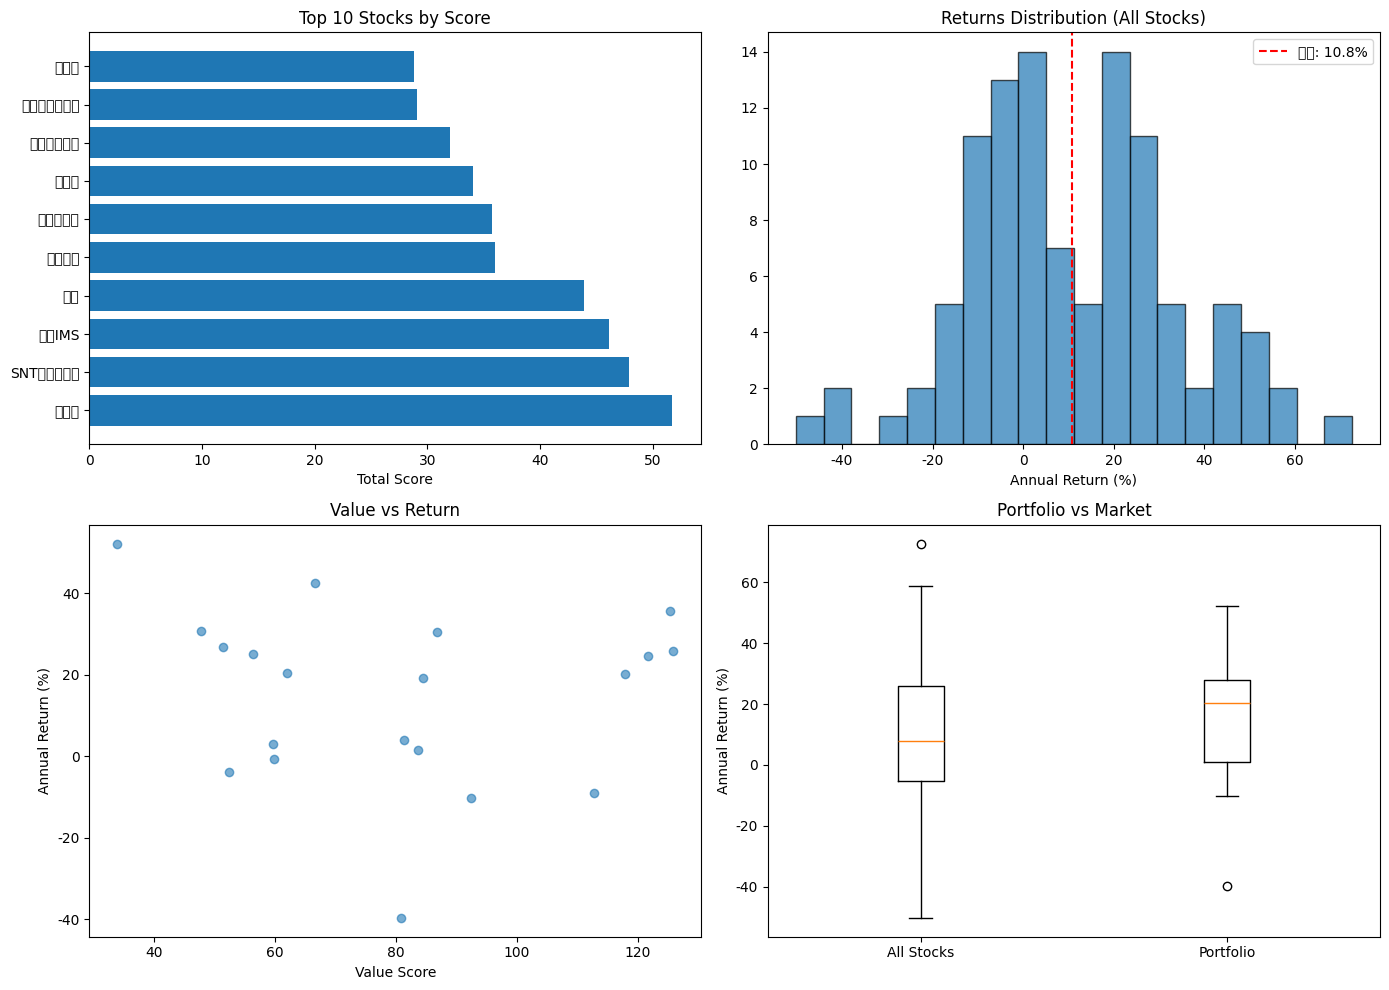


‚úÖ Î∂ÑÏÑù ÏôÑÎ£å!

üí° Ìà¨Ïûê Ï†ÑÎûµ ÏöîÏïΩ:
1. ÏÉÅÏúÑ 20Í∞ú Ï¢ÖÎ™©ÏúºÎ°ú Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Íµ¨ÏÑ±
2. ÎèôÏùº Í∞ÄÏ§ë (Í∞Å 5%) ÎòêÎäî ÏãúÍ∞ÄÏ¥ùÏï° Í∞ÄÏ§ë ÏÑ†ÌÉù
3. Î∂ÑÍ∏∞Î≥Ñ Î¶¨Î∞∏Îü∞Ïã± Í∂åÏû•
4. Í∞úÎ≥Ñ Ï¢ÖÎ™© Î¶¨Ïä§ÌÅ¨ Î™®ÎãàÌÑ∞ÎßÅ ÌïÑÏàò


In [383]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

def load_data(file_path):
    """
    Îç∞Ïù¥ÌÑ∞ Î°úÎìú Î∞è Í∏∞Î≥∏ Ï†ÑÏ≤òÎ¶¨
    """
    print("üìÇ Îç∞Ïù¥ÌÑ∞ Î°úÎî© Ï§ë...")
    df = analysis_df
    
    # ÎÇ†Ïßú Ïª¨Îüº Ï∂îÏ∂ú (YYYYMMDD ÌòïÌÉú)
    date_cols = [col for col in df.columns if col.isdigit() and len(col) == 8]
    
    print(f"‚úÖ Î°úÎî© ÏôÑÎ£å: {len(df)} Ìñâ, {len(date_cols)} Í±∞ÎûòÏùº")
    print(f"üìÖ Í∏∞Í∞Ñ: {date_cols[0]} ~ {date_cols[-1]}")
    
    return df, date_cols

def get_stock_data(df, date_cols):
    """
    Íµ¨Î∂ÑÎ≥Ñ Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú
    """
    print("\nüìä Îç∞Ïù¥ÌÑ∞ Íµ¨Ï°∞ ÌååÏïÖ Ï§ë...")
    
    # Íµ¨Î∂ÑÎ≥ÑÎ°ú Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨
    stock_data = {}
    for category in df['Íµ¨Î∂Ñ'].unique():
        stock_data[category] = df[df['Íµ¨Î∂Ñ'] == category].set_index('Ï¢ÖÎ™©Î™Ö')[date_cols]
    
    print(f"üìà Íµ¨Î∂Ñ: {list(stock_data.keys())}")
    print(f"üè¢ Ï¢ÖÎ™© Ïàò: {len(stock_data['Ï¢ÖÍ∞Ä'])} Í∞ú")
    
    return stock_data

def calculate_returns(price_data, date_cols):
    """
    ÏàòÏùµÎ•† Í≥ÑÏÇ∞
    """
    print("\nüí∞ ÏàòÏùµÎ•† Í≥ÑÏÇ∞ Ï§ë...")
    
    returns = {}
    for stock in price_data.index:
        start_price = price_data.loc[stock, date_cols[0]]
        end_price = price_data.loc[stock, date_cols[-1]]
        
        if pd.notna(start_price) and pd.notna(end_price) and start_price > 0:
            annual_return = (end_price / start_price - 1) * 100
            returns[stock] = annual_return
    
    # Í∏∞Î≥∏ ÌÜµÍ≥Ñ
    return_values = list(returns.values())
    print(f"üìä ÌèâÍ∑† ÏàòÏùµÎ•†: {np.mean(return_values):.1f}%")
    print(f"üìä ÏµúÍ≥† ÏàòÏùµÎ•†: {max(return_values):.1f}%")
    print(f"üìä ÏµúÏ†Ä ÏàòÏùµÎ•†: {min(return_values):.1f}%")
    
    return returns

def analyze_fundamentals(stock_data, date_cols):
    """
    Ïû¨Î¨¥ÏßÄÌëú Î∂ÑÏÑù
    """
    print("\nüîç Ïû¨Î¨¥ÏßÄÌëú Î∂ÑÏÑù Ï§ë...")
    
    # ÏµúÏã† Ïû¨Î¨¥ÏßÄÌëú Îç∞Ïù¥ÌÑ∞
    fundamentals = {}
    metrics = ['PER', 'PBR', 'ROE', 'ROA', 'ÏòÅÏóÖÏù¥ÏùµÎ•†', 'Î∂ÄÏ±ÑÎπÑÏú®']
    
    for metric in metrics:
        if metric in stock_data:
            latest_data = stock_data[metric][date_cols[-1]]
            fundamentals[metric] = latest_data
    
    fund_df = pd.DataFrame(fundamentals)
    
    # Í∞Å ÏßÄÌëúÏùò Î∂ÑÌè¨ Ï∂úÎ†•
    for metric in metrics:
        if metric in fund_df.columns:
            values = fund_df[metric].dropna()
            if len(values) > 0:
                print(f"{metric}: Ï§ëÍ∞ÑÍ∞í {values.median():.1f}, ÌèâÍ∑† {values.mean():.1f}")
    
    return fund_df

def screen_stocks(fund_df, returns):
    """
    Ï¢ÖÎ™© Ïä§ÌÅ¨Î¶¨Îãù (Ïù¥ÏÉÅÏπò Ï†úÍ±∞Îêú Ïã§Ï†ú Îç∞Ïù¥ÌÑ∞ Í∏∞Ï§Ä)
    """
    print("\nüéØ Ï¢ÖÎ™© Ïä§ÌÅ¨Î¶¨Îãù Ï§ë...")
    
    # Ïù¥ÏÉÅÏπò Ï†úÍ±∞Îêú Îç∞Ïù¥ÌÑ∞ Í∏∞Î∞ò ÌòÑÏã§Ï†Å Í∏∞Ï§Ä
    criteria = {
        'PER': (10.31, 60.48),        # Q1 ~ Upper_Bound
        'PBR': (0.81, 5.18),         # Q1 ~ Upper_Bound  
        'ROE': (0.99, 23.69),        # Q1 ~ Upper_Bound (ÏñëÏàò ÏàòÏùµÏÑ±)
        'ROA': (0.46, 15.48),        # Q1 ~ Upper_Bound (ÏñëÏàò ÏàòÏùµÏÑ±)
        'ÏòÅÏóÖÏù¥ÏùµÎ•†': (1.42, 28.94),   # Q1 ~ Upper_Bound (ÏñëÏàò ÎßàÏßÑ)
        'Î∂ÄÏ±ÑÎπÑÏú®': (0, 175.83)       # 0 ~ Upper_Bound (Í±¥Ï†ÑÏÑ±)
    }
    
    selected = []
    
    for stock in fund_df.index:
        if stock not in returns:
            continue
            
        # Î™®Îì† Ï°∞Í±¥ ÌôïÏù∏
        valid = True
        for metric, (min_val, max_val) in criteria.items():
            if metric not in fund_df.columns:
                continue
                
            value = fund_df.loc[stock, metric]
            if pd.isna(value) or value < min_val or value > max_val:
                valid = False
                break
        
        if valid:
            selected.append(stock)
    
    print(f"‚úÖ ÏÑ†Î≥ÑÎêú Ï¢ÖÎ™©: {len(selected)} Í∞ú")
    return selected

def calculate_scores(fund_df, returns, selected_stocks):
    """
    Ìå©ÌÑ∞ Ïä§ÏΩîÏñ¥ Í≥ÑÏÇ∞
    """
    print("\nüèÜ Ìå©ÌÑ∞ Ïä§ÏΩîÏñ¥ Í≥ÑÏÇ∞ Ï§ë...")
    
    scores = []
    
    for stock in selected_stocks:
        try:
            per = fund_df.loc[stock, 'PER']
            pbr = fund_df.loc[stock, 'PBR']
            roe = fund_df.loc[stock, 'ROE']
            roa = fund_df.loc[stock, 'ROA']
            profit = fund_df.loc[stock, 'ÏòÅÏóÖÏù¥ÏùµÎ•†']
            ret = returns[stock]
            
            # Ìå©ÌÑ∞ Ï†êÏàò Í≥ÑÏÇ∞
            value = (1/per + 1/pbr) * 100  # Î∞∏Î•ò (ÎÇÆÏùÑÏàòÎ°ù Ï¢ãÏùå)
            quality = (roe + roa + profit) / 3  # ÌÄÑÎ¶¨Ìã∞ (ÎÜíÏùÑÏàòÎ°ù Ï¢ãÏùå)
            momentum = ret  # Î™®Î©òÌÖÄ (ÎÜíÏùÑÏàòÎ°ù Ï¢ãÏùå)
            
            # Ï¢ÖÌï© Ï†êÏàò (Ï†ïÍ∑úÌôî ÌõÑ Í∞ÄÏ§ëÌèâÍ∑†)
            total = value * 0.3 + quality * 0.4 + momentum * 0.3
            
            scores.append({
                'Ï¢ÖÎ™©': stock,
                'PER': per,
                'PBR': pbr,
                'ROE': roe,
                'ÏàòÏùµÎ•†': ret,
                'Value': value,
                'Quality': quality,
                'Momentum': momentum,
                'Ï¥ùÏ†ê': total
            })
        except:
            continue
    
    score_df = pd.DataFrame(scores).set_index('Ï¢ÖÎ™©')
    print(f"‚úÖ Ïä§ÏΩîÏñ¥ Í≥ÑÏÇ∞ ÏôÑÎ£å: {len(score_df)} Í∞ú Ï¢ÖÎ™©")
    
    return score_df

def create_portfolio(score_df, top_n=20):
    """
    Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏÉùÏÑ±
    """
    print(f"\nüéØ TOP {top_n} Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏÉùÏÑ± Ï§ë...")
    
    # Ï¥ùÏ†ê Í∏∞Ï§Ä ÏÉÅÏúÑ Ï¢ÖÎ™©
    top_stocks = score_df.nlargest(top_n, 'Ï¥ùÏ†ê')
    
    # ÎèôÏùºÍ∞ÄÏ§ë Ìè¨Ìä∏Ìè¥Î¶¨Ïò§
    equal_weights = {stock: 1/top_n for stock in top_stocks.index}
    
    print(f"‚úÖ Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Íµ¨ÏÑ± ÏôÑÎ£å")
    return top_stocks, equal_weights

def show_results(top_stocks, returns):
    """
    Í≤∞Í≥º Ï∂úÎ†•
    """
    print("\n" + "="*60)
    print("üèÜ ÌÄÄÌä∏ Ìà¨Ïûê Î∂ÑÏÑù Í≤∞Í≥º")
    print("="*60)
    
    print(f"\nüìà TOP 10 Ï∂îÏ≤ú Ï¢ÖÎ™©:")
    for i, (stock, row) in enumerate(top_stocks.head(10).iterrows(), 1):
        print(f"{i:2d}. {stock:<15} | Ï¥ùÏ†ê: {row['Ï¥ùÏ†ê']:6.1f} | ÏàòÏùµÎ•†: {row['ÏàòÏùµÎ•†']:6.1f}%")
    
    # Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÌÜµÍ≥Ñ
    portfolio_returns = top_stocks['ÏàòÏùµÎ•†'].values
    print(f"\nüìä Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÌÜµÍ≥Ñ:")
    print(f"   ÌèâÍ∑† ÏàòÏùµÎ•†: {np.mean(portfolio_returns):6.1f}%")
    print(f"   ÏàòÏùµÎ•† Î≤îÏúÑ: {min(portfolio_returns):6.1f}% ~ {max(portfolio_returns):6.1f}%")
    print(f"   ÌëúÏ§ÄÌé∏Ï∞®:   {np.std(portfolio_returns):6.1f}%")
    
    # ÏÑπÌÑ∞/ÏóÖÏ¢Ö Î∂ÑÏÑù (Ï¢ÖÎ™©Î™Ö Í∏∞Î∞ò Ï∂îÏ†ï)
    print(f"\nüè≠ ÏóÖÏ¢Ö Î∂ÑÌè¨ (Ï∂îÏ†ï):")
    tech_stocks = [s for s in top_stocks.index if any(keyword in s for keyword in ['ÏãúÏä§ÌÖú', 'ÌÖåÌÅ¨', 'ÏÜåÌîÑÌä∏', 'IT'])]
    heavy_stocks = [s for s in top_stocks.index if any(keyword in s for keyword in ['Ï§ëÍ≥µÏóÖ', 'Ï°∞ÏÑ†', 'Í±¥ÏÑ§', 'Ï≤†Í∞ï'])]
    chem_stocks = [s for s in top_stocks.index if any(keyword in s for keyword in ['ÌôîÌïô', 'ÏºÄÎØ∏', 'Ï†úÏïΩ', 'Î∞îÏù¥Ïò§'])]
    
    print(f"   Í∏∞Ïà†Ï£º:     {len(tech_stocks)} Í∞ú")
    print(f"   Ï§ëÍ≥µÏóÖ:     {len(heavy_stocks)} Í∞ú") 
    print(f"   ÌôîÌïô/Î∞îÏù¥Ïò§: {len(chem_stocks)} Í∞ú")
    print(f"   Í∏∞ÌÉÄ:       {len(top_stocks) - len(tech_stocks) - len(heavy_stocks) - len(chem_stocks)} Í∞ú")

def create_charts(top_stocks, returns):
    """
    ÏãúÍ∞ÅÌôî
    """
    print(f"\nüìä Ï∞®Ìä∏ ÏÉùÏÑ± Ï§ë...")
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. ÏÉÅÏúÑ Ï¢ÖÎ™© Ï†êÏàò
    top_10 = top_stocks.head(10)
    axes[0,0].barh(range(len(top_10)), top_10['Ï¥ùÏ†ê'])
    axes[0,0].set_yticks(range(len(top_10)))
    axes[0,0].set_yticklabels([name[:8] for name in top_10.index])
    axes[0,0].set_title('Top 10 Stocks by Score')
    axes[0,0].set_xlabel('Total Score')
    
    # 2. ÏàòÏùµÎ•† Î∂ÑÌè¨
    all_returns = list(returns.values())
    axes[0,1].hist(all_returns, bins=20, alpha=0.7, edgecolor='black')
    axes[0,1].axvline(np.mean(all_returns), color='red', linestyle='--', label=f'ÌèâÍ∑†: {np.mean(all_returns):.1f}%')
    axes[0,1].set_title('Returns Distribution (All Stocks)')
    axes[0,1].set_xlabel('Annual Return (%)')
    axes[0,1].legend()
    
    # 3. Ìå©ÌÑ∞ Î∂ÑÏÑù
    axes[1,0].scatter(top_stocks['Value'], top_stocks['ÏàòÏùµÎ•†'], alpha=0.6)
    axes[1,0].set_xlabel('Value Score')
    axes[1,0].set_ylabel('Annual Return (%)')
    axes[1,0].set_title('Value vs Return')
    
    # 4. Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ vs Ï†ÑÏ≤¥ ÎπÑÍµê
    portfolio_returns = top_stocks['ÏàòÏùµÎ•†'].values
    axes[1,1].boxplot([all_returns, portfolio_returns], labels=['All Stocks', 'Portfolio'])
    axes[1,1].set_title('Portfolio vs Market')
    axes[1,1].set_ylabel('Annual Return (%)')
    
    plt.tight_layout()
    plt.show()
    
    return fig

def run_analysis(file_path='analysis_df.csv'):
    """
    Ï†ÑÏ≤¥ Î∂ÑÏÑù Ïã§Ìñâ
    """
    print("üöÄ ÌÄÄÌä∏ Ìà¨Ïûê Ï†ÑÎûµ Î∂ÑÏÑù ÏãúÏûë!")
    print("="*60)
    
    # 1. Îç∞Ïù¥ÌÑ∞ Î°úÎìú
    df, date_cols = load_data(file_path)
    
    # 2. Îç∞Ïù¥ÌÑ∞ Íµ¨Ï°∞ ÌååÏïÖ
    stock_data = get_stock_data(df, date_cols)
    
    # 3. ÏàòÏùµÎ•† Í≥ÑÏÇ∞
    returns = calculate_returns(stock_data['Ï¢ÖÍ∞Ä'], date_cols)
    
    # 4. Ïû¨Î¨¥ÏßÄÌëú Î∂ÑÏÑù
    fundamentals = analyze_fundamentals(stock_data, date_cols)
    
    # 5. Ï¢ÖÎ™© Ïä§ÌÅ¨Î¶¨Îãù
    selected = screen_stocks(fundamentals, returns)
    
    # 6. Ìå©ÌÑ∞ Ïä§ÏΩîÏñ¥ Í≥ÑÏÇ∞
    scores = calculate_scores(fundamentals, returns, selected)
    
    # 7. Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏÉùÏÑ±
    top_stocks, portfolio = create_portfolio(scores, top_n=20)
    
    # 8. Í≤∞Í≥º Ï∂úÎ†•
    show_results(top_stocks, returns)
    
    # 9. ÏãúÍ∞ÅÌôî
    create_charts(top_stocks, returns)
    
    print(f"\n‚úÖ Î∂ÑÏÑù ÏôÑÎ£å!")
    
    return {
        'top_stocks': top_stocks,
        'portfolio_weights': portfolio,
        'all_scores': scores,
        'fundamentals': fundamentals
    }

# Ïã§Ìñâ
if __name__ == "__main__":
    results = run_analysis('analysis_df.csv')
    
    print(f"\nüí° Ìà¨Ïûê Ï†ÑÎûµ ÏöîÏïΩ:")
    print(f"1. ÏÉÅÏúÑ 20Í∞ú Ï¢ÖÎ™©ÏúºÎ°ú Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Íµ¨ÏÑ±")
    print(f"2. ÎèôÏùº Í∞ÄÏ§ë (Í∞Å 5%) ÎòêÎäî ÏãúÍ∞ÄÏ¥ùÏï° Í∞ÄÏ§ë ÏÑ†ÌÉù")
    print(f"3. Î∂ÑÍ∏∞Î≥Ñ Î¶¨Î∞∏Îü∞Ïã± Í∂åÏû•")
    print(f"4. Í∞úÎ≥Ñ Ï¢ÖÎ™© Î¶¨Ïä§ÌÅ¨ Î™®ÎãàÌÑ∞ÎßÅ ÌïÑÏàò")

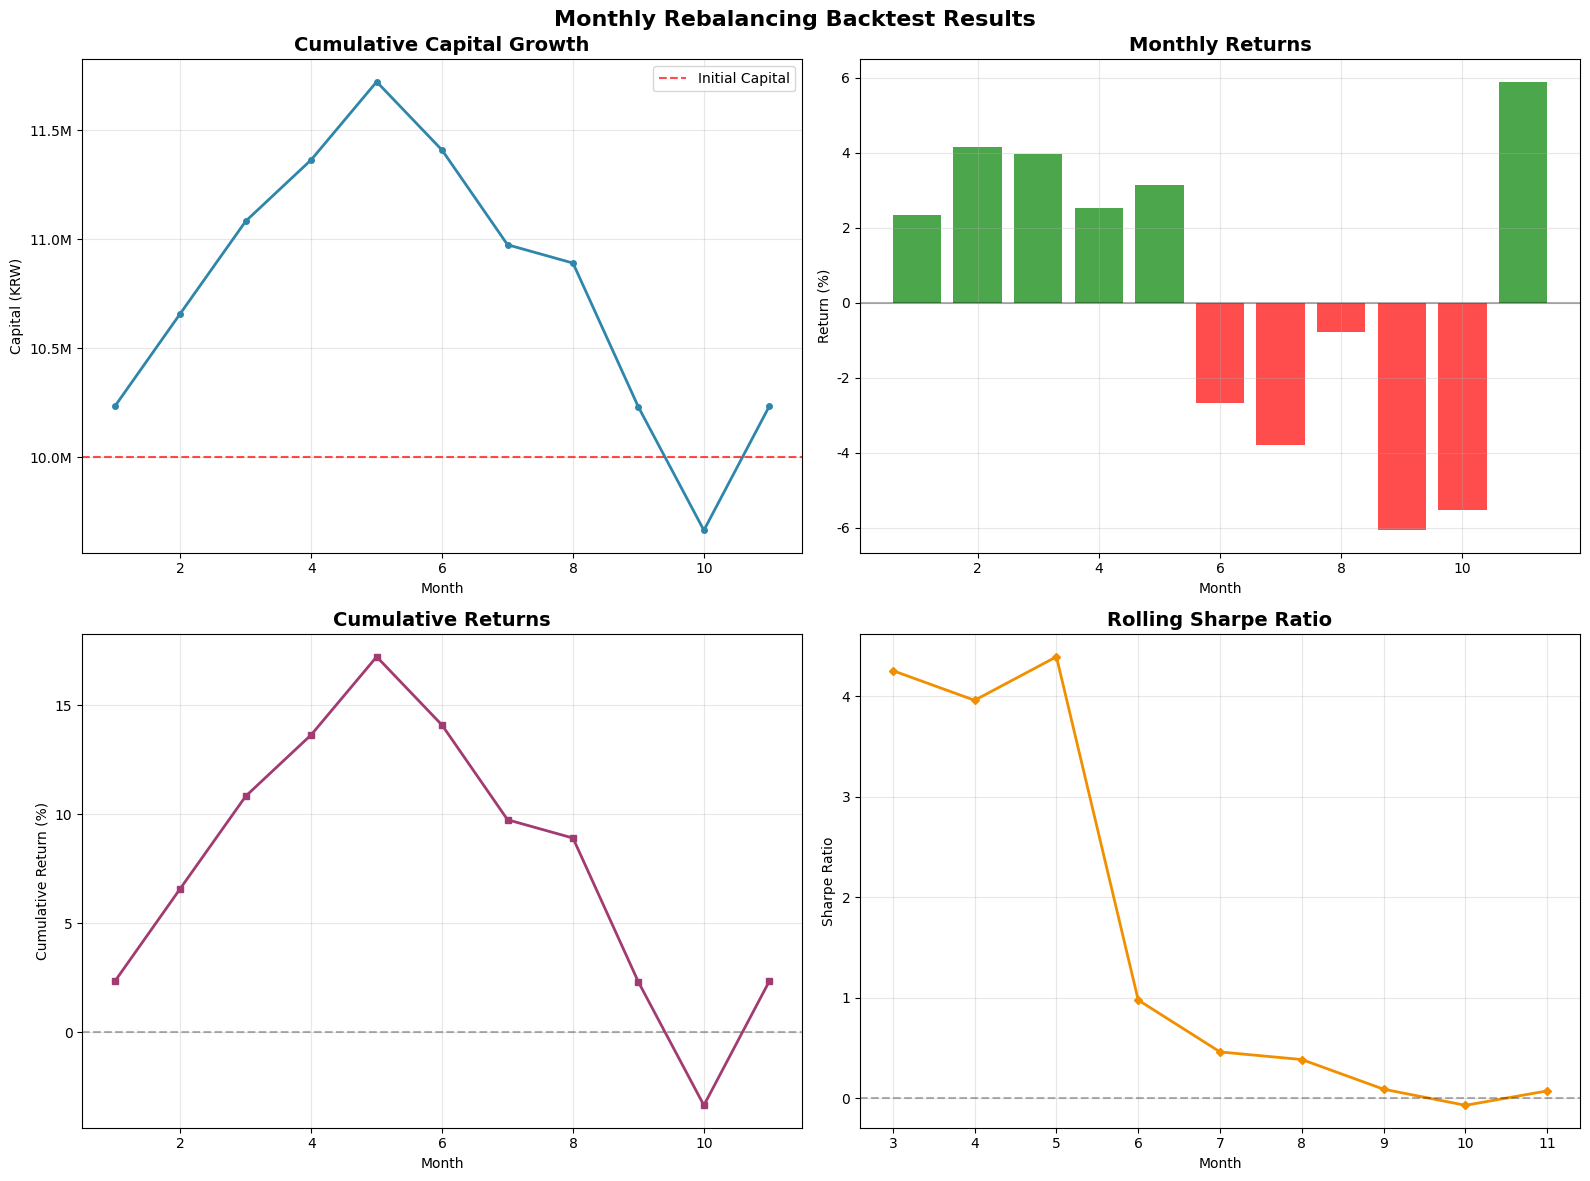


üìà PERFORMANCE SUMMARY
üí∞ Initial Capital: 10,000,000 KRW
üí∞ Final Capital: 10,233,973 KRW
üìä Total Return: +2.34%
üìÖ Investment Period: 11 months
üìà Average Monthly Return: 0.29%
üìâ Monthly Volatility: 4.03%
‚ö° Best Month: +5.89%
üí• Worst Month: -6.07%
üéØ Sharpe Ratio: 0.07
üìä Annualized Return: 3.56%
üìä Annualized Volatility: 13.94%
üìä Annualized Sharpe: 0.26


/Users/kknaks/git/quantus-test/.conda/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/kknaks/git/quantus-test/.conda/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/kknaks/git/quantus-test/.conda/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/kknaks/git/quantus-test/.conda/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/kknaks/git/quantus-test/.conda/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51061 (\N{HANGUL SYLLABLE IG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/kknaks/git/quantus-test/.con

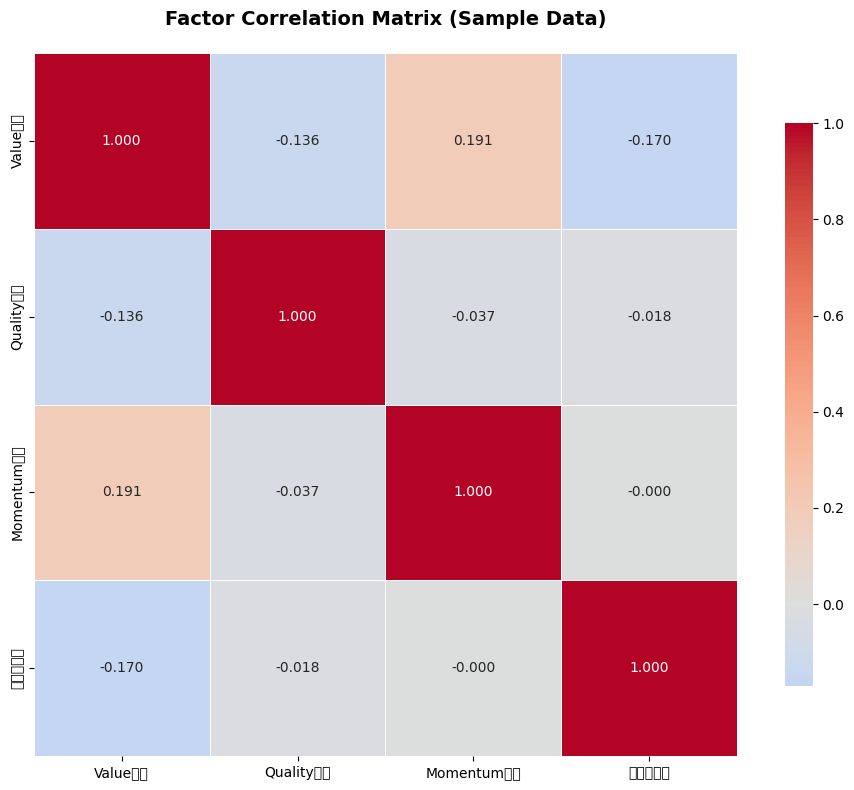

Î∞±ÌÖåÏä§Ìä∏ Í≤∞Í≥º ÏãúÍ∞ÅÌôî Ìï®ÏàòÍ∞Ä Ï§ÄÎπÑÎêòÏóàÏäµÎãàÎã§!

ÏÇ¨Ïö©Î≤ï:
1. plot_backtest_results(backtest_results) - Î∞±ÌÖåÏä§Ìä∏ Í≤∞Í≥º ÏãúÍ∞ÅÌôî
2. plot_factor_correlation(analysis_df) - Ìå©ÌÑ∞ ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÏãúÍ∞ÅÌôî


In [51]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
import pandas as pd

# ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

def plot_backtest_results(backtest_results, analysis_df=None):
    """
    Î∞±ÌÖåÏä§Ìä∏ Í≤∞Í≥ºÎ•º ÏãúÍ∞ÅÌôîÌïòÎäî Ìï®Ïàò
    
    Parameters:
    - backtest_results: run_monthly_rebalancing_backtest Ìï®ÏàòÏùò Í≤∞Í≥º
    - analysis_df: Ìå©ÌÑ∞ ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Î∂ÑÏÑùÏö© Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ
    """
    
    # 2x2 ÏÑúÎ∏åÌîåÎ°Ø ÏÉùÏÑ±
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Monthly Rebalancing Backtest Results', fontsize=16, fontweight='bold')
    
    # Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
    months = range(1, len(backtest_results['total_capital']))
    total_capitals = backtest_results['total_capital']
    monthly_returns = backtest_results['monthly_returns']
    cumulative_returns = backtest_results['cumulative_returns']
    
    # 1. ÎàÑÏ†Å ÏûêÎ≥∏ Í∑∏ÎûòÌîÑ
    axes[0, 0].plot(months, total_capitals[1:], linewidth=2, color='#2E86AB', marker='o', markersize=4)
    axes[0, 0].set_title('Cumulative Capital Growth', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Month')
    axes[0, 0].set_ylabel('Capital (KRW)')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
    
    # Ï¥àÍ∏∞ ÏûêÎ≥∏ Í∏∞Ï§ÄÏÑ† Ï∂îÍ∞Ä
    axes[0, 0].axhline(y=backtest_results['initial_capital'], color='red', linestyle='--', alpha=0.7, label='Initial Capital')
    axes[0, 0].legend()
    
    # 2. ÏõîÎ≥Ñ ÏàòÏùµÎ•† Í∑∏ÎûòÌîÑ
    colors = ['green' if x > 0 else 'red' for x in monthly_returns]
    axes[0, 1].bar(months, monthly_returns, color=colors, alpha=0.7)
    axes[0, 1].set_title('Monthly Returns', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Month')
    axes[0, 1].set_ylabel('Return (%)')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # 3. ÎàÑÏ†Å ÏàòÏùµÎ•† Í∑∏ÎûòÌîÑ
    axes[1, 0].plot(months, cumulative_returns, linewidth=2, color='#A23B72', marker='s', markersize=4)
    axes[1, 0].set_title('Cumulative Returns', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Month')
    axes[1, 0].set_ylabel('Cumulative Return (%)')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.3)
    
    # 4. ÏÉ§ÌîÑ ÎπÑÏú® Î∞è ÏÑ±Í≥º ÏßÄÌëú
    if monthly_returns:
        # ÏõîÎ≥Ñ Î°§ÎßÅ ÏÉ§ÌîÑ ÎπÑÏú® Í≥ÑÏÇ∞ (ÏµúÏÜå 3Í∞úÏõî Îç∞Ïù¥ÌÑ∞ ÌïÑÏöî)
        rolling_sharpe = []
        for i in range(len(monthly_returns)):
            if i >= 2:  # ÏµúÏÜå 3Í∞úÏõî Îç∞Ïù¥ÌÑ∞
                returns_subset = monthly_returns[:i+1]
                avg_return = np.mean(returns_subset)
                volatility = np.std(returns_subset)
                sharpe = avg_return / volatility if volatility > 0 else 0
                rolling_sharpe.append(sharpe)
        
        if rolling_sharpe:
            sharpe_months = range(3, len(monthly_returns) + 1)
            axes[1, 1].plot(sharpe_months, rolling_sharpe, linewidth=2, color='#F18F01', marker='D', markersize=4)
            axes[1, 1].set_title('Rolling Sharpe Ratio', fontsize=14, fontweight='bold')
            axes[1, 1].set_xlabel('Month')
            axes[1, 1].set_ylabel('Sharpe Ratio')
            axes[1, 1].grid(True, alpha=0.3)
            axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.3)
        else:
            axes[1, 1].text(0.5, 0.5, 'Insufficient data\nfor Sharpe calculation', 
                          ha='center', va='center', transform=axes[1, 1].transAxes, fontsize=12)
            axes[1, 1].set_title('Rolling Sharpe Ratio', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # ÏÑ±Í≥º ÏöîÏïΩ Ï∂úÎ†•
    print_performance_summary(backtest_results)


def plot_factor_correlation(analysis_df, top_stocks=None):
    """
    Ìå©ÌÑ∞Î≥Ñ ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÌûàÌä∏Îßµ Í∑∏Î¶¨Í∏∞
    
    Parameters:
    - analysis_df: Ï†ÑÏ≤¥ Î∂ÑÏÑù Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ
    - top_stocks: ÏÉÅÏúÑ Ï¢ÖÎ™© Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ (ÏóÜÏúºÎ©¥ Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ ÏÇ¨Ïö©)
    """
    
    plt.figure(figsize=(10, 8))
    
    # ÏÇ¨Ïö©Ìï† Îç∞Ïù¥ÌÑ∞ Í≤∞Ï†ï
    if top_stocks is not None and not top_stocks.empty:
        correlation_data = top_stocks[['ValueÏ†êÏàò', 'QualityÏ†êÏàò', 'MomentumÏ†êÏàò', 'Ïó∞Í∞ÑÏàòÏùµÎ•†']].corr()
        title = 'Factor Correlation Matrix (Top Stocks)'
    else:
        # analysis_dfÏóêÏÑú ÌïÑÏöîÌïú Ïª¨ÎüºÎì§Ïù¥ ÏûàÎäîÏßÄ ÌôïÏù∏
        required_columns = ['ValueÏ†êÏàò', 'QualityÏ†êÏàò', 'MomentumÏ†êÏàò', 'Ïó∞Í∞ÑÏàòÏùµÎ•†']
        available_columns = [col for col in required_columns if col in analysis_df.columns]
        
        if len(available_columns) >= 2:
            correlation_data = analysis_df[available_columns].corr()
            title = 'Factor Correlation Matrix (All Stocks)'
        else:
            # ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±
            np.random.seed(42)
            n_stocks = 100
            
            sample_data = pd.DataFrame({
                'ValueÏ†êÏàò': np.random.normal(0, 1, n_stocks),
                'QualityÏ†êÏàò': np.random.normal(0, 1, n_stocks),
                'MomentumÏ†êÏàò': np.random.normal(0, 1, n_stocks),
                'Ïó∞Í∞ÑÏàòÏùµÎ•†': np.random.normal(8, 15, n_stocks)
            })
            
            correlation_data = sample_data.corr()
            title = 'Factor Correlation Matrix (Sample Data)'
    
    # ÌûàÌä∏Îßµ Í∑∏Î¶¨Í∏∞
    sns.heatmap(correlation_data, 
                annot=True, 
                cmap='coolwarm', 
                center=0, 
                square=True,
                linewidths=0.5,
                cbar_kws={"shrink": .8},
                fmt='.3f')
    
    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()


def print_performance_summary(backtest_results):
    """
    Î∞±ÌÖåÏä§Ìä∏ ÏÑ±Í≥º ÏöîÏïΩ Ï∂úÎ†•
    """
    print("\n" + "="*60)
    print("üìà PERFORMANCE SUMMARY")
    print("="*60)
    
    initial_capital = backtest_results['initial_capital']
    final_capital = backtest_results['final_capital']
    total_return = backtest_results['total_return']
    monthly_returns = backtest_results['monthly_returns']
    
    print(f"üí∞ Initial Capital: {initial_capital:,} KRW")
    print(f"üí∞ Final Capital: {final_capital:,.0f} KRW")
    print(f"üìä Total Return: {total_return:+.2f}%")
    
    if monthly_returns:
        avg_monthly = np.mean(monthly_returns)
        volatility = np.std(monthly_returns)
        best_month = max(monthly_returns)
        worst_month = min(monthly_returns)
        
        print(f"üìÖ Investment Period: {len(monthly_returns)} months")
        print(f"üìà Average Monthly Return: {avg_monthly:.2f}%")
        print(f"üìâ Monthly Volatility: {volatility:.2f}%")
        print(f"‚ö° Best Month: {best_month:+.2f}%")
        print(f"üí• Worst Month: {worst_month:+.2f}%")
        
        if volatility > 0:
            sharpe_ratio = avg_monthly / volatility
            print(f"üéØ Sharpe Ratio: {sharpe_ratio:.2f}")
            
            # Ïó∞Ïú®Ìôî ÏßÄÌëú
            annual_return = (1 + avg_monthly/100)**12 - 1
            annual_volatility = volatility * np.sqrt(12)
            annual_sharpe = annual_return / (annual_volatility/100)
            
            print(f"üìä Annualized Return: {annual_return*100:.2f}%")
            print(f"üìä Annualized Volatility: {annual_volatility:.2f}%")
            print(f"üìä Annualized Sharpe: {annual_sharpe:.2f}")


# ÏÇ¨Ïö© ÏòàÏãú
if __name__ == "__main__":
    # Î∞±ÌÖåÏä§Ìä∏ Í≤∞Í≥ºÍ∞Ä ÏûàÎã§Î©¥ ÏãúÍ∞ÅÌôî Ïã§Ìñâ
    plot_backtest_results(backtest_results)
    
    # Ìå©ÌÑ∞ ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÏãúÍ∞ÅÌôî (analysis_dfÍ∞Ä ÏûàÎã§Î©¥)
    plot_factor_correlation(analysis_df)
    
    print("Î∞±ÌÖåÏä§Ìä∏ Í≤∞Í≥º ÏãúÍ∞ÅÌôî Ìï®ÏàòÍ∞Ä Ï§ÄÎπÑÎêòÏóàÏäµÎãàÎã§!")
    print("\nÏÇ¨Ïö©Î≤ï:")
    print("1. plot_backtest_results(backtest_results) - Î∞±ÌÖåÏä§Ìä∏ Í≤∞Í≥º ÏãúÍ∞ÅÌôî")
    print("2. plot_factor_correlation(analysis_df) - Ìå©ÌÑ∞ ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÏãúÍ∞ÅÌôî")

In [314]:
target_stock_name = analysis_df['Ï¢ÖÎ™©Î™Ö'].iloc[0]
excluded_metrics = ['PER', 'PBR']
df_stock = analysis_df[
    (analysis_df['Ï¢ÖÎ™©Î™Ö'] == target_stock_name) &
    (~analysis_df['Íµ¨Î∂Ñ'].isin(excluded_metrics))
].copy()

# 3.2. ÎÇ†Ïßú Ïª¨ÎüºÎ™Ö Ï∂îÏ∂ú
date_cols = [col for col in df_stock.columns if col not in ['Ï¢ÖÎ™©Î™Ö', 'Íµ¨Î∂Ñ']]

# 3.3. 'Íµ¨Î∂Ñ' Ïª¨ÎüºÏùÑ Ïù∏Îç±Ïä§Î°ú ÏÑ§Ï†ïÌïòÍ≥†, ÎÇ†Ïßú Ïª¨ÎüºÏùÑ ÌîºÎ≤ó (Ï†ÑÏπò)
df_pivot = df_stock.set_index('Íµ¨Î∂Ñ')[date_cols].T
df_pivot.columns.name = None
df_pivot.index.name = 'ÎÇ†Ïßú'

# ÎÇ†Ïßú Ïù∏Îç±Ïä§Î•º datetime ÌòïÏãùÏúºÎ°ú Î≥ÄÌôò
df_pivot.index = pd.to_datetime(df_pivot.index)

print(f"\nÏû¨Íµ¨Ï°∞ÌôîÎêú '{target_stock_name}' Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ (PER, PBR Ï†úÏô∏) head:")
print(df_pivot.head())
print("\ndf_pivot info:")
df_pivot.info()


Ïû¨Íµ¨Ï°∞ÌôîÎêú 'Ï†úÏù¥Ïä§ÏΩîÌôÄÎî©Ïä§' Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ (PER, PBR Ï†úÏô∏) head:
                Ï¢ÖÍ∞Ä        ROE        ROA     ÏòÅÏóÖÏù¥ÏùµÎ•†        Î∂ÄÏ±ÑÎπÑÏú®
ÎÇ†Ïßú                                                            
2024-01-02  1430.0 -38.864932 -19.087926 -15.07851  103.610031
2024-01-03  1477.0 -38.864932 -19.087926 -15.07851  103.610031
2024-01-04  1408.0 -38.864932 -19.087926 -15.07851  103.610031
2024-01-05  1401.0 -38.864932 -19.087926 -15.07851  103.610031
2024-01-08  1414.0 -38.864932 -19.087926 -15.07851  103.610031

df_pivot info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 244 entries, 2024-01-02 to 2024-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ï¢ÖÍ∞Ä      244 non-null    float64
 1   ROE     244 non-null    float64
 2   ROA     244 non-null    float64
 3   ÏòÅÏóÖÏù¥ÏùµÎ•†   244 non-null    float64
 4   Î∂ÄÏ±ÑÎπÑÏú®    244 non-null    float64
dtypes: float64(5)
memory usa

In [315]:
print("\nÍ≤∞Ï∏°Ïπò Ï≤òÎ¶¨ Ï†Ñ df_pivotÏùò Í≤∞Ï∏°Ïπò Í∞úÏàò:")
print(df_pivot.isnull().sum())

# 4.1. Î™®Îì† NaN Í∞íÏùÑ 0ÏúºÎ°ú ÎåÄÏ≤¥
df_filled_zero = df_pivot.fillna(0)

print("\nNaNÏùÑ 0ÏúºÎ°ú Ï±ÑÏö¥ ÌõÑ df_filled_zeroÏùò Í≤∞Ï∏°Ïπò Í∞úÏàò:")
print(df_filled_zero.isnull().sum()) # Î™®Îì† Í≤∞Ï∏°ÏπòÍ∞Ä 0Ïù¥ ÎêòÏóàÏùåÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§.
print("\nNaNÏùÑ 0ÏúºÎ°ú Ï±ÑÏö¥ ÌõÑ df_filled_zero head:")
print(df_filled_zero.head())
print("\ndf_filled_zero info:")
df_filled_zero.info()


Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨ Ï†Ñ df_pivotÏùò Í≤∞Ï∏°Ïπò Í∞úÏàò:
Ï¢ÖÍ∞Ä       0
ROE      0
ROA      0
ÏòÅÏóÖÏù¥ÏùµÎ•†    0
Î∂ÄÏ±ÑÎπÑÏú®     0
dtype: int64

NaNÏùÑ 0ÏúºÎ°ú Ï±ÑÏö¥ ÌõÑ df_filled_zeroÏùò Í≤∞Ï∏°Ïπò Í∞úÏàò:
Ï¢ÖÍ∞Ä       0
ROE      0
ROA      0
ÏòÅÏóÖÏù¥ÏùµÎ•†    0
Î∂ÄÏ±ÑÎπÑÏú®     0
dtype: int64

NaNÏùÑ 0ÏúºÎ°ú Ï±ÑÏö¥ ÌõÑ df_filled_zero head:
                Ï¢ÖÍ∞Ä        ROE        ROA     ÏòÅÏóÖÏù¥ÏùµÎ•†        Î∂ÄÏ±ÑÎπÑÏú®
ÎÇ†Ïßú                                                            
2024-01-02  1430.0 -38.864932 -19.087926 -15.07851  103.610031
2024-01-03  1477.0 -38.864932 -19.087926 -15.07851  103.610031
2024-01-04  1408.0 -38.864932 -19.087926 -15.07851  103.610031
2024-01-05  1401.0 -38.864932 -19.087926 -15.07851  103.610031
2024-01-08  1414.0 -38.864932 -19.087926 -15.07851  103.610031

df_filled_zero info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 244 entries, 2024-01-02 to 2024-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ---


ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Îß§Ìä∏Î¶≠Ïä§ (PER, PBR Ï†úÏô∏, NaNÏùÄ 0ÏúºÎ°ú Ï≤òÎ¶¨):
             Ï¢ÖÍ∞Ä       ROE       ROA     ÏòÅÏóÖÏù¥ÏùµÎ•†      Î∂ÄÏ±ÑÎπÑÏú®
Ï¢ÖÍ∞Ä     1.000000  0.270580  0.253226 -0.440476 -0.202563
ROE    0.270580  1.000000  0.999674 -0.917341 -0.988374
ROA    0.253226  0.999674  1.000000 -0.908697 -0.990979
ÏòÅÏóÖÏù¥ÏùµÎ•† -0.440476 -0.917341 -0.908697  1.000000  0.846506
Î∂ÄÏ±ÑÎπÑÏú®  -0.202563 -0.988374 -0.990979  0.846506  1.000000


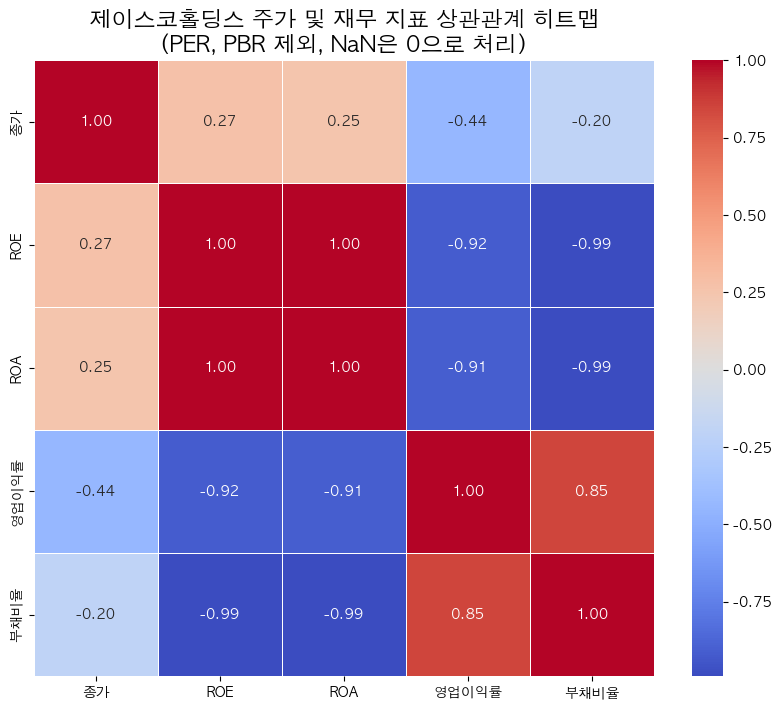

In [319]:
# 6.1. ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Îß§Ìä∏Î¶≠Ïä§ Í≥ÑÏÇ∞
# Ïù¥Ï†ú df_filled_zeroÎ•º ÏÇ¨Ïö©Ìï©ÎãàÎã§.
correlation_matrix = df_filled_zero.corr()

print("\nÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Îß§Ìä∏Î¶≠Ïä§ (PER, PBR Ï†úÏô∏, NaNÏùÄ 0ÏúºÎ°ú Ï≤òÎ¶¨):")
print(correlation_matrix)

# 6.2. Seaborn ÌûàÌä∏Îßµ Í∑∏Î¶¨Í∏∞
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            fmt=".2f",
            linewidths=.5)
plt.title(f'{target_stock_name} Ï£ºÍ∞Ä Î∞è Ïû¨Î¨¥ ÏßÄÌëú ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÌûàÌä∏Îßµ\n(PER, PBR Ï†úÏô∏, NaNÏùÄ 0ÏúºÎ°ú Ï≤òÎ¶¨)', fontsize=16)
plt.show()

In [320]:
# 3.1. 'Ï†úÏù¥ Ïä§ÏΩî ÌôÄÎî©Ïä§' Ï¢ÖÎ™© ÌïÑÌÑ∞ÎßÅ (PER, PBR Ìè¨Ìï®Îêú ÏõêÎ≥∏ ÏÉÅÌÉúÎ°ú)
target_stock_name = analysis_df['Ï¢ÖÎ™©Î™Ö'].iloc[0]
# Ïó¨Í∏∞ÏÑúÎäî Î™®Îì† ÏßÄÌëúÎ•º Í∞ÄÏ†∏ÏòµÎãàÎã§. (PER, PBR Ìè¨Ìï®)
df_stock_original = analysis_df[analysis_df['Ï¢ÖÎ™©Î™Ö'] == target_stock_name].copy()

# 3.2. ÎÇ†Ïßú Ïª¨ÎüºÎ™Ö Ï∂îÏ∂ú
date_cols_original = [col for col in df_stock_original.columns if col not in ['Ï¢ÖÎ™©Î™Ö', 'Íµ¨Î∂Ñ']]

# 3.3. 'Íµ¨Î∂Ñ' Ïª¨ÎüºÏùÑ Ïù∏Îç±Ïä§Î°ú ÏÑ§Ï†ïÌïòÍ≥†, ÎÇ†Ïßú Ïª¨ÎüºÏùÑ ÌîºÎ≤ó (Ï†ÑÏπò)
df_pivot_original = df_stock_original.set_index('Íµ¨Î∂Ñ')[date_cols_original].T
df_pivot_original.columns.name = None
df_pivot_original.index.name = 'ÎÇ†Ïßú'

# ÎÇ†Ïßú Ïù∏Îç±Ïä§Î•º datetime ÌòïÏãùÏúºÎ°ú Î≥ÄÌôò
df_pivot_original.index = pd.to_datetime(df_pivot_original.index)

print(f"\nÏû¨Íµ¨Ï°∞ÌôîÎêú '{target_stock_name}' Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ (Î™®Îì† ÏßÄÌëú Ìè¨Ìï®) head:")
print(df_pivot_original.head())
print("\ndf_pivot_original info:")
df_pivot_original.info()

print("\nÏòÅÏóÖÏù¥ÏùµÎ•† Ïª¨ÎüºÏùò Í≤∞Ï∏°Ïπò Í∞úÏàò (NaN Ï≤òÎ¶¨ Ï†Ñ):")
print(df_pivot_original['ÏòÅÏóÖÏù¥ÏùµÎ•†'].isnull().sum())
print("\nÏòÅÏóÖÏù¥ÏùµÎ•† Ïª¨ÎüºÏùò Í≥†Ïú† Í∞í (NaN Ìè¨Ìï®):")
print(df_pivot_original['ÏòÅÏóÖÏù¥ÏùµÎ•†'].unique())


Ïû¨Íµ¨Ï°∞ÌôîÎêú 'Ï†úÏù¥Ïä§ÏΩîÌôÄÎî©Ïä§' Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ (Î™®Îì† ÏßÄÌëú Ìè¨Ìï®) head:
                Ï¢ÖÍ∞Ä  PER       PBR        ROE        ROA     ÏòÅÏóÖÏù¥ÏùµÎ•†        Î∂ÄÏ±ÑÎπÑÏú®
ÎÇ†Ïßú                                                                           
2024-01-02  1430.0  NaN  1.400996 -38.864932 -19.087926 -15.07851  103.610031
2024-01-03  1477.0  NaN  1.447042 -38.864932 -19.087926 -15.07851  103.610031
2024-01-04  1408.0  NaN  1.379442 -38.864932 -19.087926 -15.07851  103.610031
2024-01-05  1401.0  NaN  1.372584 -38.864932 -19.087926 -15.07851  103.610031
2024-01-08  1414.0  NaN  1.385320 -38.864932 -19.087926 -15.07851  103.610031

df_pivot_original info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 244 entries, 2024-01-02 to 2024-12-30
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ï¢ÖÍ∞Ä      244 non-null    float64
 1   PER     60 non-null     float64
 2   PBR     244 non-null    float64
 3

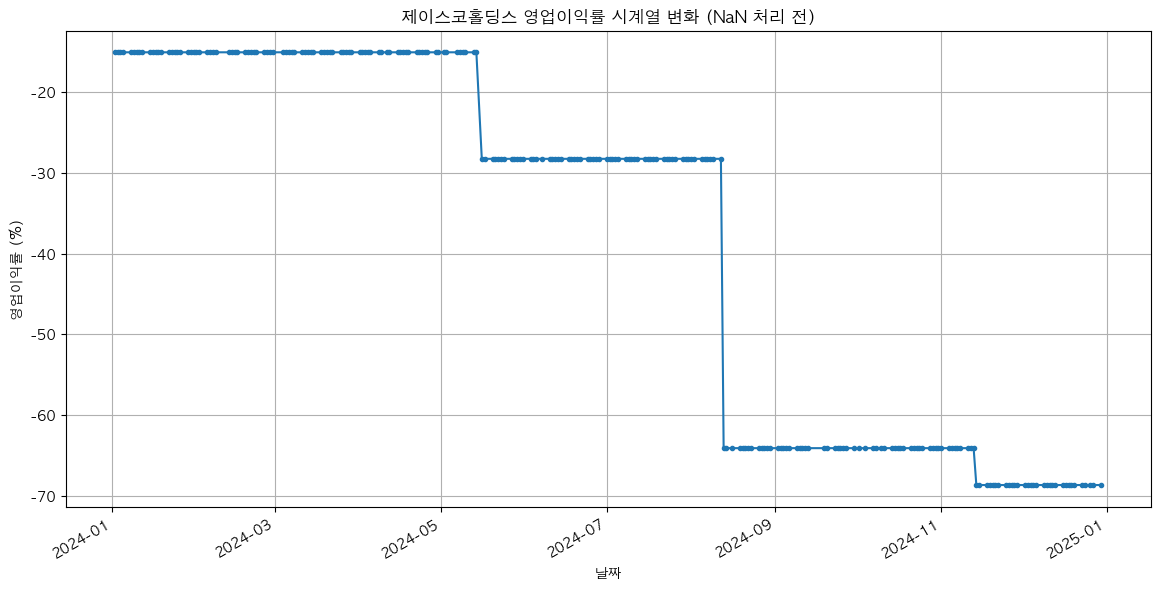

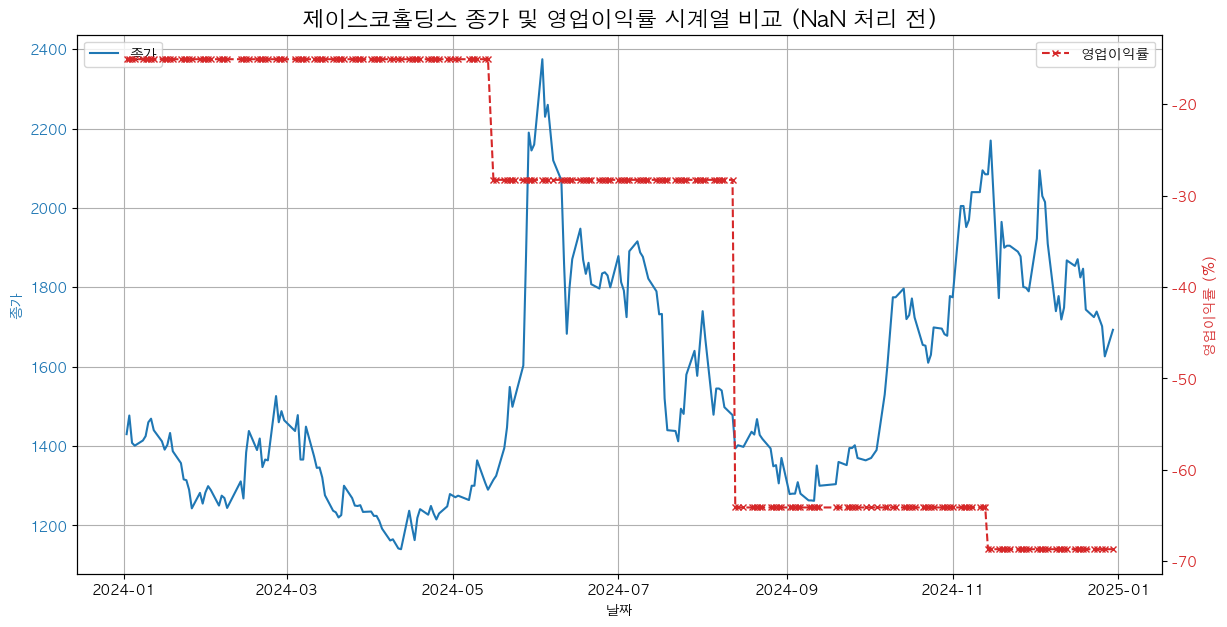

In [321]:
plt.figure(figsize=(14, 7))
# plot() Ìï®ÏàòÎäî NaN Í∞íÏùÑ ÏûêÎèôÏúºÎ°ú Í±¥ÎÑàÎõ∞Í≥† Í∑∏ÎûòÌîÑÎ•º Í∑∏Î¶ΩÎãàÎã§.
df_pivot_original['ÏòÅÏóÖÏù¥ÏùµÎ•†'].plot(title=f'{target_stock_name} ÏòÅÏóÖÏù¥ÏùµÎ•† ÏãúÍ≥ÑÏó¥ Î≥ÄÌôî (NaN Ï≤òÎ¶¨ Ï†Ñ)',
                                    grid=True,
                                    linestyle='-',
                                    marker='o', # Îç∞Ïù¥ÌÑ∞ Ìè¨Ïù∏Ìä∏ ÌëúÏãú
                                    markersize=3)
plt.ylabel('ÏòÅÏóÖÏù¥ÏùµÎ•† (%)')
plt.xlabel('ÎÇ†Ïßú')
plt.show()

# Ï∂îÍ∞ÄÏ†ÅÏúºÎ°ú, Ï¢ÖÍ∞ÄÏôÄ ÏòÅÏóÖÏù¥ÏùµÎ•†ÏùÑ Ìï®Íªò Í∑∏Î†§Î≥¥Îäî Í≤ÉÎèÑ Ï¢ãÏäµÎãàÎã§.
# Ï¢ÖÍ∞ÄÏùò Ïä§ÏºÄÏùºÏù¥ Îã§Î•¥ÎØÄÎ°ú, 2Í∞úÏùò YÏ∂ïÏùÑ ÏÇ¨Ïö©Ìï©ÎãàÎã§.
fig, ax1 = plt.subplots(figsize=(14, 7))

# Ï≤´ Î≤àÏß∏ YÏ∂ï: Ï¢ÖÍ∞Ä
color = 'tab:blue'
ax1.set_xlabel('ÎÇ†Ïßú')
ax1.set_ylabel('Ï¢ÖÍ∞Ä', color=color)
ax1.plot(df_pivot_original['Ï¢ÖÍ∞Ä'], color=color, label='Ï¢ÖÍ∞Ä', linestyle='-')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')
ax1.grid(True)

# Îëê Î≤àÏß∏ YÏ∂ï: ÏòÅÏóÖÏù¥ÏùµÎ•†
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('ÏòÅÏóÖÏù¥ÏùµÎ•† (%)', color=color)
ax2.plot(df_pivot_original['ÏòÅÏóÖÏù¥ÏùµÎ•†'], color=color, label='ÏòÅÏóÖÏù¥ÏùµÎ•†', linestyle='--', marker='x', markersize=4)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.title(f'{target_stock_name} Ï¢ÖÍ∞Ä Î∞è ÏòÅÏóÖÏù¥ÏùµÎ•† ÏãúÍ≥ÑÏó¥ ÎπÑÍµê (NaN Ï≤òÎ¶¨ Ï†Ñ)', fontsize=16)
plt.show()

In [322]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [323]:
# analysis_dfÍ∞Ä Ïù¥ÎØ∏ Î°úÎìúÎêòÏñ¥ ÏûàÎã§Í≥† Í∞ÄÏ†ïÌï©ÎãàÎã§.
# ÎßåÏïΩ Ïù¥ ÏÖÄÏóêÏÑú 'analysis_df is not defined' ÏóêÎü¨Í∞Ä Î∞úÏÉùÌïúÎã§Î©¥,
# Ïù¥Ï†Ñ ÎåÄÌôîÏóêÏÑú analysis_dfÎ•º Î°úÎìúÌïòÎäî ÏΩîÎìúÎ•º Îã§Ïãú Ïã§ÌñâÌï¥Ï£ºÏÑ∏Ïöî.
# Ïòà: analysis_df = pd.read_csv('your_data.csv')

# --- 'Ï†úÏù¥ Ïä§ÏΩî ÌôÄÎî©Ïä§' Îç∞Ïù¥ÌÑ∞ Ïû¨Íµ¨Ï°∞Ìôî Î∞è NaN 0 Ï≤òÎ¶¨ Í≥ºÏ†ï ---
# Ïù¥ Î∂ÄÎ∂ÑÏùÄ Ïù¥Ï†Ñ Îã®Í≥ÑÏóêÏÑú Ïù¥ÎØ∏ Ïã§ÌñâÌñàÏßÄÎßå, ÏΩîÎìúÏùò Ïó∞ÏÜçÏÑ±ÏùÑ ÏúÑÌï¥ Îã§Ïãú Î™ÖÏãúÌï©ÎãàÎã§.

target_stock_name = analysis_df['Ï¢ÖÎ™©Î™Ö'].iloc[0]
excluded_metrics = ['PER', 'PBR']

# 'Ï†úÏù¥ Ïä§ÏΩî ÌôÄÎî©Ïä§' Ï¢ÖÎ™© ÌïÑÌÑ∞ÎßÅ Î∞è PER, PBR Ï†úÏô∏
df_stock = analysis_df[
    (analysis_df['Ï¢ÖÎ™©Î™Ö'] == target_stock_name) &
    (~analysis_df['Íµ¨Î∂Ñ'].isin(excluded_metrics))
].copy()

# ÎÇ†Ïßú Ïª¨ÎüºÎ™Ö Ï∂îÏ∂ú
date_cols = [col for col in df_stock.columns if col not in ['Ï¢ÖÎ™©Î™Ö', 'Íµ¨Î∂Ñ']]

# 'Íµ¨Î∂Ñ' Ïª¨ÎüºÏùÑ Ïù∏Îç±Ïä§Î°ú ÏÑ§Ï†ïÌïòÍ≥†, ÎÇ†Ïßú Ïª¨ÎüºÏùÑ ÌîºÎ≤ó (Ï†ÑÏπò)
df_pivot = df_stock.set_index('Íµ¨Î∂Ñ')[date_cols].T
df_pivot.columns.name = None
df_pivot.index.name = 'ÎÇ†Ïßú'

# ÎÇ†Ïßú Ïù∏Îç±Ïä§Î•º datetime ÌòïÏãùÏúºÎ°ú Î≥ÄÌôò
df_pivot.index = pd.to_datetime(df_pivot.index)

# Î™®Îì† NaN Í∞íÏùÑ 0ÏúºÎ°ú ÎåÄÏ≤¥
df_filled_zero = df_pivot.fillna(0)

print("\nÌöåÍ∑Ä Î∂ÑÏÑùÏóê ÏÇ¨Ïö©Îê† 'Ï†úÏù¥ Ïä§ÏΩî ÌôÄÎî©Ïä§' Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ (df_filled_zero) head:")
print(df_filled_zero.head())
print("\ndf_filled_zero info:")
df_filled_zero.info()

# ÌäπÏßï(X)Í≥º ÌÉÄÍ≤ü(y) Î∂ÑÎ¶¨
X = df_filled_zero[['ROE', 'ROA', 'ÏòÅÏóÖÏù¥ÏùµÎ•†', 'Î∂ÄÏ±ÑÎπÑÏú®']]
y = df_filled_zero['Ï¢ÖÍ∞Ä']

print("\nFeatures (X) head:")
print(X.head())
print("\nTarget (y) head:")
print(y.head())


ÌöåÍ∑Ä Î∂ÑÏÑùÏóê ÏÇ¨Ïö©Îê† 'Ï†úÏù¥ Ïä§ÏΩî ÌôÄÎî©Ïä§' Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ (df_filled_zero) head:
                Ï¢ÖÍ∞Ä        ROE        ROA     ÏòÅÏóÖÏù¥ÏùµÎ•†        Î∂ÄÏ±ÑÎπÑÏú®
ÎÇ†Ïßú                                                            
2024-01-02  1430.0 -38.864932 -19.087926 -15.07851  103.610031
2024-01-03  1477.0 -38.864932 -19.087926 -15.07851  103.610031
2024-01-04  1408.0 -38.864932 -19.087926 -15.07851  103.610031
2024-01-05  1401.0 -38.864932 -19.087926 -15.07851  103.610031
2024-01-08  1414.0 -38.864932 -19.087926 -15.07851  103.610031

df_filled_zero info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 244 entries, 2024-01-02 to 2024-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ï¢ÖÍ∞Ä      244 non-null    float64
 1   ROE     244 non-null    float64
 2   ROA     244 non-null    float64
 3   ÏòÅÏóÖÏù¥ÏùµÎ•†   244 non-null    float64
 4   Î∂ÄÏ±ÑÎπÑÏú®    244 non-null    float64
dtypes: flo

In [324]:
# ÌõàÎ†® ÏÑ∏Ìä∏ÏôÄ ÌÖåÏä§Ìä∏ ÏÑ∏Ìä∏ ÎπÑÏú® ÏÑ§Ï†ï (Ïòà: 80% ÌõàÎ†®, 20% ÌÖåÏä§Ìä∏)
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"\nÌõàÎ†® ÏÑ∏Ìä∏ ÌÅ¨Í∏∞: {len(X_train)} Í∞ú")
print(f"ÌÖåÏä§Ìä∏ ÏÑ∏Ìä∏ ÌÅ¨Í∏∞: {len(X_test)} Í∞ú")


ÌõàÎ†® ÏÑ∏Ìä∏ ÌÅ¨Í∏∞: 195 Í∞ú
ÌÖåÏä§Ìä∏ ÏÑ∏Ìä∏ ÌÅ¨Í∏∞: 49 Í∞ú


In [325]:
scaler = StandardScaler()

# ÌõàÎ†® Îç∞Ïù¥ÌÑ∞Ïóê fit_transform Ï†ÅÏö©
X_train_scaled = scaler.fit_transform(X_train)
# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Ïóê transform Ï†ÅÏö© (ÌõàÎ†® Îç∞Ïù¥ÌÑ∞Ïùò Ïä§ÏºÄÏùºÎßÅ Í∏∞Ï§Ä ÏÇ¨Ïö©)
X_test_scaled = scaler.transform(X_test)

# Ïä§ÏºÄÏùºÎßÅÎêú Îç∞Ïù¥ÌÑ∞Î•º Îã§Ïãú DataFrameÏúºÎ°ú Î≥ÄÌôò (Î∂ÑÏÑù Ïö©Ïù¥ÏÑ±ÏùÑ ÏúÑÌï¥)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print("\nÏä§ÏºÄÏùºÎßÅÎêú ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ (X_train_scaled) head:")
print(X_train_scaled.head())


Ïä§ÏºÄÏùºÎßÅÎêú ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ (X_train_scaled) head:
                 ROE       ROA     ÏòÅÏóÖÏù¥ÏùµÎ•†      Î∂ÄÏ±ÑÎπÑÏú®
ÎÇ†Ïßú                                                
2024-01-02 -0.712841 -0.695838  0.790654  0.701335
2024-01-03 -0.712841 -0.695838  0.790654  0.701335
2024-01-04 -0.712841 -0.695838  0.790654  0.701335
2024-01-05 -0.712841 -0.695838  0.790654  0.701335
2024-01-08 -0.712841 -0.695838  0.790654  0.701335


In [326]:
model = LinearRegression()

# Î™®Îç∏ ÌïôÏäµ
model.fit(X_train_scaled, y_train)

print("\nÏÑ†Ìòï ÌöåÍ∑Ä Î™®Îç∏ ÌïôÏäµ ÏôÑÎ£å.")


ÏÑ†Ìòï ÌöåÍ∑Ä Î™®Îç∏ ÌïôÏäµ ÏôÑÎ£å.


In [327]:
# ÌÖåÏä§Ìä∏ ÏÑ∏Ìä∏Ïóê ÎåÄÌïú ÏòàÏ∏°
y_pred = model.predict(X_test_scaled)

# Î™®Îç∏ ÏÑ±Îä• ÌèâÍ∞Ä
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) # Root Mean Squared Error
r2 = r2_score(y_test, y_pred) # R-squared

print(f"\nÎ™®Îç∏ ÏÑ±Îä• ÌèâÍ∞Ä (ÌÖåÏä§Ìä∏ ÏÑ∏Ìä∏):")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2 Score): {r2:.2f}")

# ÌöåÍ∑Ä Í≥ÑÏàò ÌôïÏù∏ (Í∞Å ÏßÄÌëúÏùò ÏòÅÌñ•Î†•)
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
print("\nÍ∞Å ÏßÄÌëúÏùò ÌöåÍ∑Ä Í≥ÑÏàò:")
print(coefficients.sort_values(by='Coefficient', ascending=False))

# Ï†àÌé∏ (intercept) ÌôïÏù∏
print(f"\nÎ™®Îç∏ Ï†àÌé∏ (Intercept): {model.intercept_:.2f}")


Î™®Îç∏ ÏÑ±Îä• ÌèâÍ∞Ä (ÌÖåÏä§Ìä∏ ÏÑ∏Ìä∏):
Mean Squared Error (MSE): 3301959.92
Root Mean Squared Error (RMSE): 1817.13
R-squared (R2 Score): -156.54

Í∞Å ÏßÄÌëúÏùò ÌöåÍ∑Ä Í≥ÑÏàò:
  Feature  Coefficient
3    Î∂ÄÏ±ÑÎπÑÏú®   586.466465
0     ROE  -312.434876
1     ROA  -716.190362
2   ÏòÅÏóÖÏù¥ÏùµÎ•† -1640.353989

Î™®Îç∏ Ï†àÌé∏ (Intercept): 1477.58


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
/Users/kknaks/git/quantus-test/.conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kknaks/git/quantus-test/.conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
/Users/kknaks/git/quantus-test/.conda/lib/python3.11/site-

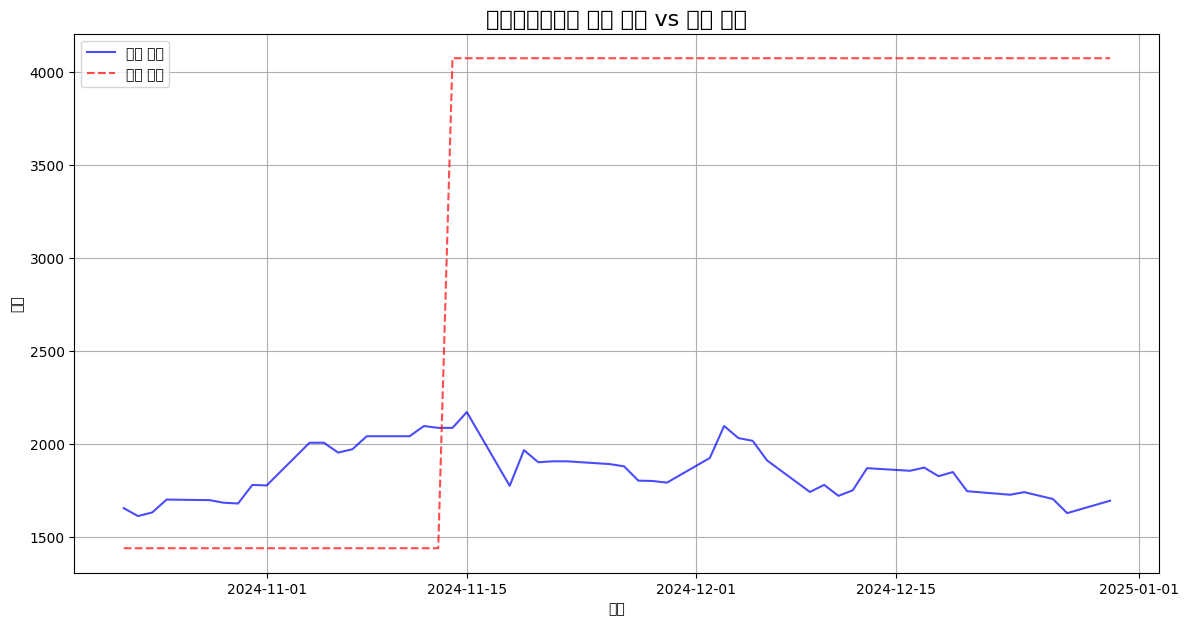

findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
/Users/kknaks/git/quantus-test/.conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kknaks/git/quantus-test/.conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: 

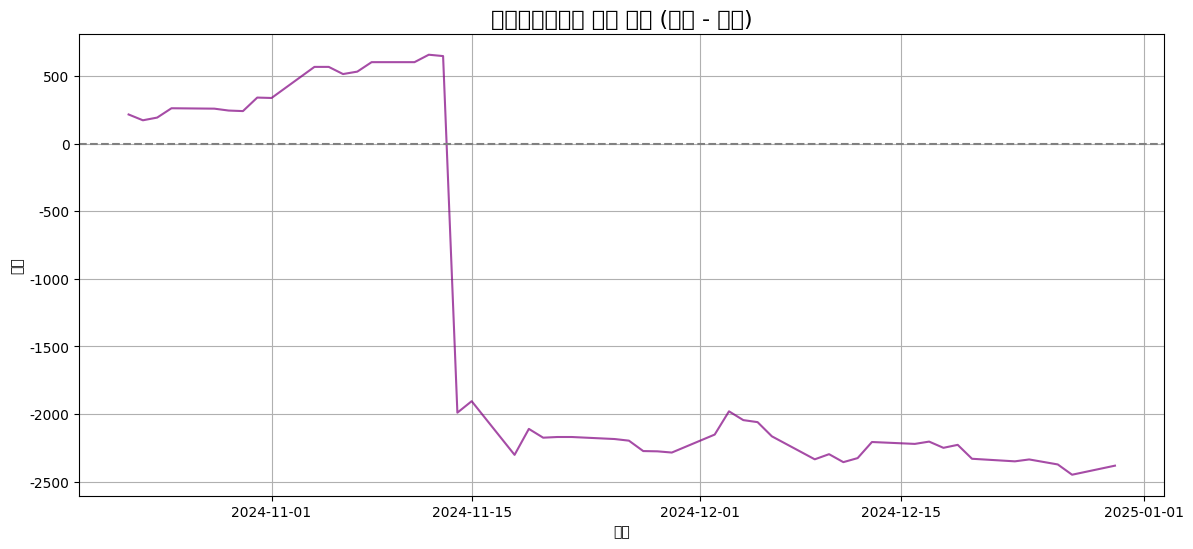

In [328]:
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Ïã§Ï†ú Ï¢ÖÍ∞Ä', color='blue', alpha=0.7)
plt.plot(y_test.index, y_pred, label='ÏòàÏ∏° Ï¢ÖÍ∞Ä', color='red', linestyle='--', alpha=0.7)
plt.title(f'{target_stock_name} Ïã§Ï†ú Ï¢ÖÍ∞Ä vs ÏòàÏ∏° Ï¢ÖÍ∞Ä', fontsize=16)
plt.xlabel('ÎÇ†Ïßú')
plt.ylabel('Ï¢ÖÍ∞Ä')
plt.legend()
plt.grid(True)
plt.show()

# ÏûîÏ∞®(Residual) Î∂ÑÏÑù
residuals = y_test - y_pred
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, residuals, color='purple', alpha=0.7)
plt.axhline(y=0, color='gray', linestyle='--')
plt.title(f'{target_stock_name} ÏòàÏ∏° ÏûîÏ∞® (Ïã§Ï†ú - ÏòàÏ∏°)', fontsize=16)
plt.xlabel('ÎÇ†Ïßú')
plt.ylabel('ÏûîÏ∞®')
plt.grid(True)
plt.show()

In [330]:
import pandas as pd
import numpy as np

# analysis_dfÍ∞Ä Ïù¥ÎØ∏ Î°úÎìúÎêòÏñ¥ ÏûàÎã§Í≥† Í∞ÄÏ†ïÌï©ÎãàÎã§.
# ÎßåÏïΩ Ïù¥ ÏÖÄÏóêÏÑú 'analysis_df is not defined' ÏóêÎü¨Í∞Ä Î∞úÏÉùÌïúÎã§Î©¥,
# Ïù¥Ï†Ñ ÎåÄÌôîÏóêÏÑú analysis_dfÎ•º Î°úÎìúÌïòÎäî ÏΩîÎìúÎ•º Îã§Ïãú Ïã§ÌñâÌï¥Ï£ºÏÑ∏Ïöî.
# Ïòà: analysis_df = pd.read_csv('your_data.csv')

# --- 1. analysis_dfÏùò ÎÇ†Ïßú Ïª¨ÎüºÏùÑ Î™®Îëê Ï∞æÍ∏∞ ---
# 'Ï¢ÖÎ™©Î™Ö'Í≥º 'Íµ¨Î∂Ñ'ÏùÑ Ï†úÏô∏Ìïú Î™®Îì† Ïª¨ÎüºÏù¥ ÎÇ†Ïßú Ïª¨ÎüºÏûÖÎãàÎã§.
date_cols = [col for col in analysis_df.columns if col not in ['Ï¢ÖÎ™©Î™Ö', 'Íµ¨Î∂Ñ']]

# --- 2. Long FormatÏúºÎ°ú Î≥ÄÌôò (stack) ---
# Î™®Îì† ÎÇ†Ïßú Ïª¨ÎüºÏùÑ ÌïòÎÇòÏùò 'ÎÇ†Ïßú' Ïª¨ÎüºÏúºÎ°ú ÏåìÏïÑ Ïò¨Î¶ΩÎãàÎã§.
df_long = analysis_df.set_index(['Ï¢ÖÎ™©Î™Ö', 'Íµ¨Î∂Ñ'])[date_cols].stack().reset_index()
df_long.columns = ['Ï¢ÖÎ™©Î™Ö', 'Íµ¨Î∂Ñ', 'ÎÇ†Ïßú', 'Í∞í'] # Ïª¨ÎüºÎ™Ö Î≥ÄÍ≤Ω

# 'ÎÇ†Ïßú' Ïª¨ÎüºÏùÑ datetime ÌòïÏãùÏúºÎ°ú Î≥ÄÌôò
df_long['ÎÇ†Ïßú'] = pd.to_datetime(df_long['ÎÇ†Ïßú'])

print("Long FormatÏúºÎ°ú Î≥ÄÌôòÎêú Îç∞Ïù¥ÌÑ∞ (df_long) head:")
print(df_long.head())
print("\ndf_long info:")
df_long.info()

# --- 3. Wide FormatÏúºÎ°ú Î≥ÄÌôò (unstack/pivot) ---
# 'Íµ¨Î∂Ñ' Ïª¨ÎüºÏùò Í∞í(Ï¢ÖÍ∞Ä, PER Îì±)ÏùÑ ÏÉàÎ°úÏö¥ Ïª¨ÎüºÏúºÎ°ú ÎßåÎì≠ÎãàÎã§.
# 'ÎÇ†Ïßú'ÏôÄ 'Ï¢ÖÎ™©Î™Ö'ÏùÑ Í∏∞Ï§ÄÏúºÎ°ú ÌîºÎ≤óÌï©ÎãàÎã§.
df_wide = df_long.pivot_table(index=['ÎÇ†Ïßú', 'Ï¢ÖÎ™©Î™Ö'], columns='Íµ¨Î∂Ñ', values='Í∞í')

# Ïª¨ÎüºÎ™Ö Ï†ïÎ¶¨
df_wide = df_wide.reset_index()
df_wide.columns.name = None # Ïª¨ÎüºÎ™Ö Ïù∏Îç±Ïä§ Ïù¥Î¶Ñ Ï†úÍ±∞

# Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Ïª¨Îüº ÏàúÏÑú Ï°∞Ï†ï (Î≥¥Í∏∞ Ï¢ãÍ≤å)
# Î™®Îì† ÏßÄÌëúÍ∞Ä Îã§ ÏûàÏùÑ Í≤ΩÏö∞Ïùò Ïª¨Îüº ÏàúÏÑú ÏßÄÏ†ï
all_metrics = ['Ï¢ÖÍ∞Ä', 'PER', 'PBR', 'ROE', 'ROA', 'ÏòÅÏóÖÏù¥ÏùµÎ•†', 'Î∂ÄÏ±ÑÎπÑÏú®']
# Ïã§Ï†ú df_wideÏóê ÏûàÎäî Ïª¨ÎüºÎßå ÏÇ¨Ïö©ÌïòÏó¨ ÏàúÏÑú Ï°∞Ï†ï
ordered_cols = ['ÎÇ†Ïßú', 'Ï¢ÖÎ™©Î™Ö'] + [metric for metric in all_metrics if metric in df_wide.columns]
df_wide = df_wide[ordered_cols]

print("\nWide FormatÏúºÎ°ú Ïû¨Íµ¨Ï°∞ÌôîÎêú Îç∞Ïù¥ÌÑ∞ (df_wide) head:")
print(df_wide.head())
print("\ndf_wide info:")
df_wide.info()

# --- 4. PER, PBR Ïª¨Îüº Ï†úÏô∏ Î∞è NaN 0 Ï≤òÎ¶¨ ---
# Ïù¥Ï†ú Î™®Îì† Ï¢ÖÎ™©Ïóê ÎåÄÌï¥ ÏùºÍ¥ÑÏ†ÅÏúºÎ°ú Ï†ÅÏö©Ìï©ÎãàÎã§.
# Ï†úÏô∏Ìï† ÏßÄÌëú Î¶¨Ïä§Ìä∏
metrics_to_exclude = ['PER', 'PBR']

# Ìï¥Îãπ ÏßÄÌëú Ïª¨ÎüºÏù¥ Ï°¥Ïû¨ÌïòÎ©¥ Ï†úÏô∏
for metric in metrics_to_exclude:
    if metric in df_wide.columns:
        df_wide = df_wide.drop(columns=[metric])
        print(f"'{metric}' Ïª¨ÎüºÏù¥ Ï†úÍ±∞ÎêòÏóàÏäµÎãàÎã§.")

# ÎÇòÎ®∏ÏßÄ Î™®Îì† Ïà´Ïûê Ïª¨ÎüºÏóê ÎåÄÌï¥ NaN Í∞íÏùÑ 0ÏúºÎ°ú Ï±ÑÏõÅÎãàÎã§.
# 'ÎÇ†Ïßú'ÏôÄ 'Ï¢ÖÎ™©Î™Ö' Ïª¨ÎüºÏùÄ Ï†úÏô∏ÌïòÍ≥† Ïà´ÏûêÌòï Ïª¨ÎüºÏóêÎßå Ï†ÅÏö©
numeric_cols = df_wide.select_dtypes(include=np.number).columns
df_final = df_wide.copy() # ÏõêÎ≥∏ Î≥¥Ï°¥ÏùÑ ÏúÑÌï¥ Î≥µÏÇ¨Î≥∏ ÏÉùÏÑ±
df_final[numeric_cols] = df_final[numeric_cols].fillna(0)

print("\nPER, PBR Ï†úÏô∏ Î∞è NaN 0 Ï≤òÎ¶¨ ÌõÑ ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ (df_final) head:")
print(df_final.head())
print("\ndf_final info:")
df_final.info()
print("\ndf_finalÏùò Í≤∞Ï∏°Ïπò ÌôïÏù∏:")
print(df_final.isnull().sum())
df_final

Long FormatÏúºÎ°ú Î≥ÄÌôòÎêú Îç∞Ïù¥ÌÑ∞ (df_long) head:
       Ï¢ÖÎ™©Î™Ö  Íµ¨Î∂Ñ         ÎÇ†Ïßú       Í∞í
0  Ï†úÏù¥Ïä§ÏΩîÌôÄÎî©Ïä§  Ï¢ÖÍ∞Ä 2024-01-02  1430.0
1  Ï†úÏù¥Ïä§ÏΩîÌôÄÎî©Ïä§  Ï¢ÖÍ∞Ä 2024-01-03  1477.0
2  Ï†úÏù¥Ïä§ÏΩîÌôÄÎî©Ïä§  Ï¢ÖÍ∞Ä 2024-01-04  1408.0
3  Ï†úÏù¥Ïä§ÏΩîÌôÄÎî©Ïä§  Ï¢ÖÍ∞Ä 2024-01-05  1401.0
4  Ï†úÏù¥Ïä§ÏΩîÌôÄÎî©Ïä§  Ï¢ÖÍ∞Ä 2024-01-08  1414.0

df_long info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212936 entries, 0 to 212935
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Ï¢ÖÎ™©Î™Ö     212936 non-null  object        
 1   Íµ¨Î∂Ñ      212936 non-null  object        
 2   ÎÇ†Ïßú      212936 non-null  datetime64[ns]
 3   Í∞í       212936 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 6.5+ MB

Wide FormatÏúºÎ°ú Ïû¨Íµ¨Ï°∞ÌôîÎêú Îç∞Ïù¥ÌÑ∞ (df_wide) head:
          ÎÇ†Ïßú      Ï¢ÖÎ™©Î™Ö       Ï¢ÖÍ∞Ä        PER       PBR        ROE        ROA  \
0 

ÎÇ†Ïßú      Ï¢ÖÎ™©Î™Ö       Ï¢ÖÍ∞Ä        ROE        ROA      ÏòÅÏóÖÏù¥ÏùµÎ•†  \
0     2024-01-02   CJ CGV   5900.0 -23.737762  -7.604703   1.107799   
1     2024-01-02    CJÏî®Ìë∏Îìú   2920.0   5.506881   3.102180   2.790275   
2     2024-01-02  DGBÍ∏àÏúµÏßÄÏ£º   8410.0   5.416470   4.086800   0.000000   
3     2024-01-02     DIÎèôÏùº  28500.0   2.237577   1.540144   0.282837   
4     2024-01-02      GST  27750.0  19.431283  16.625184  16.140677   
...          ...      ...      ...        ...        ...        ...   
32691 2024-12-30     ÌôîÏäπÏù∏Îçî   4450.0   2.673919   1.372287   2.218714   
32692 2024-12-30      Ìú¥ÎãàÎìú   7710.0   3.304813   2.132344   6.741814   
32693 2024-12-30     Ìú¥Î©îÎîïÏä§  42250.0   4.197535   3.859098  24.748460   
32694 2024-12-30     Ìù•Íµ¨ÏÑùÏú†  12490.0   0.678986   0.585999   0.639497   
32695 2024-12-30     Ìù•Íµ≠ÌôîÏû¨   3670.0  15.801465   1.152345   0.000000   

              Î∂ÄÏ±ÑÎπÑÏú®  
0       212.145826  
1        77.516472  
2        32.535720  
3        45.283650  
4        16.878605  
...            ...  
32691    94.851288  
32692    54.984981  
32693     8.769847  
32694    15.868206  
32695  1271.244823  

[32696 rows x 7 columns]

In [331]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [332]:
# df_final Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏù¥ Ïù¥ÎØ∏ Î©îÎ™®Î¶¨Ïóê ÏûàÎã§Í≥† Í∞ÄÏ†ïÌï©ÎãàÎã§.
# ÎßåÏïΩ Ïù¥ ÏÖÄÏóêÏÑú 'df_final is not defined' ÏóêÎü¨Í∞Ä Î∞úÏÉùÌïúÎã§Î©¥,
# Ïù¥Ï†Ñ ÎåÄÌôîÏóêÏÑú df_finalÏùÑ ÏÉùÏÑ±ÌïòÎäî ÏΩîÎìúÎ•º Îã§Ïãú Ïã§ÌñâÌï¥Ï£ºÏÑ∏Ïöî.
# (Îã®Í≥Ñ 1: Îç∞Ïù¥ÌÑ∞ Ïû¨Íµ¨Ï°∞Ìôî Î∂ÄÎ∂Ñ)
print("Ï¢ÖÎ™©Î≥Ñ ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Î∂ÑÏÑùÏùÑ ÏúÑÌïú df_final head:")
print(df_final.head())
print("\ndf_final info:")
df_final.info()

Ï¢ÖÎ™©Î≥Ñ ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Î∂ÑÏÑùÏùÑ ÏúÑÌïú df_final head:
          ÎÇ†Ïßú      Ï¢ÖÎ™©Î™Ö       Ï¢ÖÍ∞Ä        ROE        ROA      ÏòÅÏóÖÏù¥ÏùµÎ•†        Î∂ÄÏ±ÑÎπÑÏú®
0 2024-01-02   CJ CGV   5900.0 -23.737762  -7.604703   1.107799  212.145826
1 2024-01-02    CJÏî®Ìë∏Îìú   2920.0   5.506881   3.102180   2.790275   77.516472
2 2024-01-02  DGBÍ∏àÏúµÏßÄÏ£º   8410.0   5.416470   4.086800   0.000000   32.535720
3 2024-01-02     DIÎèôÏùº  28500.0   2.237577   1.540144   0.282837   45.283650
4 2024-01-02      GST  27750.0  19.431283  16.625184  16.140677   16.878605

df_final info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32696 entries, 0 to 32695
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ÎÇ†Ïßú      32696 non-null  datetime64[ns]
 1   Ï¢ÖÎ™©Î™Ö     32696 non-null  object        
 2   Ï¢ÖÍ∞Ä      32696 non-null  float64       
 3   ROE     32696 non-null  float64       
 4   ROA     32696 non-null  float64 

In [333]:
all_stocks = df_final['Ï¢ÖÎ™©Î™Ö'].unique()
print(f"\nÎ∂ÑÏÑùÌï† Ï¥ù Ï¢ÖÎ™© Ïàò: {len(all_stocks)}")
print(f"Î∂ÑÏÑùÌï† Ï¢ÖÎ™© Î¶¨Ïä§Ìä∏: {all_stocks[:5]} ... (ÏùºÎ∂ÄÎßå ÌëúÏãú)") # ÎÑàÎ¨¥ ÎßéÏúºÎ©¥ ÏùºÎ∂ÄÎßå Ï∂úÎ†•


Î∂ÑÏÑùÌï† Ï¥ù Ï¢ÖÎ™© Ïàò: 134
Î∂ÑÏÑùÌï† Ï¢ÖÎ™© Î¶¨Ïä§Ìä∏: ['CJ CGV' 'CJÏî®Ìë∏Îìú' 'DGBÍ∏àÏúµÏßÄÏ£º' 'DIÎèôÏùº' 'GST'] ... (ÏùºÎ∂ÄÎßå ÌëúÏãú)



Î™®Îì† Ï¢ÖÎ™©Ïùò 'Ï¢ÖÍ∞Ä'ÏôÄ Ïû¨Î¨¥ ÏßÄÌëú Í∞Ñ ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÏöîÏïΩ (df_correlations):
              ROE       ROA     ÏòÅÏóÖÏù¥ÏùµÎ•†      Î∂ÄÏ±ÑÎπÑÏú®
Ï¢ÖÎ™©Î™Ö                                            
CJ CGV   0.123979  0.131485  0.101368 -0.169293
CJÏî®Ìë∏Îìú    0.382087  0.382364  0.072856  0.201170
DGBÍ∏àÏúµÏßÄÏ£º  0.382986  0.381847       NaN -0.418849
DIÎèôÏùº    -0.595786 -0.599495 -0.076860 -0.032618
GST      0.731868  0.730299 -0.370937 -0.323995

Ï¥ù 134Í∞ú Ï¢ÖÎ™©Ïùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÍ∞Ä Í≥ÑÏÇ∞ÎêòÏóàÏäµÎãàÎã§.


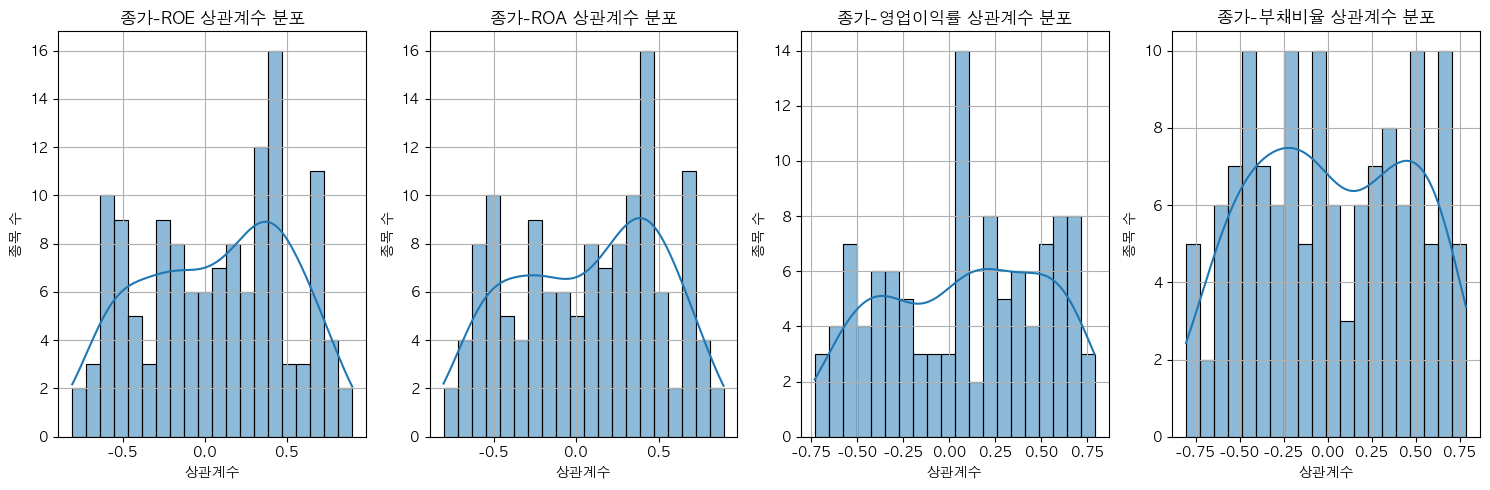

In [336]:
# ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Í≤∞Í≥ºÎ•º Ï†ÄÏû•Ìï† ÎîïÏÖîÎÑàÎ¶¨
correlation_results = {}

# Î∂ÑÏÑùÌï† ÏßÄÌëúÎì§ (Ï¢ÖÍ∞ÄÎ•º Ï†úÏô∏Ìïú ÌäπÏßï ÏßÄÌëú)
features = ['ROE', 'ROA', 'ÏòÅÏóÖÏù¥ÏùµÎ•†', 'Î∂ÄÏ±ÑÎπÑÏú®']
target = 'Ï¢ÖÍ∞Ä'

# Í∞Å Ï¢ÖÎ™©Î≥ÑÎ°ú Î∞òÎ≥µ
for stock_name in all_stocks:
    # Ìï¥Îãπ Ï¢ÖÎ™©Ïùò Îç∞Ïù¥ÌÑ∞Îßå ÌïÑÌÑ∞ÎßÅ
    df_stock = df_final[df_final['Ï¢ÖÎ™©Î™Ö'] == stock_name].copy()

    # ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Í≥ÑÏÇ∞ÏùÑ ÏúÑÌïú Ïà´ÏûêÌòï Ïª¨ÎüºÎßå ÏÑ†ÌÉù
    # Ï¢ÖÍ∞ÄÏôÄ ÌäπÏßï ÏßÄÌëúÍ∞Ä Î™®Îëê ÏûàÎäîÏßÄ ÌôïÏù∏ (Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨ ÌõÑ Îç∞Ïù¥ÌÑ∞Í∞Ä Î∂ÄÏ°±Ìï† Ïàò ÏûàÏùå)
    cols_for_corr = [target] + [f for f in features if f in df_stock.columns]

    if len(df_stock) > 1 and all(col in df_stock.columns for col in cols_for_corr): # Îç∞Ïù¥ÌÑ∞Í∞Ä ÏµúÏÜå 2Í∞ú Ïù¥ÏÉÅÏù¥Í≥† ÌïÑÏöîÌïú Ïª¨ÎüºÏù¥ ÏûàÎäîÏßÄ ÌôïÏù∏
        # ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Îß§Ìä∏Î¶≠Ïä§ Í≥ÑÏÇ∞
        corr_matrix = df_stock[cols_for_corr].corr()

        # 'Ï¢ÖÍ∞Ä'ÏôÄ Í∞Å ÏßÄÌëú Í∞ÑÏùò ÏÉÅÍ¥ÄÍ≥ÑÏàòÎßå Ï∂îÏ∂ú
        if target in corr_matrix.index and len(corr_matrix.columns) > 1:
            stock_corr = corr_matrix.loc[target, features].to_dict()
            correlation_results[stock_name] = stock_corr
        else:
            print(f"Ï£ºÏùò: '{stock_name}' Ï¢ÖÎ™©ÏùÄ ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÎ•º Í≥ÑÏÇ∞ÌïòÍ∏∞Ïóê Ï∂©Î∂ÑÌïú Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÍ±∞ÎÇò, 'Ï¢ÖÍ∞Ä' Ïª¨ÎüºÏù¥ ÏóÜÏäµÎãàÎã§. Í±¥ÎÑàÎúÅÎãàÎã§.")
    else:
        print(f"Ï£ºÏùò: '{stock_name}' Ï¢ÖÎ™©ÏùÄ Îç∞Ïù¥ÌÑ∞ Ìè¨Ïù∏Ìä∏Í∞Ä Î∂ÄÏ°±ÌïòÏó¨ ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÎ•º Í≥ÑÏÇ∞Ìï† Ïàò ÏóÜÏäµÎãàÎã§. (Îç∞Ïù¥ÌÑ∞ Ïàò: {len(df_stock)})")

# Í≤∞Í≥ºÎ•º DataFrameÏúºÎ°ú Î≥ÄÌôòÌïòÏó¨ Î≥¥Í∏∞ ÏâΩÍ≤å ÎßåÎì≠ÎãàÎã§.
df_correlations = pd.DataFrame.from_dict(correlation_results, orient='index')
df_correlations.index.name = 'Ï¢ÖÎ™©Î™Ö'

print("\nÎ™®Îì† Ï¢ÖÎ™©Ïùò 'Ï¢ÖÍ∞Ä'ÏôÄ Ïû¨Î¨¥ ÏßÄÌëú Í∞Ñ ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÏöîÏïΩ (df_correlations):")
print(df_correlations.head())
print(f"\nÏ¥ù {len(df_correlations)}Í∞ú Ï¢ÖÎ™©Ïùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÍ∞Ä Í≥ÑÏÇ∞ÎêòÏóàÏäµÎãàÎã§.")

# Í∞Å ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Î∂ÑÌè¨Î•º ÏãúÍ∞ÅÌôîÌïòÏó¨ ÎåÄÎûµÏ†ÅÏù∏ Í≤ΩÌñ• ÌååÏïÖ (ÏÑ†ÌÉù ÏÇ¨Ìï≠)
plt.figure(figsize=(15, 5))
for i, feature in enumerate(features):
    plt.subplot(1, len(features), i + 1)
    sns.histplot(df_correlations[feature].dropna(), bins=20, kde=True)
    plt.title(f'Ï¢ÖÍ∞Ä-{feature} ÏÉÅÍ¥ÄÍ≥ÑÏàò Î∂ÑÌè¨')
    plt.xlabel('ÏÉÅÍ¥ÄÍ≥ÑÏàò')
    plt.ylabel('Ï¢ÖÎ™© Ïàò')
    plt.grid(True)
plt.tight_layout()
plt.show()

In [337]:
# Ïã†Î¢∞ Ï¢ÖÎ™©ÏùÑ Ï∂îÏ∂úÌï† Í∏∞Ï§Ä Ï†ïÏùò
# Ïó¨Í∏∞ÏÑúÎäî ÏòàÏãúÎ°ú 'ROE'ÏôÄ 'Ï¢ÖÍ∞Ä'Ïùò ÏÉÅÍ¥ÄÍ≥ÑÏàòÍ∞Ä ÌäπÏ†ï Í∞í Ïù¥ÏÉÅÏù∏ Í≤ΩÏö∞Î•º Í∏∞Ï§ÄÏúºÎ°ú Ìï©ÎãàÎã§.
# Ïó¨Îü¨ ÏßÄÌëúÎ•º Ï°∞Ìï©ÌïòÏó¨ Î≥µÌï©Ï†ÅÏù∏ Í∏∞Ï§ÄÏùÑ ÎßåÎì§ ÏàòÎèÑ ÏûàÏäµÎãàÎã§.

# ÏòàÏãú Í∏∞Ï§Ä: Ï¢ÖÍ∞ÄÏôÄ ROE Í∞ÑÏùò ÏÉÅÍ¥ÄÍ≥ÑÏàòÍ∞Ä 0.3 Ïù¥ÏÉÅÏù∏ Ï¢ÖÎ™©
# (0.3ÏùÄ ÏûÑÏùòÏùò Í∞íÏù¥Î©∞, Ïã§Ï†ú Î∂ÑÏÑùÏóêÏÑú Ï°∞Ï†ï ÌïÑÏöî)
threshold_roe_corr = 0.3
reliable_stocks_roe = df_correlations[
    (df_correlations['ROE'].abs() >= threshold_roe_corr) & # ÏÉÅÍ¥ÄÍ≥ÑÏàò Ï†àÎåÄÍ∞íÏù¥ ÏûÑÍ≥ÑÍ∞í Ïù¥ÏÉÅ
    (df_correlations['ROE'] > 0) # ÏñëÏùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÎßå Í≥†Î†§Ìï† Í≤ΩÏö∞
].copy()

# ÏòàÏãú Í∏∞Ï§Ä: Ï¢ÖÍ∞ÄÏôÄ ÏòÅÏóÖÏù¥ÏùµÎ•† Í∞ÑÏùò ÏÉÅÍ¥ÄÍ≥ÑÏàòÍ∞Ä -0.4 Ïù¥ÌïòÏù∏ Ï¢ÖÎ™© (ÏùåÏùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÍ∞Ä Í∞ïÌïú Ï¢ÖÎ™©)
threshold_op_profit_corr = -0.4
reliable_stocks_op_profit = df_correlations[
    (df_correlations['ÏòÅÏóÖÏù¥ÏùµÎ•†'].abs() >= abs(threshold_op_profit_corr)) &
    (df_correlations['ÏòÅÏóÖÏù¥ÏùµÎ•†'] < 0) # ÏùåÏùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÎßå Í≥†Î†§Ìï† Í≤ΩÏö∞
].copy()

# Î™®Îì† Í∏∞Ï§ÄÏùÑ ÎßåÏ°±ÌïòÎäî Ï¢ÖÎ™© (AND Ï°∞Í±¥)
# Ïòà: ROE ÏÉÅÍ¥ÄÍ≥ÑÏàò 0.3 Ïù¥ÏÉÅ AND Î∂ÄÏ±ÑÎπÑÏú® ÏÉÅÍ¥ÄÍ≥ÑÏàò -0.2 Ïù¥ÌïòÏù∏ Ï¢ÖÎ™©
threshold_debt_ratio_corr = -0.2
highly_reliable_stocks = df_correlations[
    (df_correlations['ROE'] >= threshold_roe_corr) &
    (df_correlations['Î∂ÄÏ±ÑÎπÑÏú®'] <= threshold_debt_ratio_corr)
].copy()


print(f"\nÏã†Î¢∞ÎèÑ Í∏∞Ï§Ä 1 (Ï¢ÖÍ∞Ä-ROE ÏÉÅÍ¥ÄÍ≥ÑÏàò >= {threshold_roe_corr}) ÎßåÏ°± Ï¢ÖÎ™©:")
print(reliable_stocks_roe)
print(f"\nÏã†Î¢∞ÎèÑ Í∏∞Ï§Ä 2 (Ï¢ÖÍ∞Ä-ÏòÅÏóÖÏù¥ÏùµÎ•† ÏÉÅÍ¥ÄÍ≥ÑÏàò <= {threshold_op_profit_corr}) ÎßåÏ°± Ï¢ÖÎ™©:")
print(reliable_stocks_op_profit)
print(f"\nÏã†Î¢∞ÎèÑ Í∏∞Ï§Ä 3 (Ï¢ÖÍ∞Ä-ROE ÏÉÅÍ¥ÄÍ≥ÑÏàò >= {threshold_roe_corr} AND Ï¢ÖÍ∞Ä-Î∂ÄÏ±ÑÎπÑÏú® ÏÉÅÍ¥ÄÍ≥ÑÏàò <= {threshold_debt_ratio_corr}) ÎßåÏ°± Ï¢ÖÎ™©:")
print(highly_reliable_stocks)

# Í∞Å Ï¢ÖÎ™©Ïùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Í∞íÎì§ÏùÑ ÌïúÎààÏóê Î≥¥Í∏∞ ÏâΩÍ≤å Ï†ÄÏû• (CSV Îì±ÏúºÎ°ú Ï†ÄÏû• Í∞ÄÎä•)
# df_correlations.to_csv('stock_correlations.csv')


Ïã†Î¢∞ÎèÑ Í∏∞Ï§Ä 1 (Ï¢ÖÍ∞Ä-ROE ÏÉÅÍ¥ÄÍ≥ÑÏàò >= 0.3) ÎßåÏ°± Ï¢ÖÎ™©:
                 ROE       ROA     ÏòÅÏóÖÏù¥ÏùµÎ•†      Î∂ÄÏ±ÑÎπÑÏú®
Ï¢ÖÎ™©Î™Ö                                               
CJÏî®Ìë∏Îìú       0.382087  0.382364  0.072856  0.201170
DGBÍ∏àÏúµÏßÄÏ£º     0.382986  0.381847       NaN -0.418849
GST         0.731868  0.730299 -0.370937 -0.323995
HJÏ§ëÍ≥µÏóÖ       0.338858  0.366839  0.557554 -0.621225
LSÏóêÏΩîÏóêÎÑàÏßÄ     0.703607  0.703524       NaN  0.617711
LXÏù∏ÌÑ∞ÎÇ¥ÏÖîÎÑê     0.655542  0.654604 -0.277367  0.658213
SNTÎã§Ïù¥ÎÇ¥ÎØπÏä§    0.455247  0.468045  0.679559 -0.156040
Í¥ëÎ¨¥          0.670297  0.667862  0.103641 -0.686112
Íµ≠Ï†úÏïΩÌíà        0.401385  0.401007  0.359085 -0.275590
Í∑∏Î¶∞ÏºÄÎØ∏Ïπº       0.441704  0.447192 -0.363143  0.110621
ÎÑ§Ïò§ÏÖà         0.334461  0.364083 -0.023412 -0.548572
ÎÖπÏã≠ÏûêÏõ∞Îπô       0.351015  0.377893  0.289961 -0.446666
ÎåÄÏòÅÌè¨Ïû•        0.504407  0.503103  0.510619  0.094365
ÎåÄÌôîÏ†úÏïΩ        0.360345  0.372585  0.35789

In [338]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression # ÌöåÍ∑Ä Î™®Îç∏
from sklearn.preprocessing import StandardScaler # Ïä§ÏºÄÏùºÎßÅ
import matplotlib.pyplot as plt
import seaborn as sns

In [339]:
# df_final Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏù¥ Ïù¥ÎØ∏ Î©îÎ™®Î¶¨Ïóê ÏûàÎã§Í≥† Í∞ÄÏ†ïÌï©ÎãàÎã§.
# Ïù¥Ï†Ñ Îã®Í≥ÑÏóêÏÑú ÏÉùÏÑ±Îêú df_finalÏù¥ ÏóÜÎã§Î©¥, 'Îã®Í≥Ñ 1: Îç∞Ïù¥ÌÑ∞ Ïû¨Íµ¨Ï°∞Ìôî' ÏΩîÎìúÎ•º Îã§Ïãú Ïã§ÌñâÌï¥Ï£ºÏÑ∏Ïöî.
print("Í≥ÑÏàò Î∂ÑÏÑùÏùÑ ÏúÑÌïú df_final head:")
print(df_final.head())
print("\ndf_final info:")
df_final.info()

Í≥ÑÏàò Î∂ÑÏÑùÏùÑ ÏúÑÌïú df_final head:
          ÎÇ†Ïßú      Ï¢ÖÎ™©Î™Ö       Ï¢ÖÍ∞Ä        ROE        ROA      ÏòÅÏóÖÏù¥ÏùµÎ•†        Î∂ÄÏ±ÑÎπÑÏú®
0 2024-01-02   CJ CGV   5900.0 -23.737762  -7.604703   1.107799  212.145826
1 2024-01-02    CJÏî®Ìë∏Îìú   2920.0   5.506881   3.102180   2.790275   77.516472
2 2024-01-02  DGBÍ∏àÏúµÏßÄÏ£º   8410.0   5.416470   4.086800   0.000000   32.535720
3 2024-01-02     DIÎèôÏùº  28500.0   2.237577   1.540144   0.282837   45.283650
4 2024-01-02      GST  27750.0  19.431283  16.625184  16.140677   16.878605

df_final info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32696 entries, 0 to 32695
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ÎÇ†Ïßú      32696 non-null  datetime64[ns]
 1   Ï¢ÖÎ™©Î™Ö     32696 non-null  object        
 2   Ï¢ÖÍ∞Ä      32696 non-null  float64       
 3   ROE     32696 non-null  float64       
 4   ROA     32696 non-null  float64       
 5   ÏòÅÏ

In [340]:
# Í≥ÑÏàò Í≤∞Í≥ºÎ•º Ï†ÄÏû•Ìï† ÎîïÏÖîÎÑàÎ¶¨
coefficient_results = {}

# Î∂ÑÏÑùÌï† ÌäπÏßï ÏßÄÌëúÎì§
features = ['ROE', 'ROA', 'ÏòÅÏóÖÏù¥ÏùµÎ•†', 'Î∂ÄÏ±ÑÎπÑÏú®']
target = 'Ï¢ÖÍ∞Ä'

# Î™®Îì† Í≥†Ïú† Ï¢ÖÎ™©Î™Ö Í∞ÄÏ†∏Ïò§Í∏∞
all_stocks = df_final['Ï¢ÖÎ™©Î™Ö'].unique()

# Í∞Å Ï¢ÖÎ™©Î≥ÑÎ°ú Î∞òÎ≥µ
for stock_name in all_stocks:
    # Ìï¥Îãπ Ï¢ÖÎ™©Ïùò Îç∞Ïù¥ÌÑ∞Îßå ÌïÑÌÑ∞ÎßÅ
    df_stock = df_final[df_final['Ï¢ÖÎ™©Î™Ö'] == stock_name].copy()

    # Ï¢ÖÏÜçÎ≥ÄÏàò(y)ÏôÄ ÎèÖÎ¶ΩÎ≥ÄÏàò(X) ÏÑ§Ï†ï
    X = df_stock[features]
    y = df_stock[target]

    # Í≤∞Ï∏°Ïπò ÌôïÏù∏ Î∞è Ï≤òÎ¶¨ (NaNÏùÄ Ïù¥ÎØ∏ 0ÏúºÎ°ú Ï≤òÎ¶¨ÎêòÏñ¥ ÏûàÏúºÎØÄÎ°ú Ï∂îÍ∞ÄÏ†ÅÏù∏ NaN ÏóÜÏùå)
    # ÌïòÏßÄÎßå ÌäπÏ†ï Ïª¨ÎüºÏùò Í∞íÏù¥ Î™®Îëê Í∞ôÍ±∞ÎÇò Îç∞Ïù¥ÌÑ∞Í∞Ä Î∂ÄÏ°±ÌïòÎ©¥ Î™®Îç∏ ÌïôÏäµ Î∂àÍ∞Ä
    # ÏµúÏÜåÌïú ÎèÖÎ¶ΩÎ≥ÄÏàò Í∞úÏàò + 1 ÎßåÌÅºÏùò Îç∞Ïù¥ÌÑ∞ Ìè¨Ïù∏Ìä∏Í∞Ä ÏûàÏñ¥Ïïº Ìï®
    if len(X) <= len(features):
        print(f"Í≤ΩÍ≥†: '{stock_name}' Ï¢ÖÎ™©ÏùÄ Îç∞Ïù¥ÌÑ∞ Ìè¨Ïù∏Ìä∏({len(X)}Í∞ú)Í∞Ä ÎÑàÎ¨¥ Ï†ÅÏñ¥ Í≥ÑÏàò Î∂ÑÏÑùÏùÑ Í±¥ÎÑà_ÏûÖÎãàÎã§.")
        continue

    # ÎèÖÎ¶ΩÎ≥ÄÏàòÎì§ Ï§ë Î∂ÑÏÇ∞Ïù¥ 0Ïù∏ (Î™®Îì† Í∞íÏù¥ ÎèôÏùºÌïú) Ïª¨Îüº ÌôïÏù∏ Î∞è Ï†úÍ±∞ (Ïä§ÏºÄÏùºÎßÅ Ïãú ÏóêÎü¨ Î∞úÏÉù Î∞©ÏßÄ)
    # ÏòàÎ•º Îì§Ïñ¥ ROE, ROA Îì± Ïû¨Î¨¥ ÏßÄÌëúÎäî ÌäπÏ†ï Í∏∞Í∞Ñ ÎèôÏïà Í∞íÏù¥ ÎèôÏùºÌïòÍ≤å Ïú†ÏßÄÎêòÎäî Í≤ΩÏö∞Í∞Ä ÎßéÏäµÎãàÎã§.
    # Ïù¥Îü∞ Ïª¨ÎüºÏùÄ ÌöåÍ∑Ä Î∂ÑÏÑùÏóê Ïú†ÏùòÎØ∏ÌïòÏßÄ ÏïäÏúºÎØÄÎ°ú Ï†úÍ±∞ÌïòÍ±∞ÎÇò Ï≤òÎ¶¨Ìï¥Ïïº Ìï©ÎãàÎã§.
    # Ïó¨Í∏∞ÏÑúÎäî Î™®Îëê ÎèôÏùºÌïú Í∞íÏùÑ Í∞ÄÏßÄÎäî Ïª¨ÎüºÏùÑ Ï†úÍ±∞Ìï©ÎãàÎã§.
    # ÌïòÏßÄÎßå, Ïû¨Î¨¥ ÏßÄÌëúÍ∞Ä Î∂ÑÍ∏∞/Ïó∞ ÏóÖÎç∞Ïù¥Ìä∏Ïù¥ÎØÄÎ°ú Í∞íÏù¥ Í∞ôÏùÑ Ïàò ÏûàÏäµÎãàÎã§.
    # Ïù¥ Í≤ΩÏö∞ Ìï¥Îãπ Ïª¨ÎüºÏùÑ Ï†úÍ±∞ÌïòÏßÄ ÏïäÍ≥† Ïä§ÏºÄÏùºÎßÅ ÏãúÏóê `with_std=False` ÏòµÏÖòÏùÑ Ï£ºÍ±∞ÎÇò,
    # ÏïÑÎãàÎ©¥ Ìï¥Îãπ Ï¢ÖÎ™©Ïùò Í≥ÑÏàò Î∂ÑÏÑùÏùÑ Í±¥ÎÑàÎõ∞Îäî Î∞©Î≤ïÏùÑ ÏÇ¨Ïö©Ìï¥Ïïº Ìï©ÎãàÎã§.
    # Ïó¨Í∏∞ÏÑúÎäî Î™®Îì† Í∞íÏù¥ ÎèôÏùºÌïú Ïª¨ÎüºÏùÄ Ïä§ÏºÄÏùºÎßÅÏóêÏÑú Ï†úÏô∏ÌïòÍ≥† Í≥ÑÏàòÎèÑ 0ÏúºÎ°ú Ï≤òÎ¶¨ÌïòÎäî Î∞©ÏãùÏúºÎ°ú ÏßÑÌñâÌï©ÎãàÎã§.

    # Ïä§ÏºÄÏùºÎßÅÏùÑ ÏúÑÌïú Ïú†Ìö®Ìïú Ïª¨ÎüºÎßå ÏÑ†ÌÉù
    valid_features = []
    for col in features:
        if X[col].nunique() > 1: # Í≥†Ïú†Ìïú Í∞íÏù¥ 1Í∞úÎ≥¥Îã§ ÎßéÏïÑÏïº (Ï¶â, Î™®Îì† Í∞íÏù¥ ÎèôÏùºÌïòÏßÄ ÏïäÏïÑÏïº) Î∂ÑÏÇ∞ÏùÑ Í∞ÄÏßê
            valid_features.append(col)
        else:
            print(f"Ï†ïÎ≥¥: '{stock_name}' Ï¢ÖÎ™©Ïùò '{col}' Ïª¨ÎüºÏùÄ Î™®Îì† Í∞íÏù¥ ÎèôÏùºÌïòÏó¨ Í≥ÑÏàò Î∂ÑÏÑùÏóêÏÑú Ï†úÏô∏Îê©ÎãàÎã§.")

    if not valid_features:
        print(f"Í≤ΩÍ≥†: '{stock_name}' Ï¢ÖÎ™©ÏùÄ Î∂ÑÏÑù Í∞ÄÎä•Ìïú ÎèÖÎ¶Ω Î≥ÄÏàòÍ∞Ä ÏóÜÏñ¥ Í≥ÑÏàò Î∂ÑÏÑùÏùÑ Í±¥ÎÑàÎúÅÎãàÎã§.")
        continue

    X_valid = X[valid_features]

    # Îç∞Ïù¥ÌÑ∞ Ïä§ÏºÄÏùºÎßÅ (StandardScaler ÏÇ¨Ïö©)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_valid)

    # Ïä§ÏºÄÏùºÎßÅÎêú Îç∞Ïù¥ÌÑ∞Î•º DataFrameÏúºÎ°ú Î≥ÄÌôò (Ïª¨ÎüºÎ™Ö Ïú†ÏßÄÎ•º ÏúÑÌï¥)
    X_scaled_df = pd.DataFrame(X_scaled, columns=valid_features, index=X.index)

    # ÏÑ†Ìòï ÌöåÍ∑Ä Î™®Îç∏ ÌïôÏäµ
    model = LinearRegression()
    model.fit(X_scaled_df, y)

    # Í≥ÑÏàò Ï∂îÏ∂ú
    stock_coefficients = model.coef_
    intercept = model.intercept_

    # Í≤∞Í≥ºÎ•º ÎîïÏÖîÎÑàÎ¶¨Ïóê Ï†ÄÏû•
    coefficients = {feature: coef for feature, coef in zip(valid_features, stock_coefficients)}
    coefficients['_Intercept'] = intercept # Ï†àÌé∏ÎèÑ Ìï®Íªò Ï†ÄÏû•
    coefficient_results[stock_name] = coefficients

# Í≤∞Í≥ºÎ•º DataFrameÏúºÎ°ú Î≥ÄÌôòÌïòÏó¨ Î≥¥Í∏∞ ÏâΩÍ≤å ÎßåÎì≠ÎãàÎã§.
df_coefficients = pd.DataFrame.from_dict(coefficient_results, orient='index')
df_coefficients.index.name = 'Ï¢ÖÎ™©Î™Ö'

print("\nÎ™®Îì† Ï¢ÖÎ™©Ïùò ÌöåÍ∑Ä Í≥ÑÏàò (df_coefficients) head:")
print(df_coefficients.head())
print(f"\nÏ¥ù {len(df_coefficients)}Í∞ú Ï¢ÖÎ™©Ïùò Í≥ÑÏàòÍ∞Ä Î∂ÑÏÑùÎêòÏóàÏäµÎãàÎã§.")

Ï†ïÎ≥¥: 'DGBÍ∏àÏúµÏßÄÏ£º' Ï¢ÖÎ™©Ïùò 'ÏòÅÏóÖÏù¥ÏùµÎ•†' Ïª¨ÎüºÏùÄ Î™®Îì† Í∞íÏù¥ ÎèôÏùºÌïòÏó¨ Í≥ÑÏàò Î∂ÑÏÑùÏóêÏÑú Ï†úÏô∏Îê©ÎãàÎã§.
Ï†ïÎ≥¥: 'HLBÏÉùÎ™ÖÍ≥ºÌïô' Ï¢ÖÎ™©Ïùò 'ROE' Ïª¨ÎüºÏùÄ Î™®Îì† Í∞íÏù¥ ÎèôÏùºÌïòÏó¨ Í≥ÑÏàò Î∂ÑÏÑùÏóêÏÑú Ï†úÏô∏Îê©ÎãàÎã§.
Ï†ïÎ≥¥: 'HLBÏÉùÎ™ÖÍ≥ºÌïô' Ï¢ÖÎ™©Ïùò 'ROA' Ïª¨ÎüºÏùÄ Î™®Îì† Í∞íÏù¥ ÎèôÏùºÌïòÏó¨ Í≥ÑÏàò Î∂ÑÏÑùÏóêÏÑú Ï†úÏô∏Îê©ÎãàÎã§.
Ï†ïÎ≥¥: 'LSÏóêÏΩîÏóêÎÑàÏßÄ' Ï¢ÖÎ™©Ïùò 'ÏòÅÏóÖÏù¥ÏùµÎ•†' Ïª¨ÎüºÏùÄ Î™®Îì† Í∞íÏù¥ ÎèôÏùºÌïòÏó¨ Í≥ÑÏàò Î∂ÑÏÑùÏóêÏÑú Ï†úÏô∏Îê©ÎãàÎã§.
Ï†ïÎ≥¥: 'ÎÑ•Ïä®Í≤åÏûÑÏ¶à' Ï¢ÖÎ™©Ïùò 'ÏòÅÏóÖÏù¥ÏùµÎ•†' Ïª¨ÎüºÏùÄ Î™®Îì† Í∞íÏù¥ ÎèôÏùºÌïòÏó¨ Í≥ÑÏàò Î∂ÑÏÑùÏóêÏÑú Ï†úÏô∏Îê©ÎãàÎã§.
Ï†ïÎ≥¥: 'ÎèôÍµ≠Ï†úÏïΩ' Ï¢ÖÎ™©Ïùò 'ÏòÅÏóÖÏù¥ÏùµÎ•†' Ïª¨ÎüºÏùÄ Î™®Îì† Í∞íÏù¥ ÎèôÏùºÌïòÏó¨ Í≥ÑÏàò Î∂ÑÏÑùÏóêÏÑú Ï†úÏô∏Îê©ÎãàÎã§.
Ï†ïÎ≥¥: 'ÎèôÏñëÏÉùÎ™Ö' Ï¢ÖÎ™©Ïùò 'ÏòÅÏóÖÏù¥ÏùµÎ•†' Ïª¨ÎüºÏùÄ Î™®Îì† Í∞íÏù¥ ÎèôÏùºÌïòÏó¨ Í≥ÑÏàò Î∂ÑÏÑùÏóêÏÑú Ï†úÏô∏Îê©ÎãàÎã§.
Ï†ïÎ≥¥: 'Î∞îÏù¥Ïò§Îã§Ïù∏' Ï¢ÖÎ™©Ïùò 'ÏòÅÏóÖÏù¥ÏùµÎ•†' Ïª¨ÎüºÏùÄ Î™®Îì† Í∞íÏù¥ ÎèôÏùºÌïòÏó¨ Í≥ÑÏàò Î∂ÑÏÑùÏóêÏÑú Ï†úÏô∏Îê©ÎãàÎã§.
Ï†ïÎ

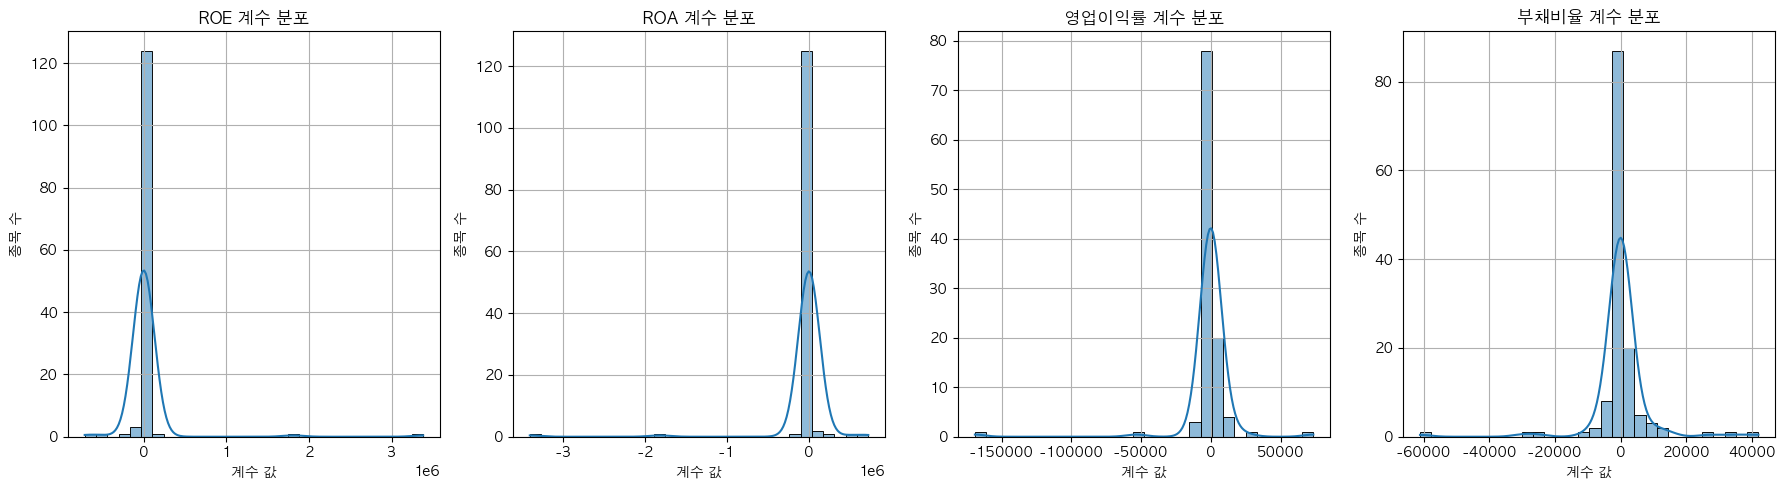


Í∞Å ÏßÄÌëúÎ≥Ñ ÌöåÍ∑Ä Í≥ÑÏàòÏùò ÌèâÍ∑† Î∞è ÌëúÏ§ÄÌé∏Ï∞®:
                ROE            ROA         ÏòÅÏóÖÏù¥ÏùµÎ•†         Î∂ÄÏ±ÑÎπÑÏú®
mean   29652.977924  -29866.627660  -1030.359579   161.516222
std   342476.596553  345631.888581  18956.456236  8795.741640

ROE Í≥ÑÏàòÍ∞Ä ÎÜíÏùÄ ÏÉÅÏúÑ 10Í∞ú Ï¢ÖÎ™©:
                    ROE           ROA          ÏòÅÏóÖÏù¥ÏùµÎ•†          Î∂ÄÏ±ÑÎπÑÏú®  \
Ï¢ÖÎ™©Î™Ö                                                                  
Î∞îÏù¥Ïò§Îã§Ïù∏      3.377345e+06 -3.409758e+06            NaN  34717.233096   
Ï†úÏ£ºÏùÄÌñâ       1.807133e+06 -1.822763e+06            NaN -61120.273676   
Ïù∏Ïπ¥Í∏àÏúµÏÑúÎπÑÏä§    2.213869e+05 -2.226109e+05            NaN   -241.639855   
ÏóêÏù¥ÌîÑÎ¶¥Î∞îÏù¥Ïò§    6.864419e+04 -6.407403e+04            NaN   2090.497050   
Ïù¥ÏàòÏä§ÌéòÏÖúÌã∞ÏºÄÎØ∏Ïª¨  6.353991e+04  5.911711e+04 -169146.897915 -29970.311386   
ÎÑ•Ïä®Í≤åÏûÑÏ¶à      4.125121e+04 -4.293850e+04            NaN   -470.373842   
ÏÑ∏Í≤ΩÌïòÏù¥ÌÖåÌÅ¨     3.864266e+04 -2

In [341]:
# Í≥ÑÏàòÎì§Ïùò Î∂ÑÌè¨Î•º ÏãúÍ∞ÅÌôî (ÌûàÏä§ÌÜ†Í∑∏Îû®)
plt.figure(figsize=(18, 5)) # Í∑∏ÎûòÌîÑ ÌÅ¨Í∏∞ Ï°∞Ï†ï

for i, feature in enumerate(features):
    if feature in df_coefficients.columns: # Ìï¥Îãπ ÌäπÏßïÏùò Í≥ÑÏàò Ïª¨ÎüºÏù¥ Ï°¥Ïû¨ÌïòÎäî Í≤ΩÏö∞ÏóêÎßå
        plt.subplot(1, len(features), i + 1)
        sns.histplot(df_coefficients[feature].dropna(), bins=30, kde=True)
        plt.title(f'{feature} Í≥ÑÏàò Î∂ÑÌè¨', fontsize=12)
        plt.xlabel('Í≥ÑÏàò Í∞í')
        plt.ylabel('Ï¢ÖÎ™© Ïàò')
        plt.grid(True)
    else:
        # Ìï¥Îãπ ÌäπÏßïÏùò Í≥ÑÏàò Ïª¨ÎüºÏù¥ ÏïÑÏòà ÏóÜÎäî Í≤ΩÏö∞ (Ïòà: Î™®Îì† Ï¢ÖÎ™©ÏóêÏÑú Ìï¥Îãπ Ïª¨ÎüºÏùò Í∞íÏù¥ ÎèôÏùºÌñàÍ±∞ÎÇò)
        plt.subplot(1, len(features), i + 1)
        plt.title(f'{feature} Í≥ÑÏàò Î∂ÑÌè¨ (Îç∞Ïù¥ÌÑ∞ Î∂ÄÏ°±)', fontsize=12)
        plt.text(0.5, 0.5, 'Í≥ÑÏàò Îç∞Ïù¥ÌÑ∞ ÏóÜÏùå', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.grid(True)


plt.tight_layout()
plt.show()

# Í∞Å ÏßÄÌëúÎ≥Ñ Í≥ÑÏàòÏùò ÌèâÍ∑† Î∞è ÌëúÏ§ÄÌé∏Ï∞® ÌôïÏù∏
print("\nÍ∞Å ÏßÄÌëúÎ≥Ñ ÌöåÍ∑Ä Í≥ÑÏàòÏùò ÌèâÍ∑† Î∞è ÌëúÏ§ÄÌé∏Ï∞®:")
print(df_coefficients[features].describe().loc[['mean', 'std']])

# ÌäπÏ†ï Í∏∞Ï§ÄÏóê Îî∞Îùº Í≥ÑÏàò Í∞í ÌôïÏù∏ (ÏòàÏãú: ROE Í≥ÑÏàòÍ∞Ä ÎÜíÏùÄ ÏÉÅÏúÑ 10Í∞ú Ï¢ÖÎ™©)
print("\nROE Í≥ÑÏàòÍ∞Ä ÎÜíÏùÄ ÏÉÅÏúÑ 10Í∞ú Ï¢ÖÎ™©:")
print(df_coefficients.sort_values(by='ROE', ascending=False).head(10))

print("\nÏòÅÏóÖÏù¥ÏùµÎ•† Í≥ÑÏàòÍ∞Ä ÎÇÆÏùÄ (ÏùåÏùò ÏòÅÌñ•Î†•Ïù¥ ÌÅ∞) ÌïòÏúÑ 10Í∞ú Ï¢ÖÎ™©:")
print(df_coefficients.sort_values(by='ÏòÅÏóÖÏù¥ÏùµÎ•†', ascending=True).head(10))

In [306]:
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 938 entries, 0 to 937
Columns: 246 entries, Ï¢ÖÎ™©Î™Ö to 20241230
dtypes: float64(244), object(2)
memory usage: 1.8+ MB


In [304]:
analysis_df['Íµ¨Î∂Ñ'].unique()

array(['Ï¢ÖÍ∞Ä', 'PER', 'PBR', 'ROE', 'ROA', 'ÏòÅÏóÖÏù¥ÏùµÎ•†', 'Î∂ÄÏ±ÑÎπÑÏú®'], dtype=object)

In [305]:
analysis_df

Ï¢ÖÎ™©Î™Ö     Íµ¨Î∂Ñ     20240102     20240103     20240104     20240105  \
0    Ï†úÏù¥Ïä§ÏΩîÌôÄÎî©Ïä§     Ï¢ÖÍ∞Ä  1430.000000  1477.000000  1408.000000  1401.000000   
1    Ï†úÏù¥Ïä§ÏΩîÌôÄÎî©Ïä§    PER          NaN          NaN          NaN          NaN   
2    Ï†úÏù¥Ïä§ÏΩîÌôÄÎî©Ïä§    PBR     1.400996     1.447042     1.379442     1.372584   
3    Ï†úÏù¥Ïä§ÏΩîÌôÄÎî©Ïä§    ROE   -38.864932   -38.864932   -38.864932   -38.864932   
4    Ï†úÏù¥Ïä§ÏΩîÌôÄÎî©Ïä§    ROA   -19.087926   -19.087926   -19.087926   -19.087926   
..       ...    ...          ...          ...          ...          ...   
933  DGBÍ∏àÏúµÏßÄÏ£º    PBR     0.420864     0.420864     0.414858     0.407352   
934  DGBÍ∏àÏúµÏßÄÏ£º    ROE     5.416470     5.416470     5.416470     5.416470   
935  DGBÍ∏àÏúµÏßÄÏ£º    ROA     4.086800     4.086800     4.086800     4.086800   
936  DGBÍ∏àÏúµÏßÄÏ£º  ÏòÅÏóÖÏù¥ÏùµÎ•†          NaN          NaN          NaN          NaN   
937  DGBÍ∏àÏúµÏßÄÏ£º   Î∂ÄÏ±ÑÎπÑÏú®    32.535720    32.535720    32.535720    32.535720   

        20240108     20240109     20240110     20240111  ...     20241216  \
0    1414.000000  1425.000000  1460.000000  1469.000000  ...  1854.000000   
1            NaN          NaN          NaN          NaN  ...          NaN   
2       1.385320     1.396097     1.430387     1.439205  ...     1.777508   
3     -38.864932   -38.864932   -38.864932   -38.864932  ...   -13.082513   
4     -19.087926   -19.087926   -19.087926   -19.087926  ...    -6.709918   
..           ...          ...          ...          ...  ...          ...   
933     0.404349     0.407852     0.412356     0.412356  ...     0.443487   
934     5.416470     5.416470     5.416470     5.416470  ...    -1.397186   
935     4.086800     4.086800     4.086800     4.086800  ...    -1.046711   
936          NaN          NaN          NaN          NaN  ...          NaN   
937    32.535720    32.535720    32.535720    32.535720  ...    33.483395   

        20241217     20241218     20241219     20241220     20241223  \
0    1871.000000  1825.000000  1847.000000  1744.000000  1725.000000   
1            NaN          NaN          NaN          NaN          NaN   
2       1.793806     1.749704     1.770796     1.672046     1.653830   
3     -13.082513   -13.082513   -13.082513   -13.082513   -13.082513   
4      -6.709918    -6.709918    -6.709918    -6.709918    -6.709918   
..           ...          ...          ...          ...          ...   
933     0.425199     0.431295     0.427231     0.417579     0.428755   
934    -1.397186    -1.397186    -1.397186    -1.397186    -1.397186   
935    -1.046711    -1.046711    -1.046711    -1.046711    -1.046711   
936          NaN          NaN          NaN          NaN          NaN   
937    33.483395    33.483395    33.483395    33.483395    33.483395   

        20241224     20241226     20241227     20241230  
0    1739.000000  1702.000000  1626.000000  1693.000000  
1            NaN          NaN          NaN          NaN  
2       1.667252     1.631779     1.558914     1.623150  
3     -13.082513   -13.082513   -13.082513   -13.082513  
4      -6.709918    -6.709918    -6.709918    -6.709918  
..           ...          ...          ...          ...  
933     0.429263     0.428755     0.422659     0.415547  
934    -1.397186    -1.397186    -1.397186    -1.397186  
935    -1.046711    -1.046711    -1.046711    -1.046711  
936          NaN          NaN          NaN          NaN  
937    33.483395    33.483395    33.483395    33.483395  

[938 rows x 246 columns]

In [300]:
def meaningful_correlation_analysis(analysis_df):
    """ÏùòÎØ∏ÏûàÎäî ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Î∂ÑÏÑù (PER, PBR Ï†úÏô∏)"""
    
    results = []
    companies = analysis_df['Ï¢ÖÎ™©Î™Ö'].unique()
    
    for company in companies:
        try:
            company_data = analysis_df[analysis_df['Ï¢ÖÎ™©Î™Ö'] == company]
            
            # Íµ¨Î∂ÑÎ≥ÑÎ°ú ÎîïÏÖîÎÑàÎ¶¨ ÎßåÎì§Í∏∞
            metrics_dict = {}
            for _, row in company_data.iterrows():
                metric = row['Íµ¨Î∂Ñ']
                values = []
                for col in row.index[2:]:
                    if pd.notna(row[col]):
                        values.append(float(row[col]))
                
                if len(values) > 0:
                    metrics_dict[metric] = values
            
            if 'Ï¢ÖÍ∞Ä' in metrics_dict and len(metrics_dict) > 1:
                stock_prices = metrics_dict['Ï¢ÖÍ∞Ä']
                correlations = {'Ï¢ÖÎ™©Î™Ö': company, 'Îç∞Ïù¥ÌÑ∞Ïàò': len(stock_prices)}
                
                # PER, PBR Ï†úÏô∏ÌïòÍ≥† Î∂ÑÏÑù
                exclude_metrics = ['Ï¢ÖÍ∞Ä', 'PER', 'PBR']
                
                for metric, values in metrics_dict.items():
                    if (metric not in exclude_metrics and 
                        len(values) == len(stock_prices)):
                        
                        # Í∞íÏù¥ Î™®Îëê Í∞ôÏúºÎ©¥ Ïä§ÌÇµ (ÏÉÅÏàò Ï≤¥ÌÅ¨)
                        if len(set(values)) > 1:  # ÏÑúÎ°ú Îã§Î•∏ Í∞íÏù¥ ÏûàÏùÑ ÎïåÎßå
                            corr = pd.Series(stock_prices).corr(pd.Series(values))
                            correlations[metric] = corr
                        else:
                            correlations[metric] = 0.0  # ÏÉÅÏàòÎ©¥ ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ 0
                
                results.append(correlations)
                
        except Exception as e:
            continue
    
    return pd.DataFrame(results)

# Ïã§Ìñâ
meaningful_results = meaningful_correlation_analysis(analysis_df)
print(meaningful_results.head())

       Ï¢ÖÎ™©Î™Ö  Îç∞Ïù¥ÌÑ∞Ïàò       ROE       ROA     ÏòÅÏóÖÏù¥ÏùµÎ•†      Î∂ÄÏ±ÑÎπÑÏú®
0  Ï†úÏù¥Ïä§ÏΩîÌôÄÎî©Ïä§   244  0.270580  0.253226 -0.440476 -0.202563
1   ÌÄÄÌÉÄÎß§Ìä∏Î¶≠Ïä§   244  0.377161  0.514529 -0.156500  0.381488
2     ÏÇºÏùµÏïÖÍ∏∞   244  0.131611  0.126966  0.027908  0.461236
3     ÎÇòÎÖ∏ÏóîÌÖç   244 -0.176444 -0.176193 -0.270843 -0.013277
4       ÎèôÎ∞©   244  0.439246  0.454988 -0.250219 -0.413954


In [301]:
meaningful_results

Ï¢ÖÎ™©Î™Ö  Îç∞Ïù¥ÌÑ∞Ïàò       ROE       ROA     ÏòÅÏóÖÏù¥ÏùµÎ•†      Î∂ÄÏ±ÑÎπÑÏú®
0      Ï†úÏù¥Ïä§ÏΩîÌôÄÎî©Ïä§   244  0.270580  0.253226 -0.440476 -0.202563
1       ÌÄÄÌÉÄÎß§Ìä∏Î¶≠Ïä§   244  0.377161  0.514529 -0.156500  0.381488
2         ÏÇºÏùµÏïÖÍ∏∞   244  0.131611  0.126966  0.027908  0.461236
3         ÎÇòÎÖ∏ÏóîÌÖç   244 -0.176444 -0.176193 -0.270843 -0.013277
4           ÎèôÎ∞©   244  0.439246  0.454988 -0.250219 -0.413954
..         ...   ...       ...       ...       ...       ...
129  HDCÌòÑÎåÄÏÇ∞ÏóÖÍ∞úÎ∞ú   244 -0.482019 -0.499811  0.612235  0.507965
130    HLBÏÉùÎ™ÖÍ≥ºÌïô   244  0.000000  0.000000 -0.089372  0.731293
131       ÌïúÍµ≠ÏΩúÎßà   244  0.900728  0.894434  0.556081  0.308976
132   ÏóêÏä§ÎîîÎ∞îÏù¥Ïò§ÏÑºÏÑú   244 -0.475579 -0.475409       NaN  0.387196
133    DGBÍ∏àÏúµÏßÄÏ£º   244  0.382986  0.381847       NaN -0.418849

[134 rows x 6 columns]

In [307]:
analysis_df

Ï¢ÖÎ™©Î™Ö     Íµ¨Î∂Ñ     20240102     20240103     20240104     20240105  \
0    Ï†úÏù¥Ïä§ÏΩîÌôÄÎî©Ïä§     Ï¢ÖÍ∞Ä  1430.000000  1477.000000  1408.000000  1401.000000   
1    Ï†úÏù¥Ïä§ÏΩîÌôÄÎî©Ïä§    PER          NaN          NaN          NaN          NaN   
2    Ï†úÏù¥Ïä§ÏΩîÌôÄÎî©Ïä§    PBR     1.400996     1.447042     1.379442     1.372584   
3    Ï†úÏù¥Ïä§ÏΩîÌôÄÎî©Ïä§    ROE   -38.864932   -38.864932   -38.864932   -38.864932   
4    Ï†úÏù¥Ïä§ÏΩîÌôÄÎî©Ïä§    ROA   -19.087926   -19.087926   -19.087926   -19.087926   
..       ...    ...          ...          ...          ...          ...   
933  DGBÍ∏àÏúµÏßÄÏ£º    PBR     0.420864     0.420864     0.414858     0.407352   
934  DGBÍ∏àÏúµÏßÄÏ£º    ROE     5.416470     5.416470     5.416470     5.416470   
935  DGBÍ∏àÏúµÏßÄÏ£º    ROA     4.086800     4.086800     4.086800     4.086800   
936  DGBÍ∏àÏúµÏßÄÏ£º  ÏòÅÏóÖÏù¥ÏùµÎ•†          NaN          NaN          NaN          NaN   
937  DGBÍ∏àÏúµÏßÄÏ£º   Î∂ÄÏ±ÑÎπÑÏú®    32.535720    32.535720    32.535720    32.535720   

        20240108     20240109     20240110     20240111  ...     20241216  \
0    1414.000000  1425.000000  1460.000000  1469.000000  ...  1854.000000   
1            NaN          NaN          NaN          NaN  ...          NaN   
2       1.385320     1.396097     1.430387     1.439205  ...     1.777508   
3     -38.864932   -38.864932   -38.864932   -38.864932  ...   -13.082513   
4     -19.087926   -19.087926   -19.087926   -19.087926  ...    -6.709918   
..           ...          ...          ...          ...  ...          ...   
933     0.404349     0.407852     0.412356     0.412356  ...     0.443487   
934     5.416470     5.416470     5.416470     5.416470  ...    -1.397186   
935     4.086800     4.086800     4.086800     4.086800  ...    -1.046711   
936          NaN          NaN          NaN          NaN  ...          NaN   
937    32.535720    32.535720    32.535720    32.535720  ...    33.483395   

        20241217     20241218     20241219     20241220     20241223  \
0    1871.000000  1825.000000  1847.000000  1744.000000  1725.000000   
1            NaN          NaN          NaN          NaN          NaN   
2       1.793806     1.749704     1.770796     1.672046     1.653830   
3     -13.082513   -13.082513   -13.082513   -13.082513   -13.082513   
4      -6.709918    -6.709918    -6.709918    -6.709918    -6.709918   
..           ...          ...          ...          ...          ...   
933     0.425199     0.431295     0.427231     0.417579     0.428755   
934    -1.397186    -1.397186    -1.397186    -1.397186    -1.397186   
935    -1.046711    -1.046711    -1.046711    -1.046711    -1.046711   
936          NaN          NaN          NaN          NaN          NaN   
937    33.483395    33.483395    33.483395    33.483395    33.483395   

        20241224     20241226     20241227     20241230  
0    1739.000000  1702.000000  1626.000000  1693.000000  
1            NaN          NaN          NaN          NaN  
2       1.667252     1.631779     1.558914     1.623150  
3     -13.082513   -13.082513   -13.082513   -13.082513  
4      -6.709918    -6.709918    -6.709918    -6.709918  
..           ...          ...          ...          ...  
933     0.429263     0.428755     0.422659     0.415547  
934    -1.397186    -1.397186    -1.397186    -1.397186  
935    -1.046711    -1.046711    -1.046711    -1.046711  
936          NaN          NaN          NaN          NaN  
937    33.483395    33.483395    33.483395    33.483395  

[938 rows x 246 columns]